In [30]:
import warnings
import re
import emoji
import MeCab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import tensorflow as tf
import keras.backend as K
from keras_self_attention import SeqSelfAttention
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import InputLayer
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Add
from keras.layers import Concatenate
from keras.layers import ZeroPadding1D
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras.layers import Activation
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPool1D
from keras.layers import AveragePooling1D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import SimpleRNN
from keras.layers import CuDNNLSTM
from keras.layers import Bidirectional
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.optimizers import Optimizer
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import RMSprop
from keras.optimizers import Nadam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import text
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from gensim.models.word2vec import Word2Vec

warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [46]:
# Input parameters
config = {
    # Text parameters
    "MAX_FEATURE": 10000, 
    "MAX_LEN": 64, 
    "EMBED_SIZE": 300, 

    # Convolution parameters
    "filter_length": 3, 
    "nb_filter": 150, 
    "pool_length": 2, 
    "cnn_activation": 'relu', 
    "border_mode": 'same', 

    # RNN parameters
    "lstm_cell": 128, 
    "output_size": 50, 
    "rnn_activation": 'tanh', 
    "recurrent_activation": 'hard_sigmoid', 
    
    # FC and Dropout
    "fc_cell": 128, 
    "dropout_rate": 0.25, 

    # Compile parameters
    "loss": 'binary_crossentropy', 
    "optimizer": 'adam', 

    # Training parameters
    "batch_size": 256, 
    "nb_epoch": 500, 
    "validation_split": 0.50, 
    "shuffle": True
}

In [3]:
df = pd.read_csv(r"C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\data\all_20200423.csv")
# create the label
df["label"] = df["rating"].apply(lambda x: 0 if int(x) <= 3 else 1)
# select only relevant columns
df = df[["content", "label"]]
df["content"] = df["content"].map(str)
df.sample(5)

content  label
12217  サインインの読み込みから先へ進めない。いつまで経ってもグルグル読み込み中のまま。アンインスト...      0
6950       音楽流したまま電源切れるし ホーム画面まで戻せるし最高ですだが求めてる歌の本家が出てこない      1
8673                    画面を消したら音楽がきれてしまいます。仕様ですか？バグですかね？      1
415                                   時々エラーが起こるのがなければ最高。      1
12689                                 インストールすらできないクソアプリ。      0

In [4]:
df["length"] = df["content"].map(len)
text_len = df["length"].values
max_len = text_len.max()

len_sum = [0] * max_len
for i in text_len:
    len_sum[i-1] += 1
    
len_cum = [len_sum[0]] + [0] * (max_len-1)
for i in range(1, max_len):
    len_cum[i] += len_sum[i] + len_cum[i-1]

print('Cumulative %   # Words  # Comments')
for i in range(max_len):
    len_cum[i] /= len(text_len)
    if len_sum[i] != 0:
        if (len_cum[i] >= 0.8 and len_cum[i-1] < 0.8):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.85 and len_cum[i-1] < 0.85):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.9 and len_cum[i-1] < 0.9):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.92 and len_cum[i-1] < 0.92):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.95 and len_cum[i-1] < 0.95):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))

Cumulative %   # Words  # Comments
 80.14077   	  55 	    84
 85.21870   	  68 	    46
 90.21044   	  86 	    36
 92.06349   	  96 	    21
 95.07290   	  118 	    14


In [5]:
def create_mecab_list(text):
    pos_list = [10, 11, 31, 32, 34]
    pos_list.extend(list(range(36,50)))
    pos_list.extend([59, 60, 62, 67])

    mecab_list = []
    mecab = MeCab.Tagger("-Owakati")
    mecab.parse("")
    # encoding = text.encode('utf-8')
    node = mecab.parseToNode(text)
    while node:
        if len(node.surface) > 1:
            if node.posid in pos_list:
                morpheme = node.surface
                mecab_list.append(morpheme)
        node = node.next
    return mecab_list

def give_emoji_free_text(text):
    allchars = [string for string in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    cleaned_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return cleaned_text

def clean_text(text):
    # Remove emoji
    text = give_emoji_free_text(text)
    # Remove punctuation
    text = re.sub(r'[^\w\d\s]+', '', text)
    # Remove digits
    text = ''.join([i for i in text if not i.isdigit()]) 
    # Tokenize the sentence
    tokenised_text_list = create_mecab_list(text)
    return tokenised_text_list

def create_word2index_and_index2word(df):
    df["cleaned_text"] = df["content"].apply(clean_text)
    sum_list = []
    for index, row in df.iterrows():
        sum_list += row["cleaned_text"]

    word2index = dict()
    index2word = dict()
    num_words = 0
    for word in sum_list:
        if word not in word2index:
            # First entry of word into vocabulary
            word2index[word] = num_words
            index2word[num_words] = word
            num_words += 1
    
    return word2index, index2word

def convert_tokens_to_ids(tokens_list, word2index):
    ids_list = []
    for token in tokens_list:
        if word2index.get(token, None) != None:
            ids_list.append(word2index[token])
    return ids_list

def remove_empty_ids_rows(df):
    empty = (df['ids'].map(len) == 0)
    return df[~empty]

In [6]:
word2index, index2word = create_word2index_and_index2word(df)
df["ids"] = df["content"].apply(lambda x: convert_tokens_to_ids(clean_text(x), word2index))
df = remove_empty_ids_rows(df)
df.head()

content  label  length  \
0  アプリをダウンロードしたばかりで、バックグラウンドで聴いています。星の理由は曲のダウンロード...      0     211   
1                                                nan      1       3   
2  ダウンロードはネットが必要ですが、その後はオフラインで聞くことが出来てとても便利です。 オフ...      1     172   
3  広告をあまり見たくない方は、下のタブにある本人→右上のアイコンを押すと、30秒間の広告を見る...      1     124   
4  音楽をダウンロードしようと思ったら、ダウンロードマークが無くて、追加しかない状態だった。その...      0     121   

                                        cleaned_text  \
0  [アプリ, ダウンロード, バックグラウンド, 聴い, 理由, ダウンロード, 出来, 聴い...   
1                                              [nan]   
2  [ダウンロード, ネット, 必要, その後, オフライン, 聞く, 出来, 便利, オフライ...   
3  [広告, タブ, ある, 本人, アイコ, 押す, 広告, 見る, 代わり, 時間, 広告,...   
4  [音楽, ダウンロード, しよ, 思っ, ダウンロード, マーク, 無く, 追加, ない, ...   

                                                 ids  
0  [0, 1, 2, 3, 4, 1, 5, 3, 6, 7, 8, 9, 10, 11, 1...  
1                                               [26]  
2  [1, 27, 28, 29, 30, 31, 5, 32, 30, 33, 34, 35,...  
3  [14, 42, 43, 44, 45, 46, 14, 47, 48, 49, 14, 5...  
4  [15, 1, 62, 63, 1, 64, 65, 35, 66, 67, 68, 69,...

In [7]:
x = df["ids"].map(lambda x: np.array(x))
x = sequence.pad_sequences(x, maxlen=config["MAX_LEN"], padding="post")
print("Features: \n", x)
y = df["label"].values
print("Labels: \n", y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=17)

Features: 
 [[   0    1    2 ...    0    0    0]
 [  26    0    0 ...    0    0    0]
 [   1   27   28 ...    0    0    0]
 ...
 [ 531    0    0 ...    0    0    0]
 [ 284    0    0 ...    0    0    0]
 [7503    0    0 ...    0    0    0]]
Labels: 
 [0 1 1 ... 1 1 1]


In [8]:
Counter(df["label"])

Counter({0: 5374, 1: 7542})

In [9]:
def get_embedding_index(model_path):
    w2v = Word2Vec.load(model_path)
    embedding_index = {}
    for word in w2v.wv.vocab:
        embedding_index[word] = w2v.wv.word_vec(word)
    print('Loaded {} word vectors.'.format(len(embedding_index)))

    return embedding_index

def get_embedding_matrix(word2index, embeddings_index, embed_size):
    embedding_matrix = np.zeros((len(word2index) + 1, embed_size))
    for word, i in word2index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words found in embedding index will be pretrained vectors.
            embedding_matrix[i+1] = embedding_vector
        else:
            # words not found in embedding index will be random vectors with certain mean&std.
            embedding_matrix[i+1] = np.random.normal(0.053, 0.3146, size=(1, embed_size))[0]

    # save embedding matrix
    # embed_df = pd.DataFrame(embedding_matrix)
    # embed_df.to_csv(self.path_embedding_matrix, header=None, sep=' ')

    return embedding_matrix

In [10]:
embedding_index = get_embedding_index(r'F:\embedding_file\word2vec\ja.bin')
embedding_matrix = get_embedding_matrix(word2index, embedding_index, embed_size=300)

Loaded 50108 word vectors.


In [11]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
# Reference from https://medium.com/@mlguy/adding-custom-loss-and-optimizer-in-keras-e255764e1b7d
class COCOB(Optimizer):
    """Coin Betting Optimizer from the paper:
        https://arxiv.org/pdf/1705.07795.pdf
    """
    def __init__(self, alpha=100, **kwargs):
        """
        Initialize COCOB Optimizer
        Args:
            alpha: Refer to paper.
        """
        super(COCOB, self).__init__(**kwargs)
        self._alpha = alpha
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
    def get_updates(self, params, loss, contraints=None):
        self.updates = [K.update_add(self.iterations, 1)]
        grads = self.get_gradients(loss, params)
        shapes = [K.int_shape(p) for p in params]
        L = [K.variable(np.full(fill_value=1e-8, shape=shape)) for shape in shapes]
        reward = [K.zeros(shape) for shape in shapes]
        tilde_w = [K.zeros(shape) for shape in shapes]
        gradients_sum = [K.zeros(shape) for shape in shapes]
        gradients_norm_sum = [K.zeros(shape) for shape in shapes]
        for p, g, li, ri, twi, gsi, gns in zip(params, grads, L, reward,
                                                     tilde_w,gradients_sum,
                                                       gradients_norm_sum):
            grad_sum_update = gsi + g
            grad_norm_sum_update = gns + K.abs(g)
            l_update = K.maximum(li, K.abs(g))
            reward_update = K.maximum(ri - g * twi, 0)
            new_w = - grad_sum_update / (l_update * (K.maximum(grad_norm_sum_update + l_update, self._alpha * l_update))) * (reward_update + l_update)
            param_update = p - twi + new_w
            tilde_w_update = new_w
            self.updates.append(K.update(gsi, grad_sum_update))
            self.updates.append(K.update(gns, grad_norm_sum_update))
            self.updates.append(K.update(li, l_update))
            self.updates.append(K.update(ri, reward_update))
            self.updates.append(K.update(p, param_update))
            self.updates.append(K.update(twi, tilde_w_update))
        return self.updates
    def get_config(self):
        config = {'alpha': float(K.get_value(self._alpha)) }
        base_config = super(COCOB, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [20]:
def plot_history(history):
    # plot results
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f1 = history.history['get_f1']
    val_f1 = history.history['val_get_f1']

    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.title('Loss')
    epochs = len(loss)
    plt.plot(range(epochs), loss, marker='.', label='loss')
    plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
    plt.legend(loc='best')
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['top'].set_linewidth(5)
    ax.spines['right'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.set_facecolor('snow')
    plt.grid(color='lightgray', linestyle='-', linewidth=1)
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.subplot(2,1,2)
    plt.title('F1 Score')
    plt.plot(range(epochs), f1, marker='.', label='f1')
    plt.plot(range(epochs), val_f1, marker='.', label='val_f1')
    plt.legend(loc='best')
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['top'].set_linewidth(5)
    ax.spines['right'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.set_facecolor('snow')
    plt.grid(color='lightgray', linestyle='-', linewidth=1)
    plt.xlabel('epoch')
    plt.ylabel('f1')
    plt.show()

In [14]:
def train_simple_rnn(x_train, y_train, wv_matrix):
    tf.keras.backend.clear_session()
    
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    x = SimpleRNN(
        units=config["output_size"], 
        activation=config["rnn_activation"], 
        kernel_regularizer=regularizers.l2(0.3))(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    model.compile(loss=config["loss"], optimizer=config["optimizer"], metrics=[get_f1])

    print("="*20, "Start Training Simple RNN", "="*20)

    path = 'weights\{}_weights.hdf5'.format("rnn")
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=100, verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

    history = model.fit(
        x_train, y_train, 
        batch_size=config['batch_size'], 
        epochs=config['nb_epoch'], 
        validation_split=config['validation_split'], 
        shuffle=config['shuffle'], 
        verbose=0, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [15]:
def train_gru(x_train, y_train, wv_matrix, verbose=1):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    x = Bidirectional(GRU(units=config["output_size"], return_sequences=True, dropout=config['dropout_rate']))(x)
    x = Bidirectional(GRU(units=config["output_size"], return_sequences=True, dropout=config['dropout_rate']))(x)
    x = Bidirectional(GRU(units=config["output_size"], return_sequences=False, dropout=config['dropout_rate']))(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    model.compile(loss=config["loss"], optimizer=config["optimizer"], metrics=[get_f1])

    print("="*20, "Start Training GRU", "="*20)

    path = 'weights\{}_weights.hdf5'.format("gru")
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=20, verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

    history = model.fit(
        x_train, y_train, 
        batch_size=config['batch_size'], 
        epochs=config['nb_epoch'], 
        validation_split=config['validation_split'], 
        shuffle=config['shuffle'], 
        verbose=verbose, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [27]:
def train_lstm(x_train, y_train, wv_matrix, verbose=1):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    x = LSTM(units=config['lstm_cell'], return_sequences=True, kernel_regularizer=regularizers.l2(0.3))(x)
    x = LSTM(units=config['lstm_cell'], return_sequences=True, kernel_regularizer=regularizers.l2(0.3))(x)
    x = LSTM(units=config['lstm_cell'], return_sequences=False, kernel_regularizer=regularizers.l2(0.3))(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    model.compile(loss=config["loss"], optimizer=config["optimizer"], metrics=[get_f1])

    print("="*20, "Start Training LSTM", "="*20)

    path = 'weights\{}_weights.hdf5'.format("lstm")
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=20, verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

    history = model.fit(
        x_train, y_train, 
        batch_size=config['batch_size'], 
        epochs=config['nb_epoch'], 
        validation_split=config['validation_split'], 
        shuffle=config['shuffle'], 
        verbose=verbose, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [21]:
def train_bilstm(x_train, y_train, wv_matrix, verbose=1):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    x = Bidirectional(LSTM(
        units=config['output_size'], 
        return_sequences=True, 
        dropout=config['dropout_rate'], 
        kernel_regularizer=regularizers.l2(0.3)))(x)
    x = Bidirectional(LSTM(
        units=config['output_size'], 
        return_sequences=True, 
        dropout=config['dropout_rate'], 
        kernel_regularizer=regularizers.l2(0.3)))(x)
    x = Bidirectional(LSTM(
        units=config['output_size'], 
        return_sequences=False, 
        kernel_regularizer=regularizers.l2(0.3)))(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(config['fc_cell'])(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    model.compile(loss=config["loss"], optimizer=config["optimizer"], metrics=[get_f1])

    print("="*20, "Start Training BiLSTM", "="*20)

    path = 'weights\weights.hdf5'
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=20, verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

    history = model.fit(
        x_train, y_train, 
        batch_size=config['batch_size'], 
        epochs=config['nb_epoch'], 
        validation_split=config['validation_split'], 
        shuffle=config['shuffle'], 
        verbose=verbose, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [53]:
def train_attention(x_train, y_train, wv_matrix, verbose=1):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    x = SeqSelfAttention(units=128, kernel_regularizer=regularizers.l2(0.1))(x)
    x = SeqSelfAttention(units=128, kernel_regularizer=regularizers.l2(0.1))(x)
    x = SeqSelfAttention(units=128, kernel_regularizer=regularizers.l2(0.1))(x)
    x = SeqSelfAttention(units=128, kernel_regularizer=regularizers.l2(0.1))(x)
    x = SeqSelfAttention(units=128, kernel_regularizer=regularizers.l2(0.1))(x)
    x = SeqSelfAttention(units=128, kernel_regularizer=regularizers.l2(0.1))(x)
    x = Flatten()(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    model.compile(loss=config["loss"], optimizer="adam", metrics=[get_f1])

    print("="*20, "Start Training Attention", "="*20)

    path = 'weights\weights.hdf5'
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=20, verbose=1, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001, verbose=1)

    history = model.fit(
        x_train, y_train, 
        batch_size=config['batch_size'], 
        epochs=config['nb_epoch'], 
        validation_split=config['validation_split'], 
        shuffle=config['shuffle'], 
        verbose=verbose, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [47]:
# Yoon Kim's paper: Convolutional Neural Networks for Sentence Classification
# Reference from https://www.aclweb.org/anthology/D14-1181.pdf
def train_cnn_static(x_train, y_train, wv_matrix, trainable=False, verbose=1):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=trainable)(x_input)
    
    x_conv_1 = Conv1D(filters=config['nb_filter'], 
                      kernel_size=3, 
                      padding=config['border_mode'], 
                      kernel_regularizer=regularizers.l2(0.3))(x)
    x_conv_1 = BatchNormalization()(x_conv_1)
    x_conv_1 = Activation("relu")(x_conv_1)
    x_conv_1 = MaxPooling1D(pool_size=(config["MAX_LEN"]-3+1), strides=1, padding="valid")(x_conv_1)
    
    x_conv_2 = Conv1D(filters=config['nb_filter'], 
                      kernel_size=4, 
                      padding=config['border_mode'], 
                      kernel_regularizer=regularizers.l2(0.3))(x)
    x_conv_2 = BatchNormalization()(x_conv_2)
    x_conv_2 = Activation("relu")(x_conv_2)
    x_conv_2 = MaxPooling1D(pool_size=(config["MAX_LEN"]-4+1), strides=1, padding="valid")(x_conv_2)
    
    x_conv_3 = Conv1D(filters=config['nb_filter'], 
                      kernel_size=5, 
                      padding=config['border_mode'], 
                      kernel_regularizer=regularizers.l2(0.3))(x)
    x_conv_3 = BatchNormalization()(x_conv_3)
    x_conv_3 = Activation("relu")(x_conv_3)
    x_conv_3 = MaxPooling1D(pool_size=(config["MAX_LEN"]-5+1), strides=1, padding="valid")(x_conv_3)
    
    main = Concatenate(axis=1)([x_conv_1, x_conv_2, x_conv_3])
    main = Flatten()(main)
    main = Dropout(config['dropout_rate'])(main)
    main = Dense(units=1)(main)
    main = Activation('sigmoid')(main)
    model = Model(inputs=x_input, outputs=main)

    model.compile(loss=config["loss"], optimizer=config["optimizer"], metrics=[get_f1])

    print("="*20, "Start Training CNN-static", "="*20)

    path = 'weights\{}_weights.hdf5'.format("lstm")
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=20, verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

    history = model.fit(
        x_train, y_train, 
        batch_size=config['batch_size'], 
        epochs=config['nb_epoch'], 
        validation_split=config['validation_split'], 
        shuffle=config['shuffle'], 
        verbose=verbose, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [48]:
def train_cnn_multichannel(x_train, y_train, wv_matrix, trainable=False, verbose=1):
    tf.keras.backend.clear_session()
    
    # Channel 1
    x_input_1 = Input(shape=(config["MAX_LEN"], ))
    embedding_1 = Embedding(
        wv_matrix.shape[0], 
        wv_matrix.shape[1], 
        weights=[wv_matrix], 
        trainable=trainable)(x_input_1)
    x_conv_1 = Conv1D(
        filters=config['nb_filter'], 
        kernel_size=3, 
        padding=config['border_mode'], 
        kernel_regularizer=regularizers.l2(0.3))(embedding_1)
    x_conv_1 = BatchNormalization()(x_conv_1)
    x_conv_1 = Activation("relu")(x_conv_1)
    x_conv_1 = MaxPooling1D(pool_size=(config["MAX_LEN"]-3+1), strides=1, padding="valid")(x_conv_1)
    flat_1 = Flatten()(x_conv_1)
    
    # Channel 2
    x_input_2 = Input(shape=(config["MAX_LEN"], ))
    embedding_2 = Embedding(
        wv_matrix.shape[0], 
        wv_matrix.shape[1], 
        weights=[wv_matrix], 
        trainable=trainable)(x_input_2)
    x_conv_2 = Conv1D(
        filters=config['nb_filter'], 
        kernel_size=3, 
        padding=config['border_mode'], 
        kernel_regularizer=regularizers.l2(0.3))(embedding_2)
    x_conv_2 = BatchNormalization()(x_conv_2)
    x_conv_2 = Activation("relu")(x_conv_2)
    x_conv_2 = MaxPooling1D(pool_size=(config["MAX_LEN"]-3+1), strides=1, padding="valid")(x_conv_2)
    flat_2 = Flatten()(x_conv_2)
    
    # Channel 1
    x_input_3 = Input(shape=(config["MAX_LEN"], ))
    embedding_3 = Embedding(
        wv_matrix.shape[0], 
        wv_matrix.shape[1], 
        weights=[wv_matrix], 
        trainable=trainable)(x_input_3)
    x_conv_3 = Conv1D(
        filters=config['nb_filter'], 
        kernel_size=3, 
        padding=config['border_mode'], 
        kernel_regularizer=regularizers.l2(0.3))(embedding_3)
    x_conv_3 = BatchNormalization()(x_conv_3)
    x_conv_3 = Activation("relu")(x_conv_3)
    x_conv_3 = MaxPooling1D(pool_size=(config["MAX_LEN"]-3+1), strides=1, padding="valid")(x_conv_3)
    flat_3 = Flatten()(x_conv_3)
    
    main = Concatenate(axis=1)([flat_1, flat_2, flat_3])
    main = Dense(units=100)(main)
    main = Activation('relu')(main)
    main = Dropout(config['dropout_rate'])(main)
    main = Dense(units=1)(main)
    main = Activation('sigmoid')(main)
    model = Model(inputs=[x_input_1, x_input_2, x_input_3], outputs=main)

    model.compile(loss=config["loss"], optimizer=config["optimizer"], metrics=[get_f1])

    print("="*20, "Start Training CNN-multichannel", "="*20)

    path = 'weights\{}_weights.hdf5'.format("lstm")
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=20, verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

    history = model.fit(
        [x_train, x_train, x_train], y_train, 
        batch_size=config['batch_size'], 
        epochs=config['nb_epoch'], 
        validation_split=config['validation_split'], 
        shuffle=config['shuffle'], 
        verbose=verbose, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [49]:
def train_cnn_lstm(x_train, y_train, wv_matrix, verbose=1):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    x = Conv1D(filters=config['nb_filter'], kernel_size=config['filter_length'], padding=config['border_mode'])(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling1D(pool_size=config['pool_length'])(x)
    x = LSTM(units=config['lstm_cell'], return_sequences=False, kernel_regularizer=regularizers.l2(0.3))(x)
    x = Dense(config['fc_cell']*2)(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    model.compile(loss=config['loss'], optimizer=config['optimizer'], metrics=[get_f1])

    print("="*20, "Start Training CNN-LSTM", "="*20)

    path = 'weights\{}_weights.hdf5'.format("cnn_lstm")
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=20, verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

    history = model.fit(
        x_train, y_train, 
        batch_size=config['batch_size'], 
        epochs=config['nb_epoch'], 
        validation_split=config['validation_split'], 
        shuffle=config['shuffle'], 
        verbose=verbose, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [81]:
def identity_resnet_block(x, nb_filter):
    x_shortcut = x

    # First component of main path
    res_x = Conv1D(
        filters=nb_filter, 
        kernel_size=5, 
        strides=1, 
        padding='same', 
        kernel_regularizer=regularizers.l2(0.01))(x)
    res_x = BatchNormalization()(res_x)
    res_x = Activation("relu")(res_x)

    # Second component of main path
    res_x = Conv1D(
        filters=nb_filter, 
        kernel_size=5, 
        strides=1, 
        padding='same', 
        kernel_regularizer=regularizers.l2(0.01))(res_x)
    res_x = BatchNormalization()(res_x)
    res_x = Activation("relu")(res_x)

    # Third component of main path
    res_x = Conv1D(
        filters=nb_filter, 
        kernel_size=5, 
        strides=1, 
        padding='same', 
        kernel_regularizer=regularizers.l2(0.01))(res_x)
    res_x = BatchNormalization()(res_x)

    # Final Step: add shortcut value to the main path
    x = Add()([x_shortcut, res_x])
    output = Activation('relu')(x)
    return output

def convolutional_resnet_block(x, nb_filter):
    x_shortcut = x

    # First component of main path
    res_x = Conv1D(
        filters=nb_filter, 
        kernel_size=5, 
        strides=1, 
        padding='same', 
        kernel_regularizer=regularizers.l2(0.01))(x)
    res_x = BatchNormalization()(res_x)
    res_x = Activation("relu")(res_x)

    # Second component of main path
    res_x = Conv1D(
        filters=nb_filter, 
        kernel_size=5, 
        strides=1, 
        padding='same', 
        kernel_regularizer=regularizers.l2(0.01))(res_x)
    res_x = BatchNormalization()(res_x)
    res_x = Activation("relu")(res_x)

    # Third component of main path
    res_x = Conv1D(
        filters=nb_filter, 
        kernel_size=5, 
        strides=1, 
        padding='same', 
        kernel_regularizer=regularizers.l2(0.01))(res_x)
    res_x = BatchNormalization()(res_x)

    # Shortcut path
    x_shortcut = Conv1D(
        filters=nb_filter, 
        kernel_size=5, 
        strides=1, 
        padding='same', 
        kernel_regularizer=regularizers.l2(0.01))(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)

    # Final Step: add shortcut value to the main path
    x = Add()([x_shortcut, res_x])
    output = Activation('relu')(x)
    return output

def train_text_resnet(x_train, y_train, wv_matrix, verbose=1):
    tf.keras.backend.clear_session()
    # Resnet for reviews of UtaPass and KKBOX
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(0.25)(x)

    # Stage 1
    x = Conv1D(filters=64, kernel_size=3, strides=2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    # Stage 2
    x = convolutional_resnet_block(x, 64)
    x = identity_resnet_block(x, 64)
    x = identity_resnet_block(x, 64)
    # Stage 3
    x = convolutional_resnet_block(x, 128)
    x = identity_resnet_block(x, 128)
    x = identity_resnet_block(x, 128)
    x = identity_resnet_block(x, 128)
    # Stage 4
    x = convolutional_resnet_block(x, 256)
    x = identity_resnet_block(x, 256)
    x = identity_resnet_block(x, 256)
    x = identity_resnet_block(x, 256)
    x = identity_resnet_block(x, 256)
    x = identity_resnet_block(x, 256)
    # Stage 5
    x = convolutional_resnet_block(x, 512)
    x = identity_resnet_block(x, 512)
    x = identity_resnet_block(x, 512)
    # Average pool
    x = AveragePooling1D(pool_size = 1)(x)
    # Output layer
    x = Flatten()(x)

    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dense(units=1)(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)

    model = Model(inputs=x_input, outputs=x)
    model.compile(loss=config["loss"],
                  optimizer=config["optimizer"],
                  metrics=[get_f1])
    
    print("="*20, "Start Training Text-ResNet", "="*20)
    
    path = r'C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\notebook\weights\text_resnet_weights.hdf5'
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=20, verbose=1, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50, min_lr=0.001)
    
    history = model.fit(
        x_train, y_train, 
        batch_size=config["batch_size"], 
        epochs=config["nb_epoch"], 
        validation_split=config["validation_split"], 
        shuffle=config["shuffle"], 
        verbose=verbose, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [17]:
def predict(sentences, model):
    y_prob = model.predict(x_test)
    y_prob = y_prob.squeeze()
    y_pred = (y_prob > 0.5) 
    return y_pred

In [18]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
adagrad = Adagrad(learning_rate=0.01)
adadelta = Adadelta(learning_rate=1.0, rho=0.95)
rmsprop = RMSprop(learning_rate=0.001, rho=0.9)
nadam = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [26]:
opt_list = ["adam", "sgd", "adagrad", "adadelta", "rmsprop", "nadam", "cocob"]
rnn_history_list = []
rnn_model_list = []
rnn_performance = []

for i, optimizer in enumerate([adam, sgd, adagrad, adadelta, rmsprop, nadam]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_simple_rnn(x_train, y_train, embedding_matrix)
    rnn_history_list.append(history)
    rnn_model_list.append(model)
    
    y_pred = predict(x_test, model)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    rnn_performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(rnn_performance)

Training model using adam.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
==================== Start Training Simple RNN ====================

Confusion Matrix: 
 [[ 776  405]
 [ 308 1095]]
Training model using sgd.
==================== Start Training Simple RNN ====================
Confusion Matrix: 
 [[ 748  406]
 [ 336 1094]]
Training model using adagrad.
==================== Start Training Simple RNN ====================
Confusion Matrix: 
 [[ 769  407]
 [ 315 1093]]
Training model using adadelta.
==================== Start Training Simple RNN ====================
Confusion Matrix: 
 [[ 698  350]
 [ 386 1150]]
Training model using rmsprop.
==================== Start Training Simple RNN ====================
Confusion Matrix: 
 [[ 702  311]
 [ 382 1189]]
Training model using nadam.
==================== Start Training Simple RNN ====================
Confusion Matrix: 
 [[ 662  258]
 [ 422 1242]]
Training model using cocob.
===============

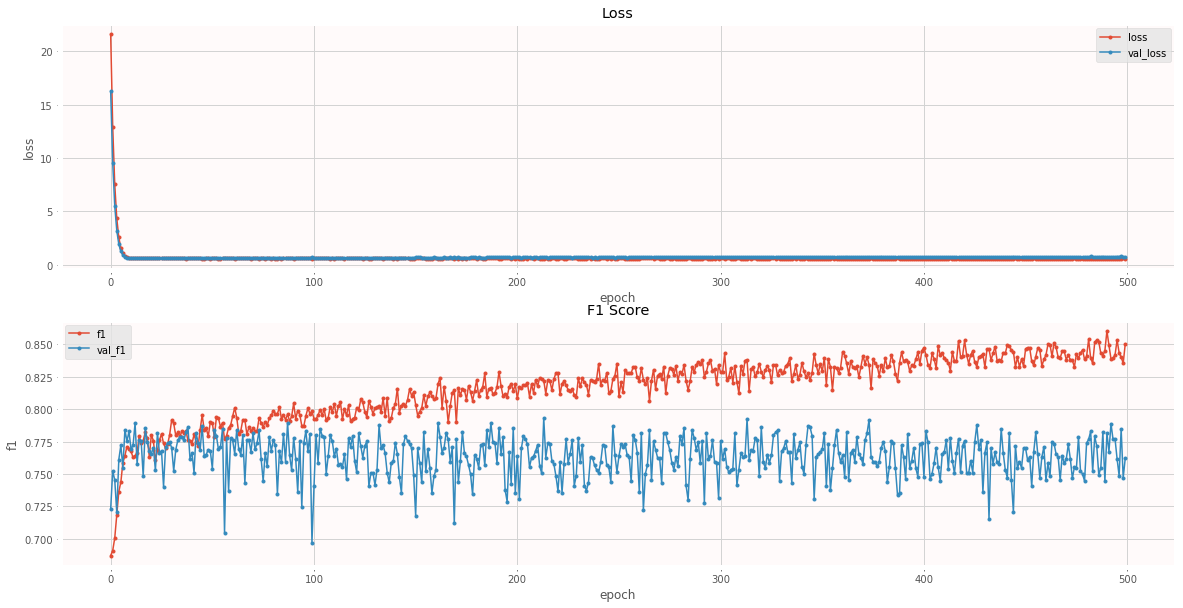

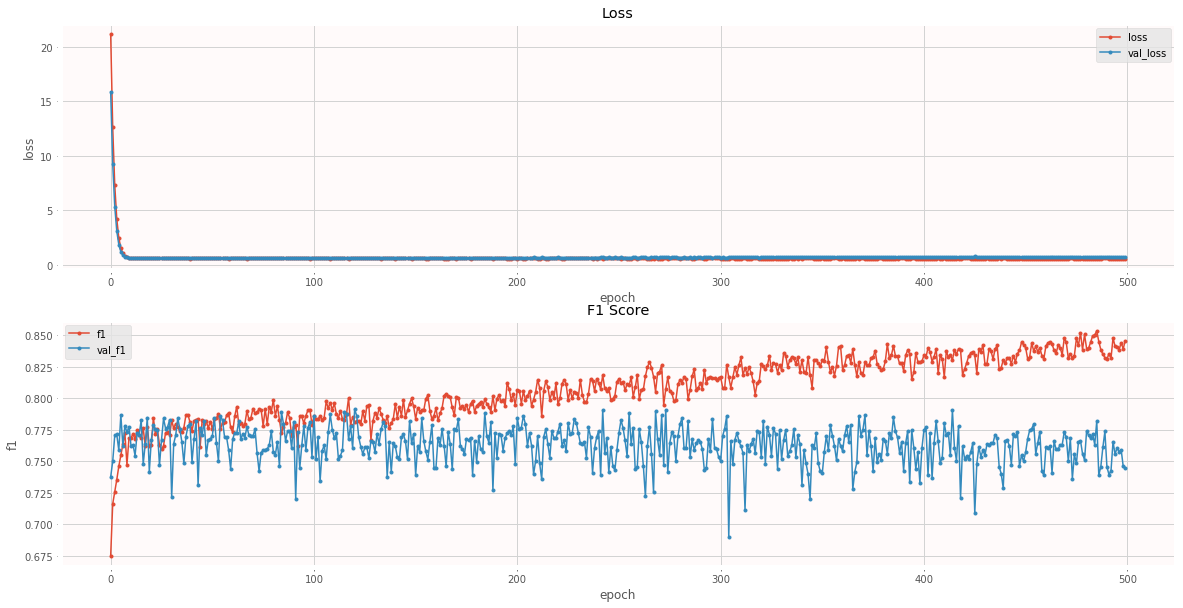

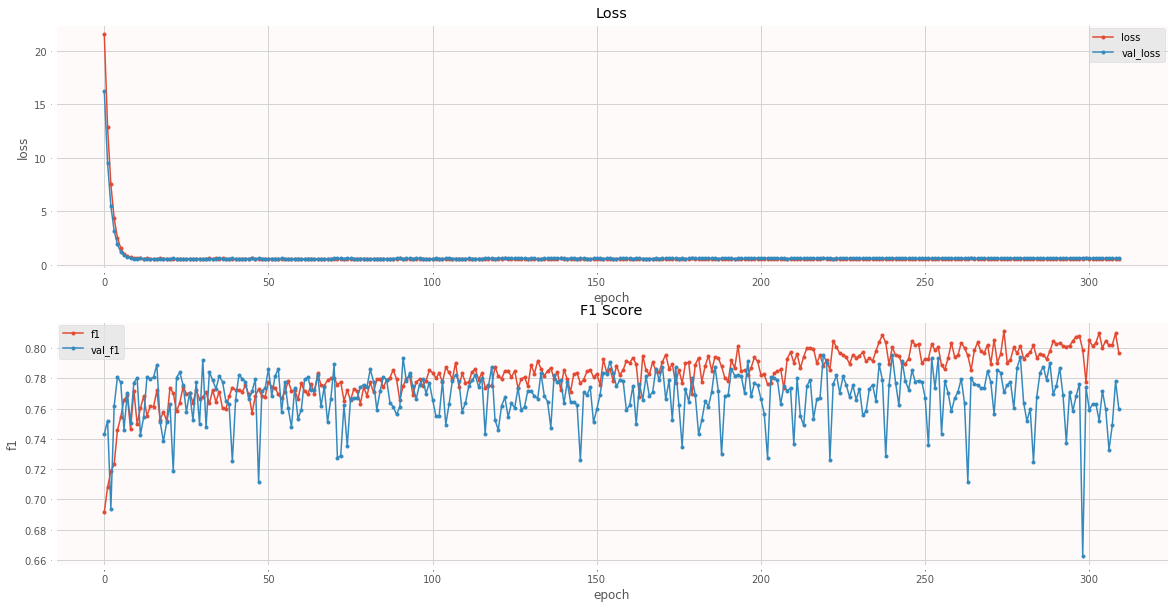

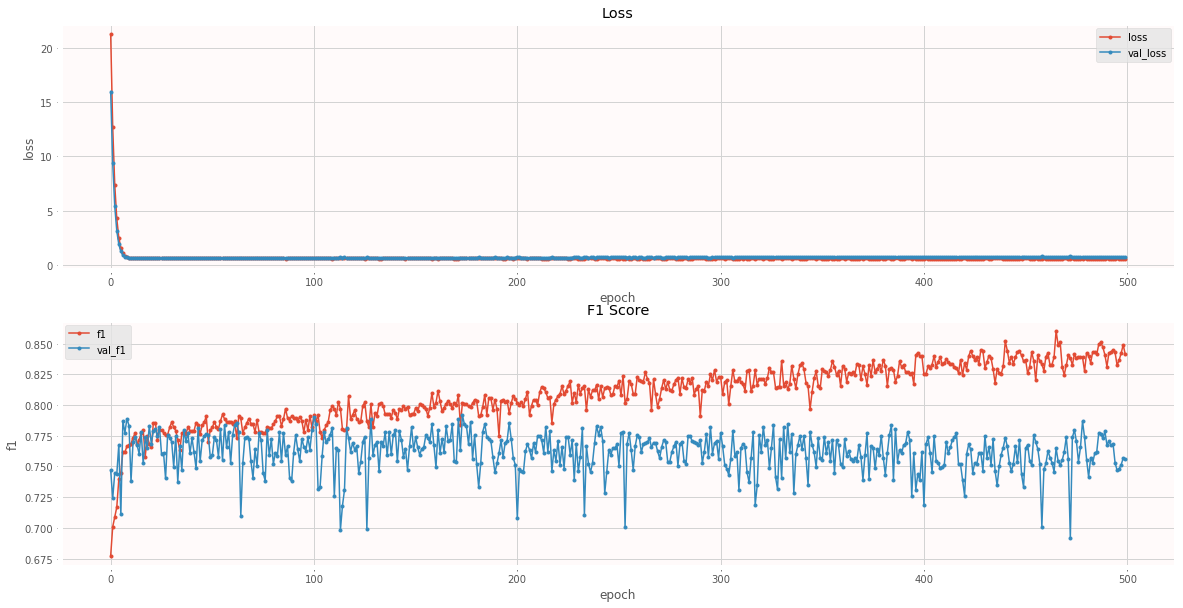

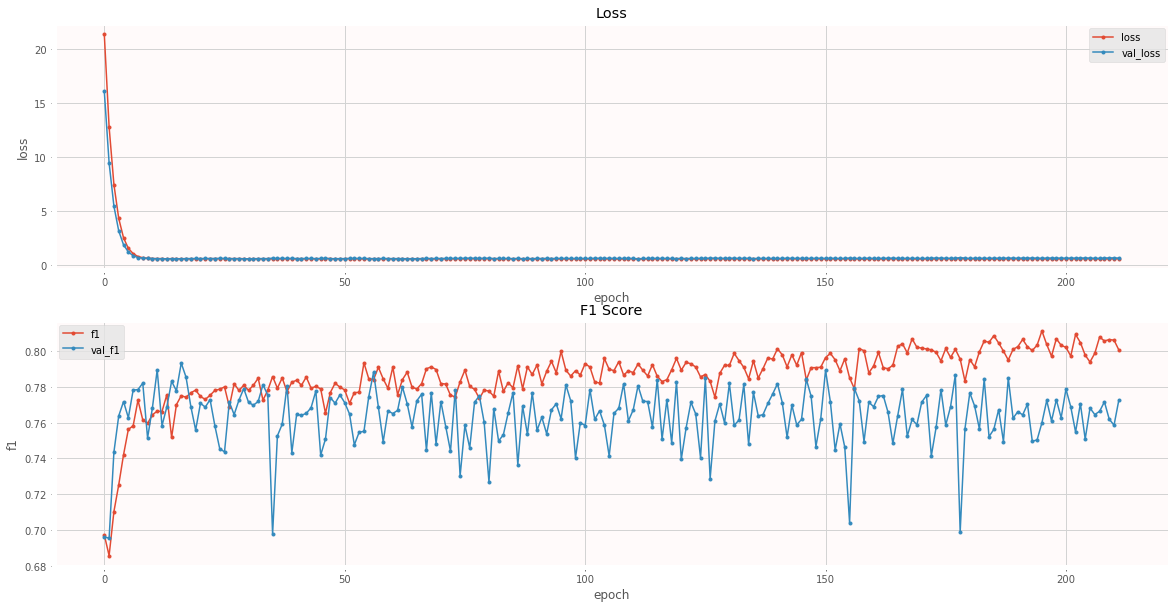

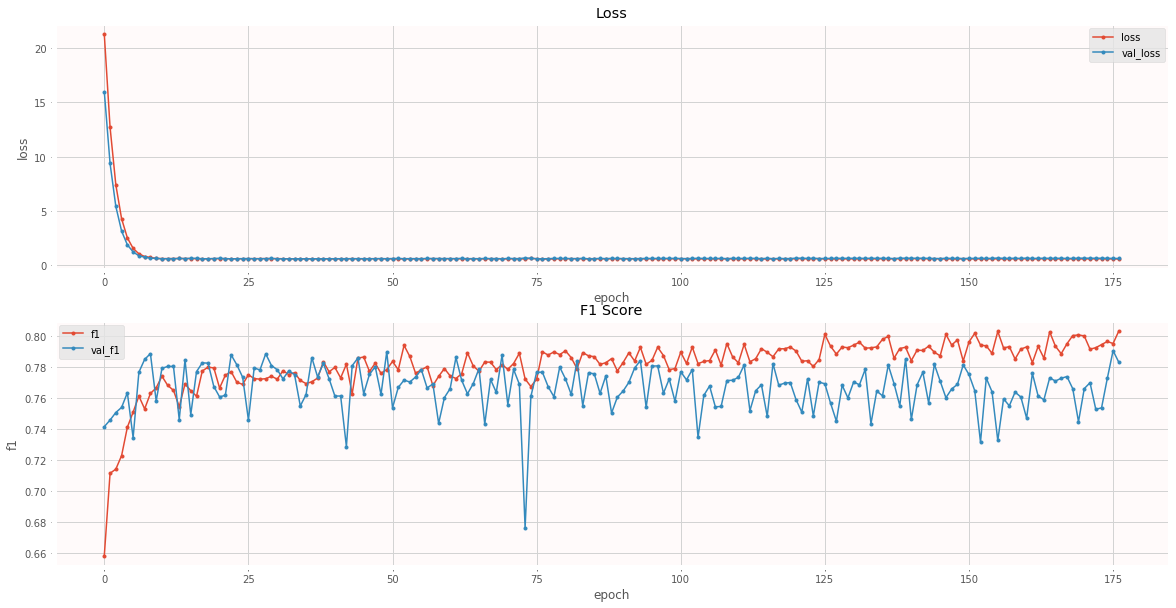

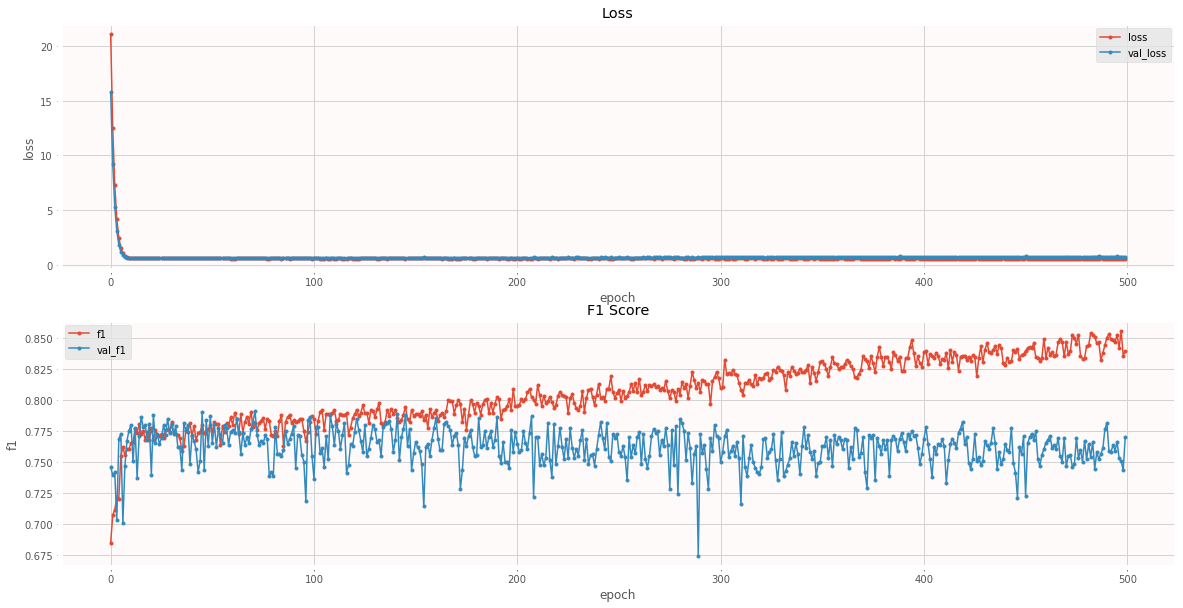

In [28]:
for i in range(len(rnn_history_list)):
    plot_history(rnn_history_list[i])

In [23]:
opt_list = ["adam", "sgd", "adadelta", "cocob"]
gru_history_list = []
gru_model_list = []
gru_performance = []

for i, optimizer in enumerate([adam, sgd, adadelta, cocob]):
    print("\nTraining model using {}.".format(opt_list[i]))
    history, model = train_gru(x_train, y_train, embedding_matrix)
    gru_history_list.append(history)
    gru_model_list.append(model)
    
    y_pred = predict(x_test, model)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    gru_performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(gru_performance)


Training model using adam.
==================== Start Training GRU ====================
Train on 5166 samples, validate on 5166 samples
Epoch 1/500
5166/5166 [==============================] - 7s 1ms/step - loss: 0.6451 - get_f1: 0.7025 - val_loss: 0.5652 - val_get_f1: 0.7670
Epoch 2/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5616 - get_f1: 0.7606 - val_loss: 0.5216 - val_get_f1: 0.7800
Epoch 3/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5354 - get_f1: 0.7838 - val_loss: 0.5020 - val_get_f1: 0.7911
Epoch 4/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5126 - get_f1: 0.7909 - val_loss: 0.4887 - val_get_f1: 0.7997
Epoch 5/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.4979 - get_f1: 0.7965 - val_loss: 0.4872 - val_get_f1: 0.8056
Epoch 6/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.4908 - get_f1: 0.7920 - val_loss: 0.4790 - val_get_f1: 0.8008
Epoch 7/500
5166/

Epoch 58/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1676 - get_f1: 0.9481 - val_loss: 0.7618 - val_get_f1: 0.8092
Epoch 59/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1586 - get_f1: 0.9509 - val_loss: 0.7609 - val_get_f1: 0.8090get_f1
Epoch 60/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1659 - get_f1: 0.9469 - val_loss: 0.7554 - val_get_f1: 0.8059
Epoch 61/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1566 - get_f1: 0.9499 - val_loss: 0.7992 - val_get_f1: 0.8084
Epoch 62/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1573 - get_f1: 0.9480 - val_loss: 0.7692 - val_get_f1: 0.8078
Epoch 63/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1487 - get_f1: 0.9527 - val_loss: 0.8018 - val_get_f1: 0.8082
Epoch 64/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1547 - get_f1: 0.9533 - val_loss: 0.8383 - val_get_f1: 0.8048


5166/5166 [==============================] - 6s 1ms/step - loss: 0.1060 - get_f1: 0.9664 - val_loss: 1.0261 - val_get_f1: 0.8086
Epoch 116/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1214 - get_f1: 0.9647 - val_loss: 0.9121 - val_get_f1: 0.8107
Epoch 117/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1129 - get_f1: 0.9619 - val_loss: 0.9384 - val_get_f1: 0.8047
Epoch 118/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1112 - get_f1: 0.9630 - val_loss: 0.9145 - val_get_f1: 0.8076
Epoch 119/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1079 - get_f1: 0.9651 - val_loss: 0.9789 - val_get_f1: 0.8030
Epoch 120/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1092 - get_f1: 0.9645 - val_loss: 0.9318 - val_get_f1: 0.8137
Epoch 121/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1082 - get_f1: 0.9609 - val_loss: 0.9691 - val_get_f1: 0.8077
Epoch 122/500

5166/5166 [==============================] - 6s 1ms/step - loss: 0.0940 - get_f1: 0.9684 - val_loss: 1.0363 - val_get_f1: 0.8076
Epoch 173/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0898 - get_f1: 0.9704 - val_loss: 1.0145 - val_get_f1: 0.8163
Epoch 174/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0894 - get_f1: 0.9706 - val_loss: 1.0317 - val_get_f1: 0.8072
Epoch 175/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0931 - get_f1: 0.9715 - val_loss: 1.0281 - val_get_f1: 0.8094
Epoch 176/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0897 - get_f1: 0.9737 - val_loss: 1.0395 - val_get_f1: 0.8051
Epoch 177/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0938 - get_f1: 0.9746 - val_loss: 1.0196 - val_get_f1: 0.8105
Epoch 178/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0854 - get_f1: 0.9736 - val_loss: 1.0141 - val_get_f1: 0.8082
Epoch 179/500

5166/5166 [==============================] - 6s 1ms/step - loss: 0.4452 - get_f1: 0.8224 - val_loss: 0.4769 - val_get_f1: 0.8068
Epoch 12/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.4401 - get_f1: 0.8271 - val_loss: 0.4775 - val_get_f1: 0.8111
Epoch 13/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.4195 - get_f1: 0.8352 - val_loss: 0.4920 - val_get_f1: 0.8149
Epoch 14/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.4173 - get_f1: 0.8421 - val_loss: 0.4854 - val_get_f1: 0.8158
Epoch 15/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.4142 - get_f1: 0.8368 - val_loss: 0.4911 - val_get_f1: 0.8163
Epoch 16/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.3918 - get_f1: 0.8536 - val_loss: 0.5004 - val_get_f1: 0.8054
Epoch 17/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.3856 - get_f1: 0.8586 - val_loss: 0.4992 - val_get_f1: 0.8142
Epoch 18/500
5166/5

Epoch 69/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1485 - get_f1: 0.9543 - val_loss: 0.7838 - val_get_f1: 0.8086
Epoch 70/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1471 - get_f1: 0.9538 - val_loss: 0.7918 - val_get_f1: 0.8123
Epoch 71/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1388 - get_f1: 0.9598 - val_loss: 0.8013 - val_get_f1: 0.8086
Epoch 72/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1421 - get_f1: 0.9533 - val_loss: 0.7741 - val_get_f1: 0.8078
Epoch 73/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1374 - get_f1: 0.9575 - val_loss: 0.8157 - val_get_f1: 0.8135
Epoch 74/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1425 - get_f1: 0.9579 - val_loss: 0.7938 - val_get_f1: 0.8090
Epoch 75/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1348 - get_f1: 0.9591 - val_loss: 0.7893 - val_get_f1: 0.8073
Epoch 

5166/5166 [==============================] - 6s 1ms/step - loss: 0.0918 - get_f1: 0.9712 - val_loss: 0.9804 - val_get_f1: 0.8088
Epoch 127/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1000 - get_f1: 0.9670 - val_loss: 0.9468 - val_get_f1: 0.8168
Epoch 128/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0951 - get_f1: 0.9682 - val_loss: 0.9765 - val_get_f1: 0.8103
Epoch 129/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0987 - get_f1: 0.9695 - val_loss: 0.9236 - val_get_f1: 0.8179
Epoch 130/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0960 - get_f1: 0.9676 - val_loss: 0.9792 - val_get_f1: 0.8064
Epoch 131/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0930 - get_f1: 0.9689 - val_loss: 0.9425 - val_get_f1: 0.8150
Epoch 132/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1004 - get_f1: 0.9661 - val_loss: 0.9532 - val_get_f1: 0.8114
Epoch 133/500

5166/5166 [==============================] - 6s 1ms/step - loss: 0.0881 - get_f1: 0.9713 - val_loss: 1.0501 - val_get_f1: 0.7989
Epoch 184/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0828 - get_f1: 0.9747 - val_loss: 1.0314 - val_get_f1: 0.8069
Epoch 185/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0867 - get_f1: 0.9707 - val_loss: 1.0506 - val_get_f1: 0.8045
Epoch 186/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0908 - get_f1: 0.9724 - val_loss: 0.9991 - val_get_f1: 0.8129
Confusion Matrix: 
 [[ 796  277]
 [ 288 1223]]

Training model using adadelta.
==================== Start Training GRU ====================
Train on 5166 samples, validate on 5166 samples
Epoch 1/500
5166/5166 [==============================] - 8s 1ms/step - loss: 0.6417 - get_f1: 0.7111 - val_loss: 0.5635 - val_get_f1: 0.7556
Epoch 2/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5675 - get_f1: 0.7555 - val_loss: 

5166/5166 [==============================] - 6s 1ms/step - loss: 0.1801 - get_f1: 0.9414 - val_loss: 0.7069 - val_get_f1: 0.8177
Epoch 54/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1686 - get_f1: 0.9466 - val_loss: 0.7488 - val_get_f1: 0.8082
Epoch 55/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1690 - get_f1: 0.9445 - val_loss: 0.7287 - val_get_f1: 0.8115
Epoch 56/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1766 - get_f1: 0.9454 - val_loss: 0.7093 - val_get_f1: 0.8156
Epoch 57/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1652 - get_f1: 0.9484 - val_loss: 0.7208 - val_get_f1: 0.8158
Epoch 58/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1539 - get_f1: 0.9509 - val_loss: 0.7859 - val_get_f1: 0.8088
Epoch 59/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1638 - get_f1: 0.9479 - val_loss: 0.7264 - val_get_f1: 0.8151
Epoch 60/500
5166/5

Epoch 111/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1074 - get_f1: 0.9675 - val_loss: 0.9360 - val_get_f1: 0.8125
Epoch 112/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1073 - get_f1: 0.9686 - val_loss: 0.9711 - val_get_f1: 0.8091
Epoch 113/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1083 - get_f1: 0.9653 - val_loss: 0.9351 - val_get_f1: 0.8045
Epoch 114/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1125 - get_f1: 0.9679 - val_loss: 0.9121 - val_get_f1: 0.8092
Epoch 115/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1124 - get_f1: 0.9673 - val_loss: 0.9086 - val_get_f1: 0.8053
Epoch 116/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1086 - get_f1: 0.9677 - val_loss: 0.9040 - val_get_f1: 0.8127
Epoch 117/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1095 - get_f1: 0.9658 - val_loss: 0.9074 - val_get_f1: 0.8187

5166/5166 [==============================] - 6s 1ms/step - loss: 0.0852 - get_f1: 0.9713 - val_loss: 1.0314 - val_get_f1: 0.8120
Epoch 169/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0880 - get_f1: 0.9725 - val_loss: 0.9865 - val_get_f1: 0.8180
Epoch 170/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0858 - get_f1: 0.9711 - val_loss: 1.0152 - val_get_f1: 0.8151
Epoch 171/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0884 - get_f1: 0.9716 - val_loss: 0.9628 - val_get_f1: 0.8111
Epoch 172/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0930 - get_f1: 0.9721 - val_loss: 1.0033 - val_get_f1: 0.8150
Epoch 173/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0862 - get_f1: 0.9744 - val_loss: 0.9848 - val_get_f1: 0.8103
Epoch 174/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0861 - get_f1: 0.9732 - val_loss: 1.0111 - val_get_f1: 0.8113
Epoch 175/500

5166/5166 [==============================] - 6s 1ms/step - loss: 0.0832 - get_f1: 0.9708 - val_loss: 1.0316 - val_get_f1: 0.8159
Epoch 226/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0778 - get_f1: 0.9768 - val_loss: 1.0421 - val_get_f1: 0.8170
Epoch 227/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0785 - get_f1: 0.9737 - val_loss: 1.0490 - val_get_f1: 0.8177
Epoch 228/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0801 - get_f1: 0.9748 - val_loss: 1.0329 - val_get_f1: 0.8175
Epoch 229/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0790 - get_f1: 0.9743 - val_loss: 1.0501 - val_get_f1: 0.8114
Epoch 230/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0756 - get_f1: 0.9766 - val_loss: 1.0501 - val_get_f1: 0.8127 - loss: 0
Epoch 231/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.0760 - get_f1: 0.9740 - val_loss: 1.0121 - val_get_f1: 0.8168
Epo

5166/5166 [==============================] - 6s 1ms/step - loss: 0.1956 - get_f1: 0.9393 - val_loss: 0.7187 - val_get_f1: 0.8140
Epoch 48/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1922 - get_f1: 0.9361 - val_loss: 0.7044 - val_get_f1: 0.8027
Epoch 49/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1779 - get_f1: 0.9452 - val_loss: 0.7452 - val_get_f1: 0.8108
Epoch 50/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1944 - get_f1: 0.9372 - val_loss: 0.7076 - val_get_f1: 0.8113
Epoch 51/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1838 - get_f1: 0.9407 - val_loss: 0.7074 - val_get_f1: 0.8045
Epoch 52/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1742 - get_f1: 0.9455 - val_loss: 0.7573 - val_get_f1: 0.8107
Epoch 53/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1787 - get_f1: 0.9397 - val_loss: 0.7729 - val_get_f1: 0.8082
Epoch 54/500
5166/5

Epoch 105/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1031 - get_f1: 0.9677 - val_loss: 0.9191 - val_get_f1: 0.8070
Epoch 106/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1085 - get_f1: 0.9667 - val_loss: 0.9775 - val_get_f1: 0.8043
Epoch 107/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1030 - get_f1: 0.9679 - val_loss: 0.9745 - val_get_f1: 0.8047
Epoch 108/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1100 - get_f1: 0.9657 - val_loss: 0.9171 - val_get_f1: 0.8070
Epoch 109/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1048 - get_f1: 0.9667 - val_loss: 0.9353 - val_get_f1: 0.8079
Epoch 110/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1151 - get_f1: 0.9621 - val_loss: 0.9277 - val_get_f1: 0.8083
Epoch 111/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.1038 - get_f1: 0.9677 - val_loss: 0.9180 - val_get_f1: 0.8094

5166/5166 [==============================] - 6s 1ms/step - loss: 0.0930 - get_f1: 0.9719 - val_loss: 1.0491 - val_get_f1: 0.8065
Confusion Matrix: 
 [[ 825  314]
 [ 259 1186]]
[[0.7755, 0.806], [0.7813, 0.8124], [0.7872, 0.8158], [0.7783, 0.8054]]


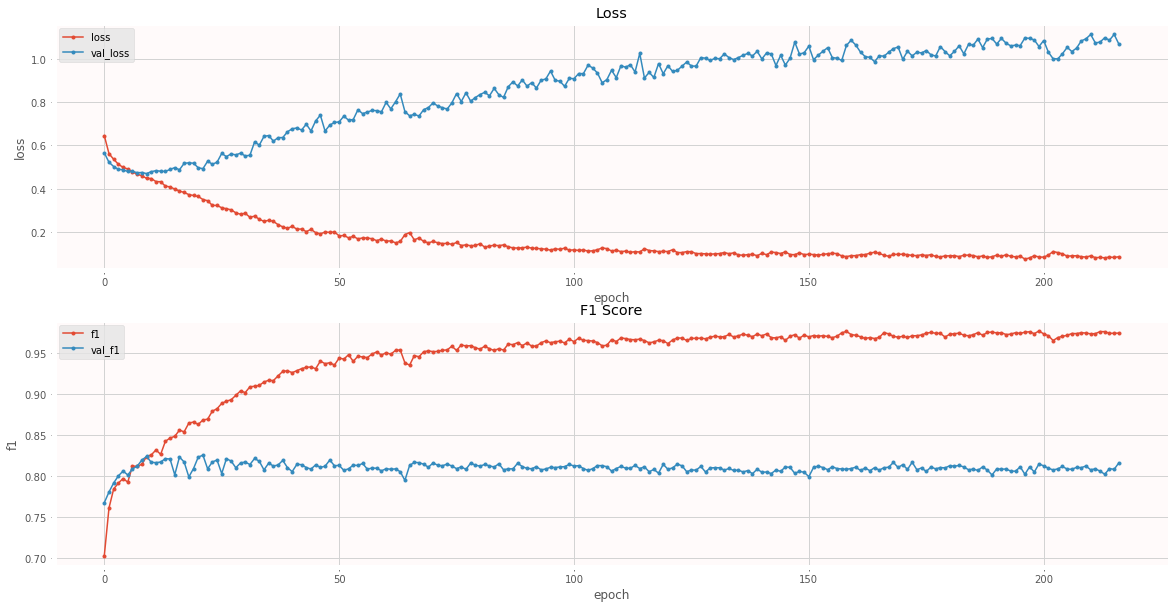

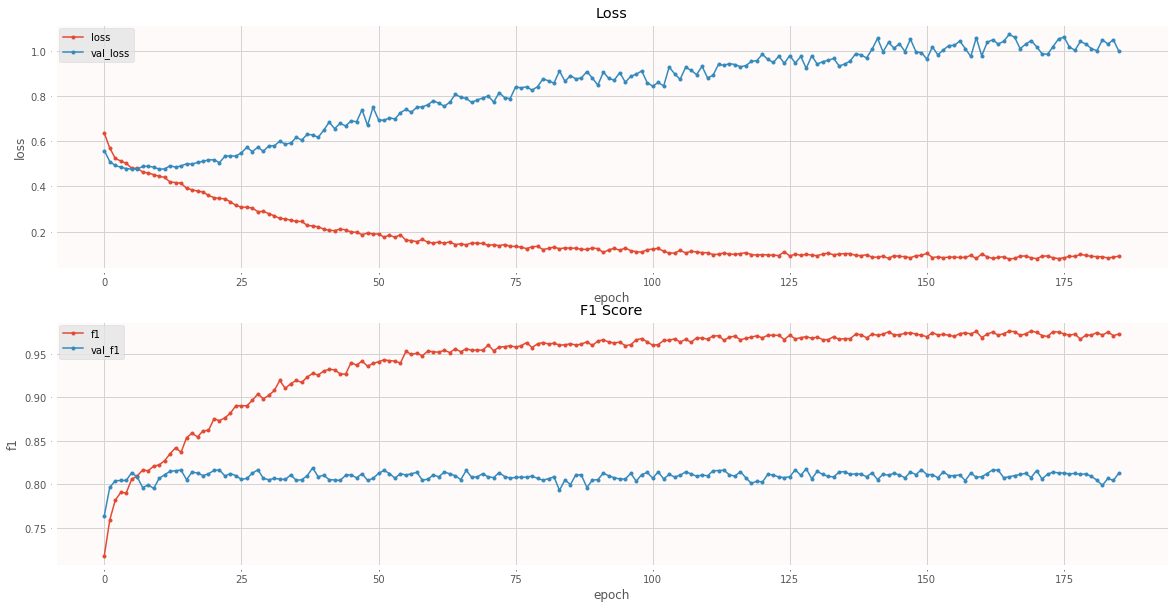

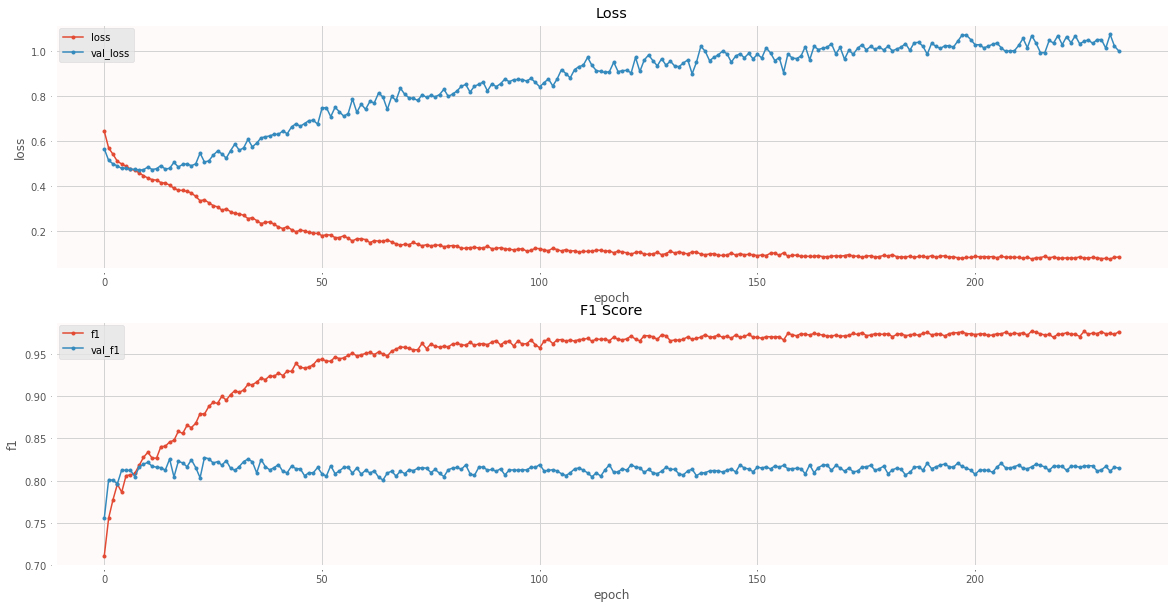

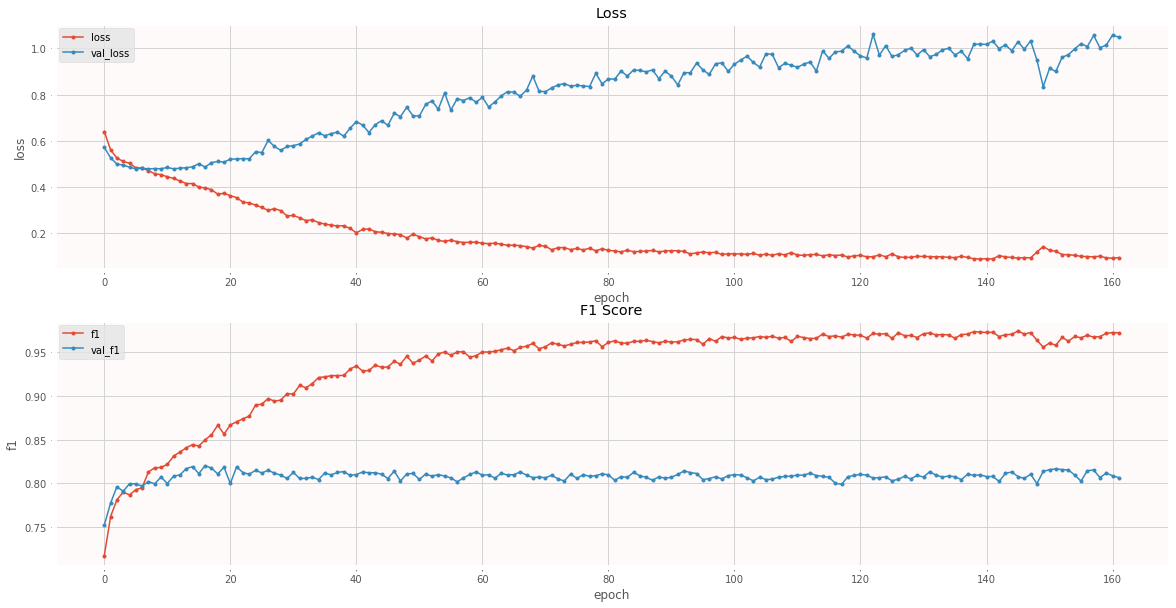

In [24]:
for i in range(len(gru_history_list)):
    plot_history(gru_history_list[i])

In [28]:
opt_list = ["adam", "sgd", "adagrad", "adadelta", "rmsprop", "nadam", "cocob"]
lstm_history_list = []
lstm_model_list = []
lstm_performance = []

for i, optimizer in enumerate([adam, sgd, adagrad, adadelta, rmsprop, nadam, cocob]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_lstm(x_train, y_train, embedding_matrix)
    lstm_history_list.append(history)
    lstm_model_list.append(model)
    
    y_pred = predict(x_test, model)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    lstm_performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(lstm_performance)

Training model using adam.
==================== Start Training LSTM ====================
Train on 5166 samples, validate on 5166 samples
Epoch 1/500
5166/5166 [==============================] - 5s 923us/step - loss: 176.8845 - get_f1: 0.7210 - val_loss: 114.0129 - val_get_f1: 0.7466
Epoch 2/500
5166/5166 [==============================] - 4s 781us/step - loss: 79.4289 - get_f1: 0.7412 - val_loss: 47.6447 - val_get_f1: 0.7701
Epoch 3/500
5166/5166 [==============================] - 4s 788us/step - loss: 32.1078 - get_f1: 0.7431 - val_loss: 18.3565 - val_get_f1: 0.7410
Epoch 4/500
5166/5166 [==============================] - 4s 800us/step - loss: 12.0723 - get_f1: 0.7529 - val_loss: 6.6884 - val_get_f1: 0.7442
Epoch 5/500
5166/5166 [==============================] - 4s 787us/step - loss: 4.4155 - get_f1: 0.7373 - val_loss: 2.5204 - val_get_f1: 0.7778
Epoch 6/500
5166/5166 [==============================] - 4s 803us/step - loss: 1.7709 - get_f1: 0.7411 - val_loss: 1.1469 - val_get_f1: 0.7

Epoch 57/500
5166/5166 [==============================] - 4s 767us/step - loss: 0.5746 - get_f1: 0.7648 - val_loss: 0.5569 - val_get_f1: 0.7641
Epoch 58/500
5166/5166 [==============================] - 4s 765us/step - loss: 0.5697 - get_f1: 0.7748 - val_loss: 0.5647 - val_get_f1: 0.7410
Epoch 59/500
5166/5166 [==============================] - 4s 781us/step - loss: 0.5643 - get_f1: 0.7683 - val_loss: 0.5682 - val_get_f1: 0.7710
Epoch 60/500
5166/5166 [==============================] - 4s 777us/step - loss: 0.5632 - get_f1: 0.7722 - val_loss: 0.5487 - val_get_f1: 0.7646
Epoch 61/500
5166/5166 [==============================] - 4s 782us/step - loss: 0.5622 - get_f1: 0.7592 - val_loss: 0.5552 - val_get_f1: 0.7800
Epoch 62/500
5166/5166 [==============================] - 4s 778us/step - loss: 0.5731 - get_f1: 0.7680 - val_loss: 0.5531 - val_get_f1: 0.7878
Epoch 63/500
5166/5166 [==============================] - 4s 777us/step - loss: 0.5635 - get_f1: 0.7663 - val_loss: 0.5565 - val_get_f1:

5166/5166 [==============================] - 4s 763us/step - loss: 0.7826 - get_f1: 0.6908 - val_loss: 0.7361 - val_get_f1: 0.7539
Epoch 29/500
5166/5166 [==============================] - 4s 767us/step - loss: 0.7016 - get_f1: 0.7343 - val_loss: 0.6491 - val_get_f1: 0.7720
Epoch 30/500
5166/5166 [==============================] - 4s 765us/step - loss: 0.6605 - get_f1: 0.7472 - val_loss: 0.6151 - val_get_f1: 0.7717
Epoch 31/500
5166/5166 [==============================] - 4s 768us/step - loss: 0.6380 - get_f1: 0.7520 - val_loss: 0.6234 - val_get_f1: 0.7559
Epoch 32/500
5166/5166 [==============================] - 4s 764us/step - loss: 0.6151 - get_f1: 0.7559 - val_loss: 0.6403 - val_get_f1: 0.6820
Confusion Matrix: 
 [[954 684]
 [130 816]]
Training model using adagrad.
==================== Start Training LSTM ====================
Train on 5166 samples, validate on 5166 samples
Epoch 1/500
5166/5166 [==============================] - 5s 899us/step - loss: 176.9776 - get_f1: 0.7296 - val

Epoch 52/500
5166/5166 [==============================] - 4s 783us/step - loss: 0.5826 - get_f1: 0.7538 - val_loss: 0.5671 - val_get_f1: 0.7765
Epoch 53/500
5166/5166 [==============================] - 4s 780us/step - loss: 0.5996 - get_f1: 0.7416 - val_loss: 0.5864 - val_get_f1: 0.7748
Epoch 54/500
5166/5166 [==============================] - 4s 783us/step - loss: 0.6074 - get_f1: 0.7674 - val_loss: 0.5901 - val_get_f1: 0.7928
Epoch 55/500
5166/5166 [==============================] - 4s 781us/step - loss: 0.5855 - get_f1: 0.7665 - val_loss: 0.5614 - val_get_f1: 0.7574
Epoch 56/500
5166/5166 [==============================] - 4s 781us/step - loss: 0.5772 - get_f1: 0.7681 - val_loss: 0.5568 - val_get_f1: 0.7817
Epoch 57/500
5166/5166 [==============================] - 4s 778us/step - loss: 0.5915 - get_f1: 0.7738 - val_loss: 0.5760 - val_get_f1: 0.7736
Epoch 58/500
5166/5166 [==============================] - 4s 772us/step - loss: 0.5844 - get_f1: 0.7689 - val_loss: 0.5693 - val_get_f1:

5166/5166 [==============================] - 4s 777us/step - loss: 0.5874 - get_f1: 0.7557 - val_loss: 0.5882 - val_get_f1: 0.7830
Epoch 39/500
5166/5166 [==============================] - 4s 778us/step - loss: 0.5922 - get_f1: 0.7535 - val_loss: 0.5696 - val_get_f1: 0.7828
Epoch 40/500
5166/5166 [==============================] - 4s 783us/step - loss: 0.5980 - get_f1: 0.7694 - val_loss: 0.6042 - val_get_f1: 0.7655
Epoch 41/500
5166/5166 [==============================] - 4s 776us/step - loss: 0.6177 - get_f1: 0.7568 - val_loss: 0.5888 - val_get_f1: 0.7801
Epoch 42/500
5166/5166 [==============================] - 4s 780us/step - loss: 0.5953 - get_f1: 0.7635 - val_loss: 0.5688 - val_get_f1: 0.7580
Epoch 43/500
5166/5166 [==============================] - 4s 777us/step - loss: 0.5709 - get_f1: 0.7741 - val_loss: 0.5592 - val_get_f1: 0.7870
Epoch 44/500
5166/5166 [==============================] - 4s 775us/step - loss: 0.5874 - get_f1: 0.7716 - val_loss: 0.5703 - val_get_f1: 0.7593
Epoch

Epoch 95/500
5166/5166 [==============================] - 4s 764us/step - loss: 0.5521 - get_f1: 0.7726 - val_loss: 0.5607 - val_get_f1: 0.7952
Epoch 96/500
5166/5166 [==============================] - 4s 775us/step - loss: 0.5616 - get_f1: 0.7804 - val_loss: 0.5493 - val_get_f1: 0.7828
Epoch 97/500
5166/5166 [==============================] - 4s 773us/step - loss: 0.5639 - get_f1: 0.7846 - val_loss: 0.5583 - val_get_f1: 0.7714
Epoch 98/500
5166/5166 [==============================] - 4s 764us/step - loss: 0.5596 - get_f1: 0.7790 - val_loss: 0.5621 - val_get_f1: 0.7690
Epoch 99/500
5166/5166 [==============================] - 4s 777us/step - loss: 0.5537 - get_f1: 0.7843 - val_loss: 0.5751 - val_get_f1: 0.7370
Epoch 100/500
5166/5166 [==============================] - 4s 776us/step - loss: 0.5588 - get_f1: 0.7746 - val_loss: 0.5586 - val_get_f1: 0.7798
Epoch 101/500
5166/5166 [==============================] - 4s 766us/step - loss: 0.5560 - get_f1: 0.7812 - val_loss: 0.5583 - val_get_f

5166/5166 [==============================] - 4s 754us/step - loss: 0.5767 - get_f1: 0.7795 - val_loss: 0.5632 - val_get_f1: 0.7780
Epoch 38/500
5166/5166 [==============================] - 4s 759us/step - loss: 0.5795 - get_f1: 0.7720 - val_loss: 0.5603 - val_get_f1: 0.7730
Epoch 39/500
5166/5166 [==============================] - 4s 743us/step - loss: 0.5836 - get_f1: 0.7783 - val_loss: 0.5819 - val_get_f1: 0.7834
Epoch 40/500
5166/5166 [==============================] - 4s 751us/step - loss: 0.6039 - get_f1: 0.7764 - val_loss: 0.5837 - val_get_f1: 0.7792
Epoch 41/500
5166/5166 [==============================] - 4s 751us/step - loss: 0.5935 - get_f1: 0.7653 - val_loss: 0.5624 - val_get_f1: 0.7726
Epoch 42/500
5166/5166 [==============================] - 4s 747us/step - loss: 0.5788 - get_f1: 0.7657 - val_loss: 0.5585 - val_get_f1: 0.7903
Epoch 43/500
5166/5166 [==============================] - 4s 755us/step - loss: 0.5941 - get_f1: 0.7675 - val_loss: 0.5615 - val_get_f1: 0.7810
Epoch

Epoch 94/500
5166/5166 [==============================] - 4s 757us/step - loss: 0.5556 - get_f1: 0.7786 - val_loss: 0.5932 - val_get_f1: 0.7422
Epoch 95/500
5166/5166 [==============================] - 4s 766us/step - loss: 0.5744 - get_f1: 0.7817 - val_loss: 0.5779 - val_get_f1: 0.7669
Epoch 96/500
5166/5166 [==============================] - 4s 760us/step - loss: 0.5607 - get_f1: 0.7805 - val_loss: 0.5454 - val_get_f1: 0.8014
Epoch 97/500
5166/5166 [==============================] - 4s 761us/step - loss: 0.5599 - get_f1: 0.7837 - val_loss: 0.5713 - val_get_f1: 0.7663
Epoch 98/500
5166/5166 [==============================] - 4s 764us/step - loss: 0.5586 - get_f1: 0.7877 - val_loss: 0.5505 - val_get_f1: 0.8042
Epoch 99/500
5166/5166 [==============================] - 4s 762us/step - loss: 0.5549 - get_f1: 0.7897 - val_loss: 0.5365 - val_get_f1: 0.7930
Epoch 100/500
5166/5166 [==============================] - 4s 767us/step - loss: 0.5550 - get_f1: 0.7850 - val_loss: 0.5449 - val_get_f1

5166/5166 [==============================] - 4s 754us/step - loss: 0.5886 - get_f1: 0.7695 - val_loss: 0.5792 - val_get_f1: 0.7125
Epoch 49/500
5166/5166 [==============================] - 4s 765us/step - loss: 0.5921 - get_f1: 0.7478 - val_loss: 0.5734 - val_get_f1: 0.7960
Epoch 50/500
5166/5166 [==============================] - 4s 753us/step - loss: 0.6022 - get_f1: 0.7622 - val_loss: 0.5733 - val_get_f1: 0.7838
Epoch 51/500
5166/5166 [==============================] - 4s 736us/step - loss: 0.7256 - get_f1: 0.7025 - val_loss: 0.8182 - val_get_f1: 0.7440
Epoch 52/500
5166/5166 [==============================] - 4s 755us/step - loss: 0.7032 - get_f1: 0.7327 - val_loss: 0.7028 - val_get_f1: 0.6679
Epoch 53/500
5166/5166 [==============================] - 4s 741us/step - loss: 0.6464 - get_f1: 0.7492 - val_loss: 0.6022 - val_get_f1: 0.7831
Epoch 54/500
5166/5166 [==============================] - 4s 749us/step - loss: 0.6050 - get_f1: 0.7561 - val_loss: 0.5676 - val_get_f1: 0.7726
Epoch

Epoch 105/500
5166/5166 [==============================] - 4s 750us/step - loss: 0.5598 - get_f1: 0.7830 - val_loss: 0.5481 - val_get_f1: 0.8025
Epoch 106/500
5166/5166 [==============================] - 4s 738us/step - loss: 0.5558 - get_f1: 0.7840 - val_loss: 0.5702 - val_get_f1: 0.7437
Epoch 107/500
5166/5166 [==============================] - 4s 745us/step - loss: 0.5536 - get_f1: 0.7850 - val_loss: 0.5450 - val_get_f1: 0.8004
Epoch 108/500
5166/5166 [==============================] - 4s 750us/step - loss: 0.5661 - get_f1: 0.7814 - val_loss: 0.5520 - val_get_f1: 0.7967
Epoch 109/500
5166/5166 [==============================] - 4s 745us/step - loss: 0.5567 - get_f1: 0.7874 - val_loss: 0.5458 - val_get_f1: 0.7982
Epoch 110/500
5166/5166 [==============================] - 4s 739us/step - loss: 0.5586 - get_f1: 0.7843 - val_loss: 0.5508 - val_get_f1: 0.7959
Epoch 111/500
5166/5166 [==============================] - 4s 752us/step - loss: 0.5562 - get_f1: 0.7922 - val_loss: 0.5560 - val_

5166/5166 [==============================] - 4s 760us/step - loss: 0.9587 - get_f1: 0.6986 - val_loss: 0.7565 - val_get_f1: 0.7597
Epoch 8/500
5166/5166 [==============================] - 4s 753us/step - loss: 0.7129 - get_f1: 0.7330 - val_loss: 0.6349 - val_get_f1: 0.7474
Epoch 9/500
5166/5166 [==============================] - 4s 767us/step - loss: 0.6225 - get_f1: 0.7577 - val_loss: 0.6079 - val_get_f1: 0.7067
Epoch 10/500
5166/5166 [==============================] - 4s 759us/step - loss: 0.6235 - get_f1: 0.7388 - val_loss: 0.6025 - val_get_f1: 0.7404
Epoch 11/500
5166/5166 [==============================] - 4s 759us/step - loss: 0.6191 - get_f1: 0.7311 - val_loss: 0.5980 - val_get_f1: 0.7492
Epoch 12/500
5166/5166 [==============================] - 4s 755us/step - loss: 0.6003 - get_f1: 0.7442 - val_loss: 0.5893 - val_get_f1: 0.7835
Epoch 13/500
5166/5166 [==============================] - 4s 748us/step - loss: 0.6105 - get_f1: 0.7372 - val_loss: 0.6051 - val_get_f1: 0.7108
Epoch 1

Epoch 64/500
5166/5166 [==============================] - 4s 748us/step - loss: 0.6189 - get_f1: 0.7661 - val_loss: 0.6313 - val_get_f1: 0.7010
Epoch 65/500
5166/5166 [==============================] - 4s 740us/step - loss: 0.6013 - get_f1: 0.7738 - val_loss: 0.5814 - val_get_f1: 0.7706
Epoch 66/500
5166/5166 [==============================] - 4s 742us/step - loss: 0.5774 - get_f1: 0.7607 - val_loss: 0.5693 - val_get_f1: 0.7443
Epoch 67/500
5166/5166 [==============================] - 4s 744us/step - loss: 0.5652 - get_f1: 0.7742 - val_loss: 0.5611 - val_get_f1: 0.7697
Epoch 68/500
5166/5166 [==============================] - 4s 745us/step - loss: 0.5581 - get_f1: 0.7769 - val_loss: 0.5727 - val_get_f1: 0.7492
Epoch 69/500
5166/5166 [==============================] - 4s 748us/step - loss: 0.5666 - get_f1: 0.7701 - val_loss: 0.5524 - val_get_f1: 0.7734
Epoch 70/500
5166/5166 [==============================] - 4s 744us/step - loss: 0.5763 - get_f1: 0.7538 - val_loss: 0.5907 - val_get_f1:

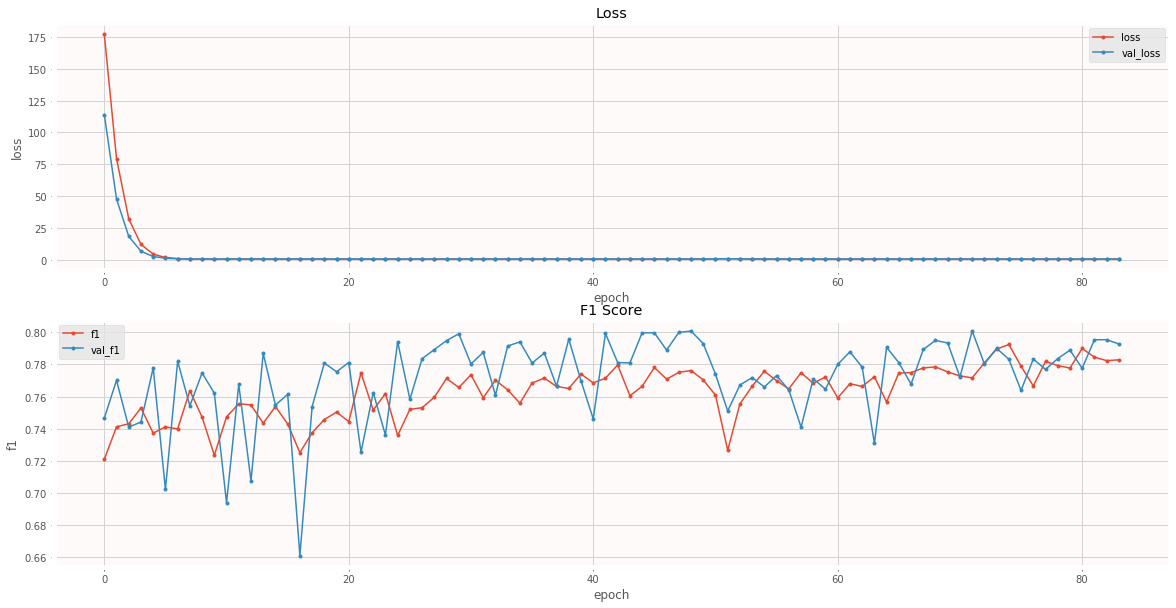

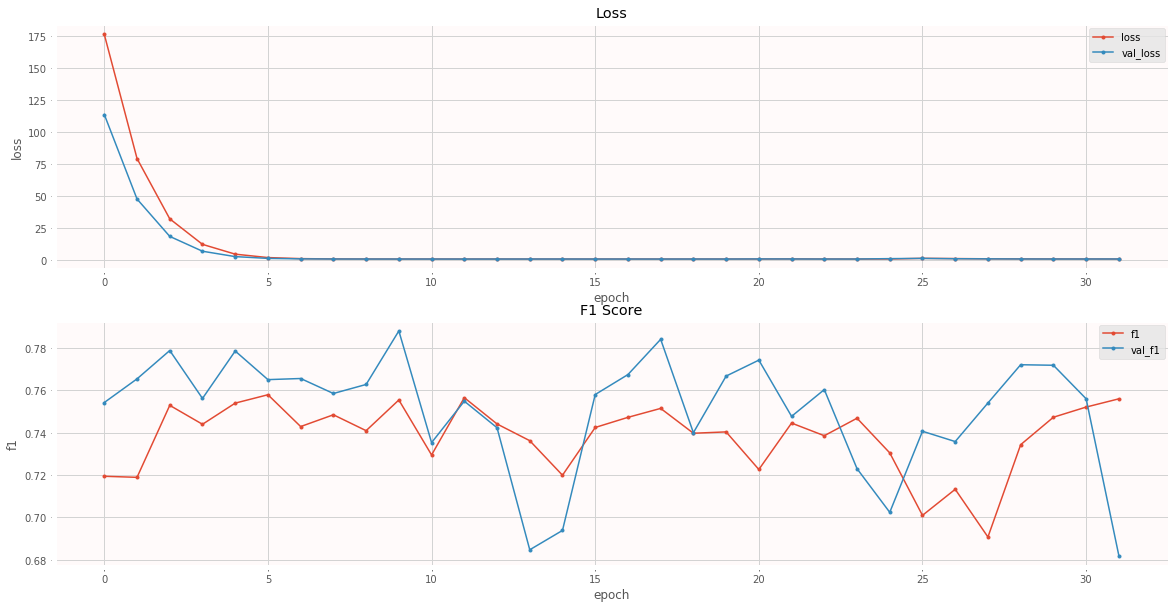

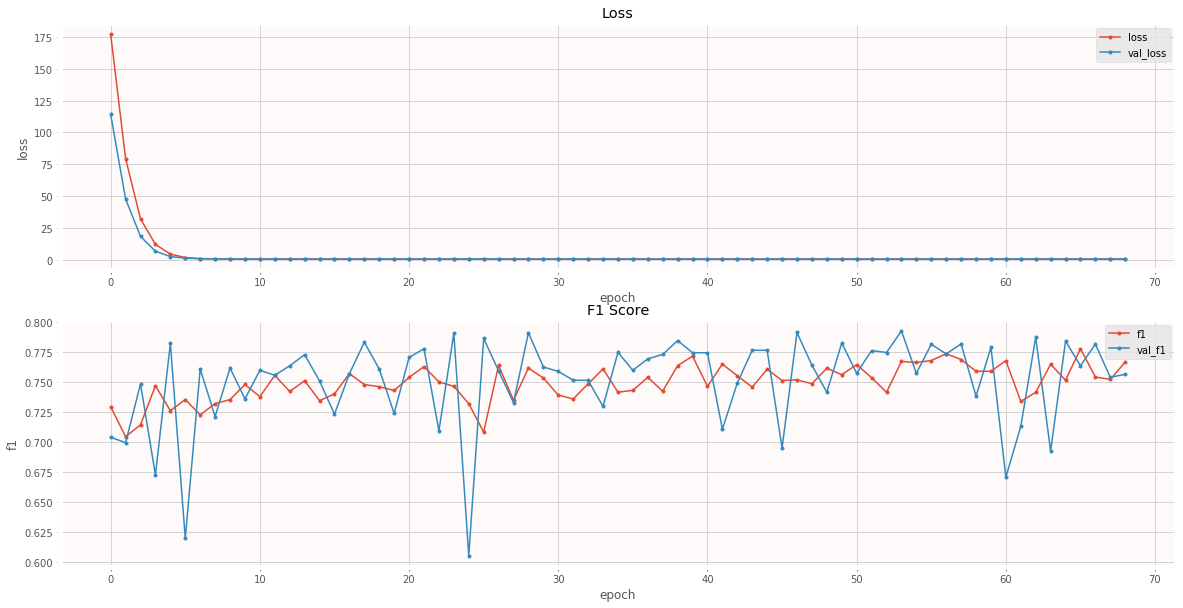

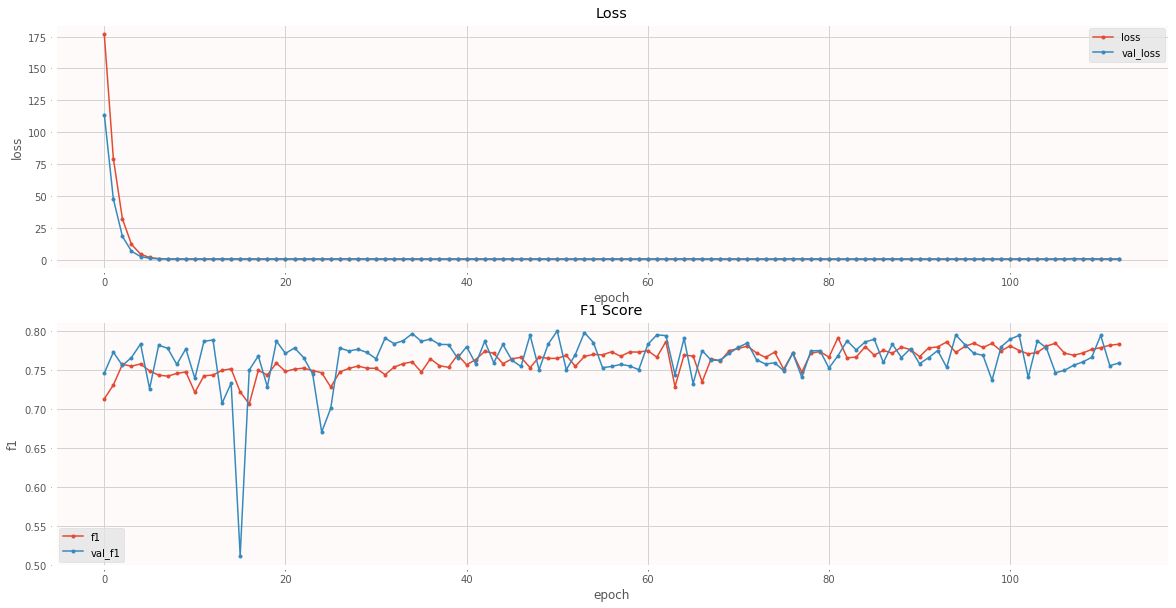

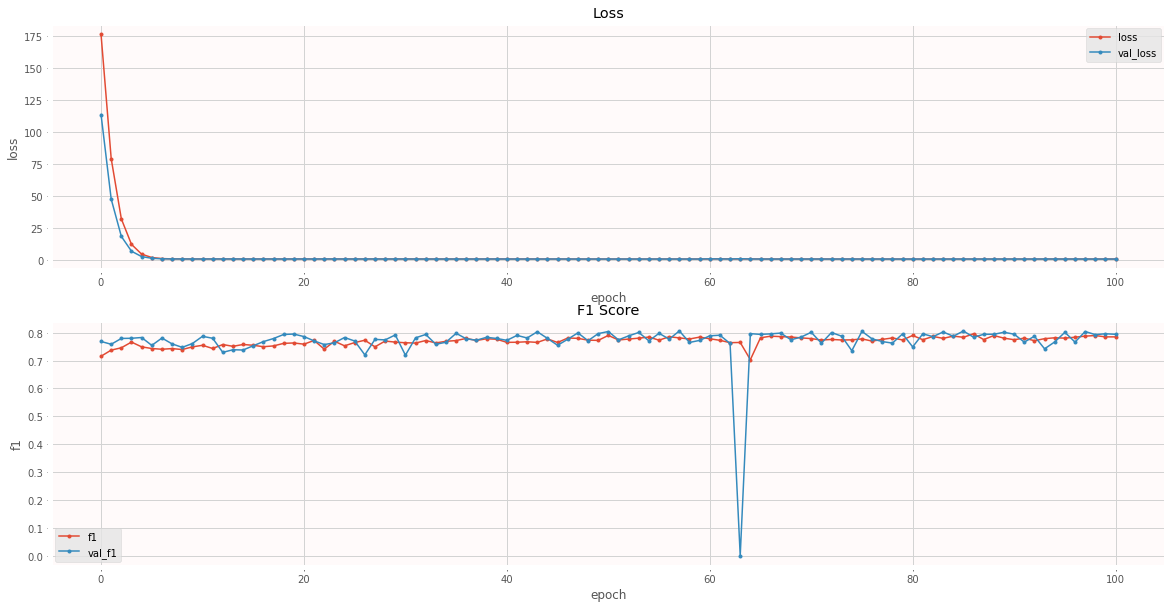

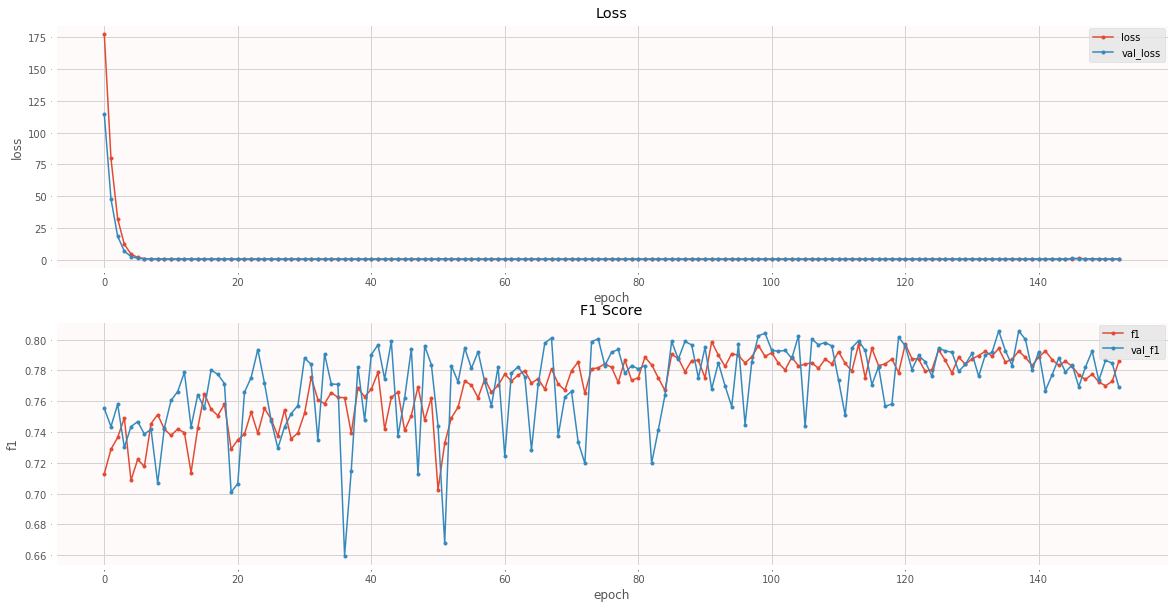

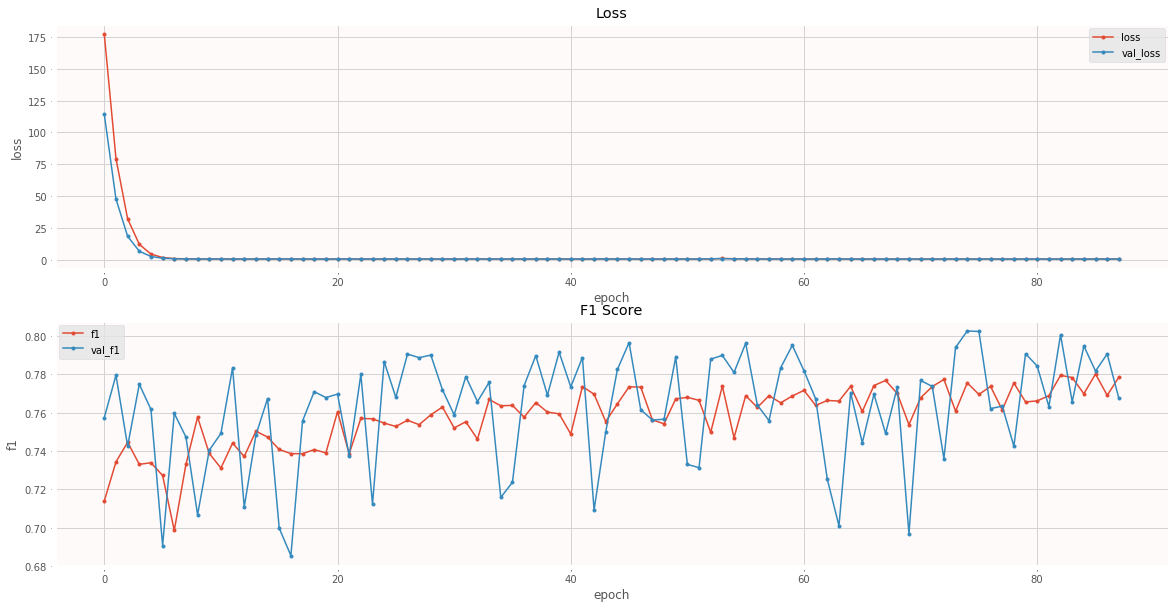

In [29]:
for i in range(len(lstm_history_list)):
    plot_history(lstm_history_list[i])

In [25]:
opt_list = ["adam", "sgd", "adagrad", "adadelta", "rmsprop", "nadam", "cocob"]
bilstm_history_list = []
bilstm_model_list = []
bilstm_performance = []

for i, optimizer in enumerate([adam, sgd, adagrad, adadelta, rmsprop, nadam, cocob]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_bilstm(x_train, y_train, embedding_matrix)
    bilstm_history_list.append(history)
    bilstm_model_list.append(model)
    
    y_pred = predict(x_test, model)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    bilstm_performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(bilstm_performance)

Training model using adam.
==================== Start Training BiLSTM ====================
Train on 5166 samples, validate on 5166 samples
Epoch 1/500
5166/5166 [==============================] - 7s 1ms/step - loss: 242.7342 - get_f1: 0.7192 - val_loss: 178.0911 - val_get_f1: 0.7624
Epoch 2/500
5166/5166 [==============================] - 5s 1ms/step - loss: 138.3540 - get_f1: 0.7409 - val_loss: 98.8444 - val_get_f1: 0.7472
Epoch 3/500
5166/5166 [==============================] - 5s 1ms/step - loss: 75.7423 - get_f1: 0.7410 - val_loss: 53.1359 - val_get_f1: 0.7687
Epoch 4/500
5166/5166 [==============================] - 5s 1ms/step - loss: 40.3165 - get_f1: 0.7366 - val_loss: 27.8983 - val_get_f1: 0.7886
Epoch 5/500
5166/5166 [==============================] - 5s 1ms/step - loss: 21.0069 - get_f1: 0.7419 - val_loss: 14.3756 - val_get_f1: 0.7222
Epoch 6/500
5166/5166 [==============================] - 5s 1ms/step - loss: 10.7996 - get_f1: 0.7264 - val_loss: 7.3578 - val_get_f1: 0.7621
E

5166/5166 [==============================] - 5s 1ms/step - loss: 0.5951 - get_f1: 0.7561 - val_loss: 0.5797 - val_get_f1: 0.7545
Epoch 58/500
5166/5166 [==============================] - 5s 1ms/step - loss: 0.5928 - get_f1: 0.7524 - val_loss: 0.5591 - val_get_f1: 0.7970
Epoch 59/500
5166/5166 [==============================] - 5s 1ms/step - loss: 0.5919 - get_f1: 0.7562 - val_loss: 0.5701 - val_get_f1: 0.7955
Epoch 60/500
5166/5166 [==============================] - 5s 1ms/step - loss: 0.5857 - get_f1: 0.7654 - val_loss: 0.5636 - val_get_f1: 0.7789
Epoch 61/500
5166/5166 [==============================] - 5s 1ms/step - loss: 0.5827 - get_f1: 0.7686 - val_loss: 0.5655 - val_get_f1: 0.7936
Epoch 62/500
5166/5166 [==============================] - 5s 1ms/step - loss: 0.5827 - get_f1: 0.7699 - val_loss: 0.5615 - val_get_f1: 0.7646
Epoch 63/500
5166/5166 [==============================] - 5s 1ms/step - loss: 0.5939 - get_f1: 0.7511 - val_loss: 0.5698 - val_get_f1: 0.7600
Epoch 64/500
5166/5

5166/5166 [==============================] - 5s 1ms/step - loss: 0.6042 - get_f1: 0.7596 - val_loss: 0.5782 - val_get_f1: 0.7578
Epoch 20/500
5166/5166 [==============================] - 5s 1ms/step - loss: 0.6067 - get_f1: 0.7429 - val_loss: 0.6027 - val_get_f1: 0.7594
Epoch 21/500
5166/5166 [==============================] - 5s 1ms/step - loss: 0.6042 - get_f1: 0.7497 - val_loss: 0.5644 - val_get_f1: 0.7845
Epoch 22/500
5166/5166 [==============================] - 5s 1ms/step - loss: 0.5986 - get_f1: 0.7514 - val_loss: 0.5690 - val_get_f1: 0.7770
Epoch 23/500
5166/5166 [==============================] - 5s 1ms/step - loss: 0.6035 - get_f1: 0.7518 - val_loss: 0.5982 - val_get_f1: 0.7250
Epoch 24/500
5166/5166 [==============================] - 5s 1ms/step - loss: 0.6148 - get_f1: 0.7318 - val_loss: 0.5878 - val_get_f1: 0.7846
Epoch 25/500
5166/5166 [==============================] - 5s 1000us/step - loss: 0.6052 - get_f1: 0.7562 - val_loss: 0.5690 - val_get_f1: 0.7539
Epoch 26/500
516

Epoch 77/500
5166/5166 [==============================] - 5s 1ms/step - loss: 0.5782 - get_f1: 0.7551 - val_loss: 0.5683 - val_get_f1: 0.7922
Epoch 78/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5804 - get_f1: 0.7668 - val_loss: 0.5791 - val_get_f1: 0.7893
Epoch 79/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.6128 - get_f1: 0.7735 - val_loss: 0.5984 - val_get_f1: 0.7751
Epoch 80/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.6104 - get_f1: 0.7715 - val_loss: 0.7329 - val_get_f1: 0.7873
Epoch 81/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.8012 - get_f1: 0.7703 - val_loss: 0.7129 - val_get_f1: 0.7980
Epoch 82/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.6799 - get_f1: 0.7611 - val_loss: 0.5991 - val_get_f1: 0.7991
Epoch 83/500
5166/5166 [==============================] - 5s 1ms/step - loss: 0.6257 - get_f1: 0.7688 - val_loss: 0.5789 - val_get_f1: 0.7913
Epoch 

5166/5166 [==============================] - 6s 1ms/step - loss: 0.5729 - get_f1: 0.7783 - val_loss: 0.5432 - val_get_f1: 0.7831
Epoch 135/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5881 - get_f1: 0.7698 - val_loss: 0.5481 - val_get_f1: 0.7970
Epoch 136/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5768 - get_f1: 0.7641 - val_loss: 0.5584 - val_get_f1: 0.7768
Confusion Matrix: 
 [[ 781  372]
 [ 303 1128]]
Training model using adagrad.
==================== Start Training BiLSTM ====================
Train on 5166 samples, validate on 5166 samples
Epoch 1/500
5166/5166 [==============================] - 7s 1ms/step - loss: 246.2953 - get_f1: 0.7223 - val_loss: 181.2290 - val_get_f1: 0.7549
Epoch 2/500
5166/5166 [==============================] - 6s 1ms/step - loss: 140.6312 - get_f1: 0.7385 - val_loss: 100.2956 - val_get_f1: 0.7534
Epoch 3/500
5166/5166 [==============================] - 6s 1ms/step - loss: 76.8289 - get_f1: 0.7405 - va

5166/5166 [==============================] - 6s 1ms/step - loss: 0.5992 - get_f1: 0.7523 - val_loss: 0.5607 - val_get_f1: 0.7819
Epoch 55/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5876 - get_f1: 0.7434 - val_loss: 0.5788 - val_get_f1: 0.7523
Epoch 56/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.6037 - get_f1: 0.7406 - val_loss: 0.5769 - val_get_f1: 0.7870
Epoch 57/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5884 - get_f1: 0.7547 - val_loss: 0.5669 - val_get_f1: 0.7442
Epoch 58/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5859 - get_f1: 0.7510 - val_loss: 0.5806 - val_get_f1: 0.7924
Epoch 59/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5916 - get_f1: 0.7591 - val_loss: 0.5698 - val_get_f1: 0.7259
Epoch 60/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5940 - get_f1: 0.7488 - val_loss: 0.5606 - val_get_f1: 0.7812
Epoch 61/500
5166/5

5166/5166 [==============================] - 6s 1ms/step - loss: 76.1997 - get_f1: 0.7348 - val_loss: 53.3982 - val_get_f1: 0.7551
Epoch 4/500
5166/5166 [==============================] - 6s 1ms/step - loss: 40.5054 - get_f1: 0.7415 - val_loss: 28.0235 - val_get_f1: 0.7654
Epoch 5/500
5166/5166 [==============================] - 6s 1ms/step - loss: 21.0881 - get_f1: 0.7449 - val_loss: 14.4406 - val_get_f1: 0.7533
Epoch 6/500
5166/5166 [==============================] - 6s 1ms/step - loss: 10.8500 - get_f1: 0.7417 - val_loss: 7.4095 - val_get_f1: 0.7259
Epoch 7/500
5166/5166 [==============================] - 6s 1ms/step - loss: 5.6011 - get_f1: 0.7350 - val_loss: 3.8485 - val_get_f1: 0.7488
Epoch 8/500
5166/5166 [==============================] - 6s 1ms/step - loss: 2.9675 - get_f1: 0.7401 - val_loss: 2.1112 - val_get_f1: 0.7498
Epoch 9/500
5166/5166 [==============================] - 6s 1ms/step - loss: 1.7056 - get_f1: 0.7265 - val_loss: 1.2695 - val_get_f1: 0.7569
Epoch 10/500
5166/

Epoch 61/500
5166/5166 [==============================] - 5s 1ms/step - loss: 0.5868 - get_f1: 0.7595 - val_loss: 0.5508 - val_get_f1: 0.7845
Epoch 62/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5895 - get_f1: 0.7600 - val_loss: 0.5608 - val_get_f1: 0.7551
Epoch 63/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5893 - get_f1: 0.7529 - val_loss: 0.5568 - val_get_f1: 0.7928
Epoch 64/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5845 - get_f1: 0.7602 - val_loss: 0.5619 - val_get_f1: 0.7380
Epoch 65/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5842 - get_f1: 0.7679 - val_loss: 0.5605 - val_get_f1: 0.7956
Epoch 66/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5946 - get_f1: 0.7654 - val_loss: 0.5679 - val_get_f1: 0.7687
Epoch 67/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5892 - get_f1: 0.7549 - val_loss: 0.5557 - val_get_f1: 0.7832
Epoch 

5166/5166 [==============================] - 6s 1ms/step - loss: 0.5911 - get_f1: 0.7596 - val_loss: 0.5653 - val_get_f1: 0.7665
Epoch 46/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.6059 - get_f1: 0.7542 - val_loss: 0.5738 - val_get_f1: 0.7610
Epoch 47/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.6059 - get_f1: 0.7454 - val_loss: 0.5715 - val_get_f1: 0.7686
Epoch 48/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5967 - get_f1: 0.7553 - val_loss: 0.5662 - val_get_f1: 0.7742
Epoch 49/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5889 - get_f1: 0.7629 - val_loss: 0.5657 - val_get_f1: 0.7995
Epoch 50/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5910 - get_f1: 0.7591 - val_loss: 0.5568 - val_get_f1: 0.7559
Epoch 51/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.6024 - get_f1: 0.7477 - val_loss: 0.5899 - val_get_f1: 0.7564
Epoch 52/500
5166/5

5166/5166 [==============================] - 6s 1ms/step - loss: 0.5977 - get_f1: 0.7528 - val_loss: 0.5739 - val_get_f1: 0.7426
Epoch 39/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5839 - get_f1: 0.7751 - val_loss: 0.5511 - val_get_f1: 0.7863
Epoch 40/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5936 - get_f1: 0.7711 - val_loss: 0.5676 - val_get_f1: 0.7766
Epoch 41/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5878 - get_f1: 0.7680 - val_loss: 0.5576 - val_get_f1: 0.7707
Epoch 42/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5834 - get_f1: 0.7418 - val_loss: 0.5577 - val_get_f1: 0.7839
Epoch 43/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5978 - get_f1: 0.7637 - val_loss: 0.5854 - val_get_f1: 0.7635
Epoch 44/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.6040 - get_f1: 0.7668 - val_loss: 0.5718 - val_get_f1: 0.7914
Epoch 45/500
5166/5

Epoch 96/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5792 - get_f1: 0.7595 - val_loss: 0.5459 - val_get_f1: 0.7739
Epoch 97/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5898 - get_f1: 0.7557 - val_loss: 0.5528 - val_get_f1: 0.7838
Epoch 98/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5876 - get_f1: 0.7652 - val_loss: 0.5583 - val_get_f1: 0.8024
Epoch 99/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5727 - get_f1: 0.7749 - val_loss: 0.5543 - val_get_f1: 0.7868
Epoch 100/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5737 - get_f1: 0.7756 - val_loss: 0.5511 - val_get_f1: 0.7721
Confusion Matrix: 
 [[ 837  410]
 [ 247 1090]]
Training model using cocob.
==================== Start Training BiLSTM ====================
Train on 5166 samples, validate on 5166 samples
Epoch 1/500
5166/5166 [==============================] - 7s 1ms/step - loss: 246.3298 - get_f1: 0.7174

5166/5166 [==============================] - 6s 1ms/step - loss: 0.6250 - get_f1: 0.7619 - val_loss: 0.6005 - val_get_f1: 0.7581
Epoch 53/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.6116 - get_f1: 0.7566 - val_loss: 0.5645 - val_get_f1: 0.7825
Epoch 54/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5910 - get_f1: 0.7622 - val_loss: 0.5625 - val_get_f1: 0.7696
Epoch 55/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5914 - get_f1: 0.7438 - val_loss: 0.5809 - val_get_f1: 0.7880
Epoch 56/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.6197 - get_f1: 0.7492 - val_loss: 0.5637 - val_get_f1: 0.7828
Epoch 57/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.6034 - get_f1: 0.7608 - val_loss: 0.5653 - val_get_f1: 0.8004
Epoch 58/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.6056 - get_f1: 0.7436 - val_loss: 0.5712 - val_get_f1: 0.7649
Epoch 59/500
5166/5

Epoch 110/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5904 - get_f1: 0.7587 - val_loss: 0.5811 - val_get_f1: 0.7984
Epoch 111/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5763 - get_f1: 0.7704 - val_loss: 0.5747 - val_get_f1: 0.7424
Epoch 112/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5855 - get_f1: 0.7664 - val_loss: 0.5535 - val_get_f1: 0.8071
Epoch 113/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5785 - get_f1: 0.7742 - val_loss: 0.5592 - val_get_f1: 0.7836
Epoch 114/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5884 - get_f1: 0.7563 - val_loss: 0.5646 - val_get_f1: 0.7821
Epoch 115/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5814 - get_f1: 0.7735 - val_loss: 0.5610 - val_get_f1: 0.7812
Epoch 116/500
5166/5166 [==============================] - 6s 1ms/step - loss: 0.5924 - get_f1: 0.7740 - val_loss: 0.5701 - val_get_f1: 0.7954

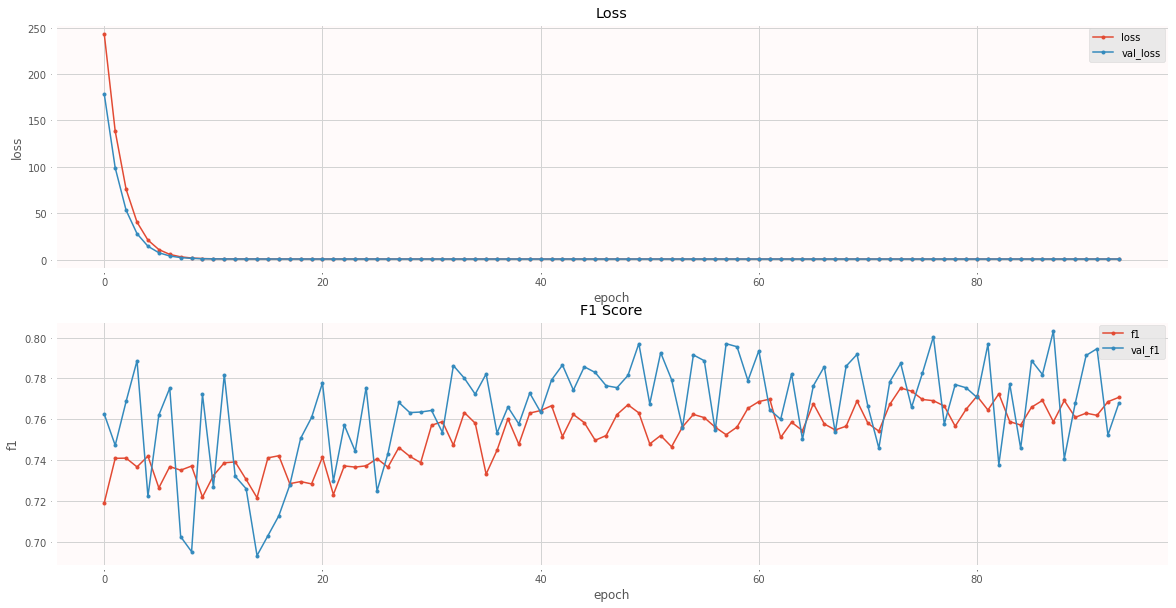

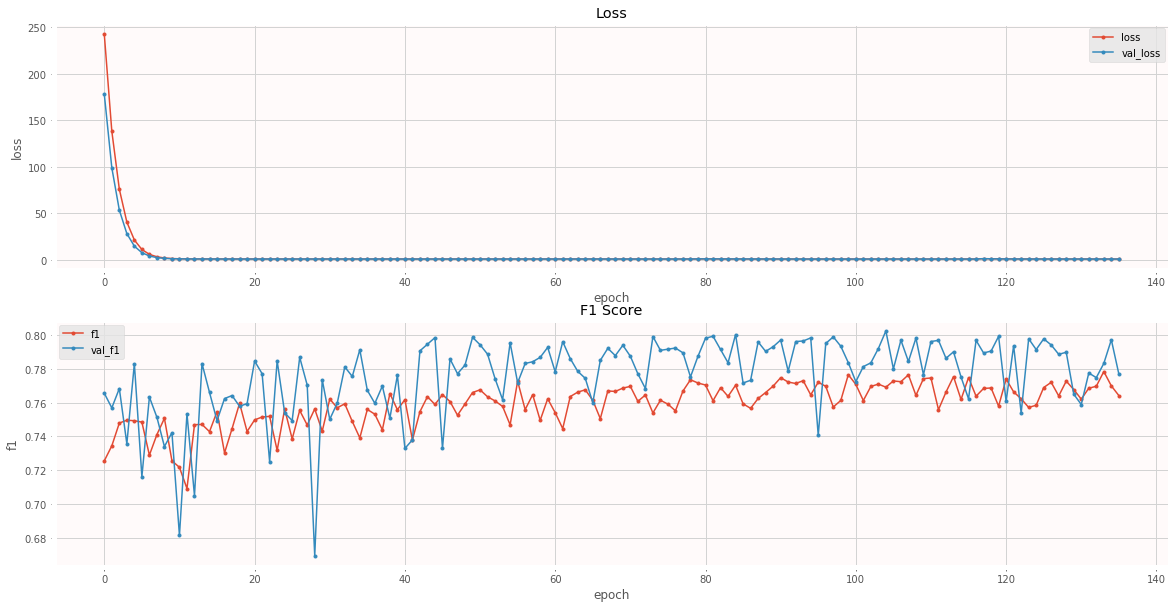

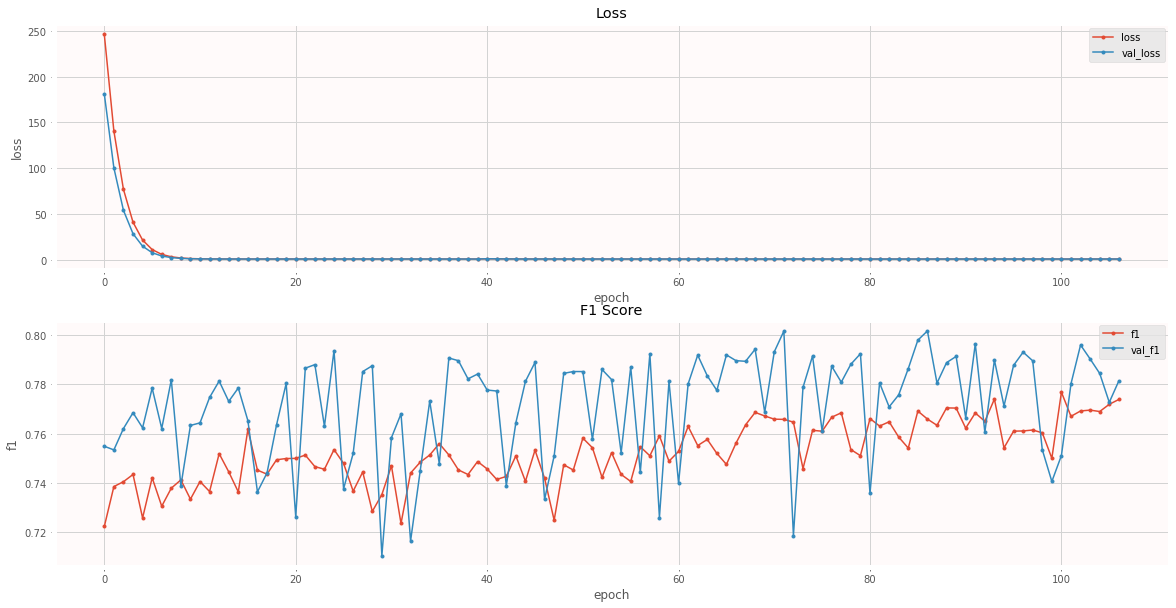

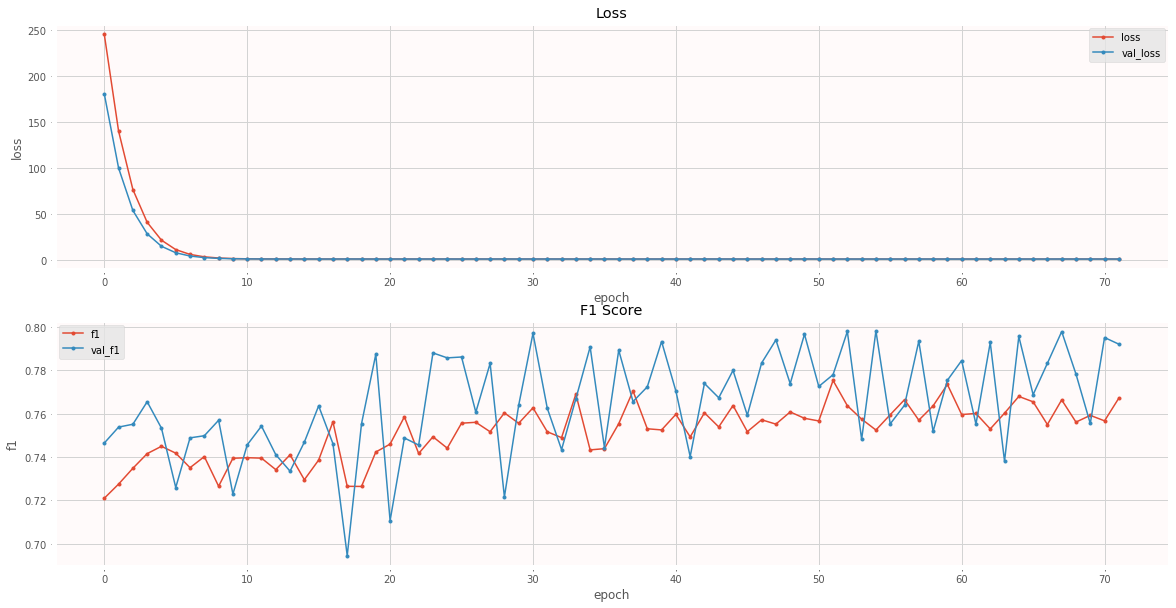

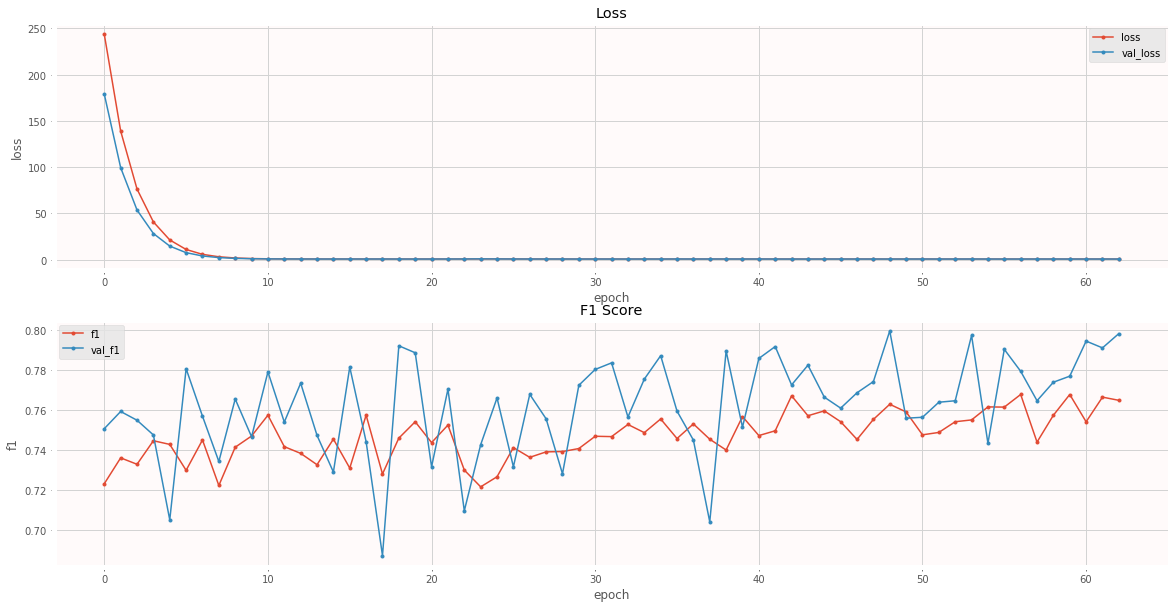

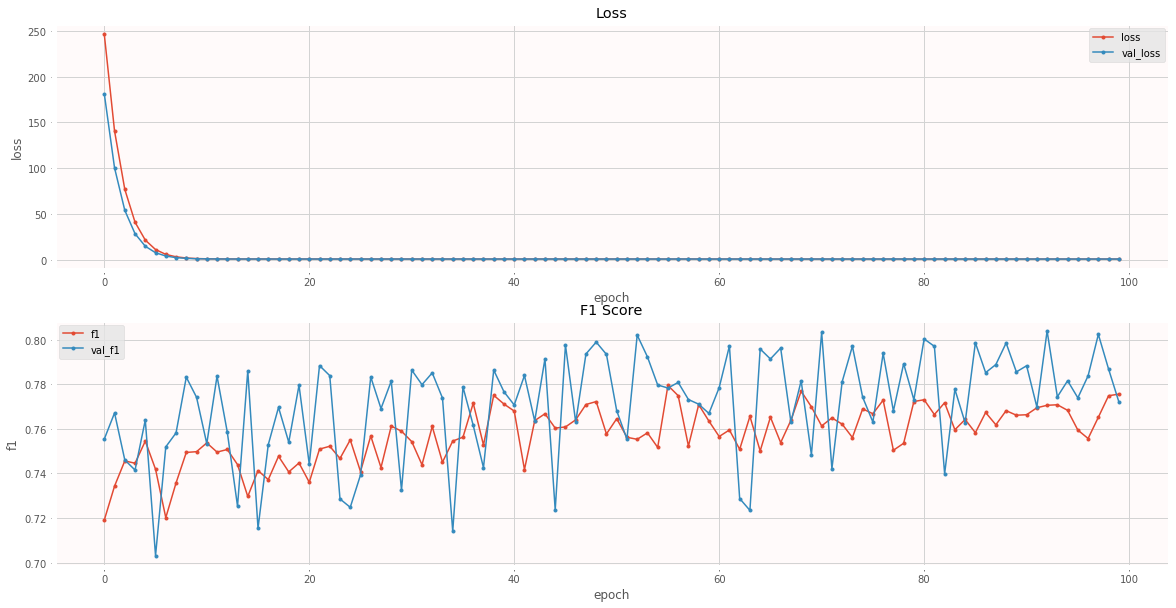

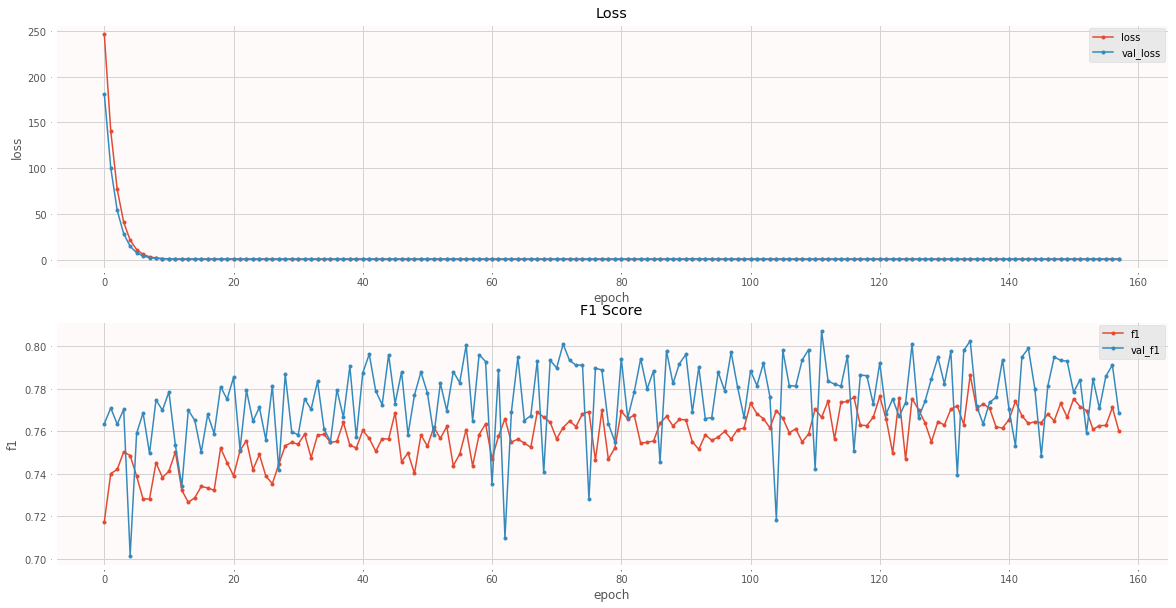

In [26]:
for i in range(len(bilstm_history_list)):
    plot_history(bilstm_history_list[i])

In [47]:
opt_list = ["adam", "sgd", "adadelta", "cocob"]
attention_history_list = []
attention_model_list = []
attention_performance = []

for i, optimizer in enumerate([adam, sgd, adadelta, cocob]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_attention(x_train, y_train, embedding_matrix)
    attention_history_list.append(history)
    attention_model_list.append(model)
    
    y_pred = predict(x_test, model)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    attention_performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(attention_performance)

Training model using adam.
==================== Start Training Attention ====================


ValueError: Operation name: "AssignAddVariableOp_2"
op: "AssignAddVariableOp"
input: "Adam/iterations"
input: "Const_2"
attr {
  key: "dtype"
  value {
    type: DT_INT64
  }
}
 is not an element of this graph.

In [ ]:
for i in range(len(attention_history_list)):
    plot_history(attention_history_list[i])

In [57]:
opt_list = ["adam", "sgd", "adagrad", "adadelta", "rmsprop", "nadam", "cocob"]
cnn_static_history_list = []
cnn_static_model_list = []
cnn_static_performance = []

for i, optimizer in enumerate([adam, sgd, adagrad, adadelta, rmsprop, nadam, cocob]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_cnn_static(x_train, y_train, embedding_matrix)
    cnn_static_history_list.append(history)
    cnn_static_model_list.append(model)
    
    y_pred = predict(x_test, model)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    cnn_static_performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(cnn_static_performance)

Training model using adam.



==================== Start Training CNN-static ====================
Train on 5166 samples, validate on 5166 samples
Epoch 1/500
5166/5166 [==============================] - 3s 605us/step - loss: 114.8210 - get_f1: 0.6699 - val_loss: 56.1961 - val_get_f1: 0.7732
Epoch 2/500
5166/5166 [==============================] - 0s 81us/step - loss: 33.1049 - get_f1: 0.7701 - val_loss: 14.6105 - val_get_f1: 0.7706
Epoch 3/500
5166/5166 [==============================] - 0s 82us/step - loss: 9.1802 - get_f1: 0.7908 - val_loss: 4.6524 - val_get_f1: 0.7819
Epoch 4/500
5166/5166 [==============================] - 0s 81us/step - loss: 3.7423 - get_f1: 0.8022 - val_loss: 2.5292 - val_get_f1: 0.7765
Epoch 5/500
5166/5166 [==============================] - 0s 82us/step - loss: 2.3558 - get_f1: 0.7998 - val_loss: 1.9138 - val_get_f1: 0.7712
Epoch 6/500
5166/5166 [==============================] - 0s 82us/step - loss: 2.0927 - get_f1: 0.8054 - val_loss: 1.8436 - val_get_f1: 0.7782
Epoch 7/500
5166/5166 [===

5166/5166 [==============================] - 0s 81us/step - loss: 0.6428 - get_f1: 0.8639 - val_loss: 0.8127 - val_get_f1: 0.7907
Epoch 115/500
5166/5166 [==============================] - 0s 81us/step - loss: 0.6416 - get_f1: 0.8668 - val_loss: 0.8023 - val_get_f1: 0.7820
Epoch 116/500
5166/5166 [==============================] - 0s 81us/step - loss: 0.6184 - get_f1: 0.8630 - val_loss: 0.7549 - val_get_f1: 0.7982
Epoch 117/500
5166/5166 [==============================] - 0s 81us/step - loss: 0.6375 - get_f1: 0.8666 - val_loss: 0.8297 - val_get_f1: 0.7786
Epoch 118/500
5166/5166 [==============================] - 0s 81us/step - loss: 0.6436 - get_f1: 0.8571 - val_loss: 0.8065 - val_get_f1: 0.7921
Epoch 119/500
5166/5166 [==============================] - 0s 81us/step - loss: 0.6351 - get_f1: 0.8700 - val_loss: 0.8131 - val_get_f1: 0.7827
Epoch 120/500
5166/5166 [==============================] - 0s 81us/step - loss: 0.6221 - get_f1: 0.8696 - val_loss: 0.7781 - val_get_f1: 0.7954
Epoch 

Epoch 40/500
5166/5166 [==============================] - 0s 81us/step - loss: 1.0762 - get_f1: 0.8286 - val_loss: 1.1109 - val_get_f1: 0.8049
Epoch 41/500
5166/5166 [==============================] - 0s 81us/step - loss: 0.9952 - get_f1: 0.8379 - val_loss: 1.0955 - val_get_f1: 0.7327
Epoch 42/500
5166/5166 [==============================] - 0s 81us/step - loss: 0.9812 - get_f1: 0.8245 - val_loss: 1.1199 - val_get_f1: 0.7861
Epoch 43/500
5166/5166 [==============================] - 0s 82us/step - loss: 1.0483 - get_f1: 0.8284 - val_loss: 1.0447 - val_get_f1: 0.8001
Epoch 44/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.9148 - get_f1: 0.8400 - val_loss: 1.0467 - val_get_f1: 0.7885
Epoch 45/500
5166/5166 [==============================] - 0s 82us/step - loss: 1.0550 - get_f1: 0.8173 - val_loss: 1.1296 - val_get_f1: 0.7950
Epoch 46/500
5166/5166 [==============================] - 0s 81us/step - loss: 0.9664 - get_f1: 0.8343 - val_loss: 0.9785 - val_get_f1: 0.7933

Epoch 9/500
5166/5166 [==============================] - 0s 81us/step - loss: 1.7357 - get_f1: 0.8092 - val_loss: 1.6572 - val_get_f1: 0.7775
Epoch 10/500
5166/5166 [==============================] - 0s 80us/step - loss: 1.6846 - get_f1: 0.8137 - val_loss: 1.5674 - val_get_f1: 0.7872
Epoch 11/500
5166/5166 [==============================] - 0s 80us/step - loss: 1.6102 - get_f1: 0.8142 - val_loss: 1.5497 - val_get_f1: 0.7619
Epoch 12/500
5166/5166 [==============================] - 0s 80us/step - loss: 1.6339 - get_f1: 0.8142 - val_loss: 1.5516 - val_get_f1: 0.7738
Epoch 13/500
5166/5166 [==============================] - 0s 81us/step - loss: 1.5276 - get_f1: 0.8218 - val_loss: 1.4162 - val_get_f1: 0.7886
Epoch 14/500
5166/5166 [==============================] - 0s 80us/step - loss: 1.4169 - get_f1: 0.8231 - val_loss: 1.4166 - val_get_f1: 0.7879
Epoch 15/500
5166/5166 [==============================] - 0s 81us/step - loss: 1.5696 - get_f1: 0.8025 - val_loss: 1.5520 - val_get_f1: 0.7749


5166/5166 [==============================] - 0s 81us/step - loss: 0.6525 - get_f1: 0.8666 - val_loss: 0.7896 - val_get_f1: 0.7978
Epoch 124/500
5166/5166 [==============================] - 0s 81us/step - loss: 0.6171 - get_f1: 0.8678 - val_loss: 0.8318 - val_get_f1: 0.7861
Epoch 125/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6461 - get_f1: 0.8596 - val_loss: 0.8061 - val_get_f1: 0.8054
Epoch 126/500
5166/5166 [==============================] - 0s 81us/step - loss: 0.6515 - get_f1: 0.8615 - val_loss: 0.8194 - val_get_f1: 0.7980
Epoch 127/500
5166/5166 [==============================] - 0s 81us/step - loss: 0.5812 - get_f1: 0.8736 - val_loss: 0.7733 - val_get_f1: 0.7912
Epoch 128/500
5166/5166 [==============================] - 0s 81us/step - loss: 0.5932 - get_f1: 0.8664 - val_loss: 0.7725 - val_get_f1: 0.7906
Epoch 129/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6109 - get_f1: 0.8654 - val_loss: 0.7727 - val_get_f1: 0.7929
Epoch 

5166/5166 [==============================] - 0s 82us/step - loss: 0.7525 - get_f1: 0.8524 - val_loss: 0.8700 - val_get_f1: 0.8009
Epoch 84/500
5166/5166 [==============================] - 0s 83us/step - loss: 0.7064 - get_f1: 0.8598 - val_loss: 0.8457 - val_get_f1: 0.7759
Epoch 85/500
5166/5166 [==============================] - 0s 81us/step - loss: 0.6491 - get_f1: 0.8593 - val_loss: 0.8106 - val_get_f1: 0.7837
Epoch 86/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.7132 - get_f1: 0.8602 - val_loss: 0.8926 - val_get_f1: 0.7902
Epoch 87/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.7103 - get_f1: 0.8436 - val_loss: 0.8438 - val_get_f1: 0.7938
Epoch 88/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.7140 - get_f1: 0.8553 - val_loss: 0.8130 - val_get_f1: 0.7947
Epoch 89/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.6957 - get_f1: 0.8596 - val_loss: 0.9100 - val_get_f1: 0.7650
Epoch 90/500

Epoch 3/500
5166/5166 [==============================] - 0s 82us/step - loss: 10.3025 - get_f1: 0.7921 - val_loss: 5.2815 - val_get_f1: 0.7576
Epoch 4/500
5166/5166 [==============================] - 0s 82us/step - loss: 4.2264 - get_f1: 0.7980 - val_loss: 2.8461 - val_get_f1: 0.7788
Epoch 5/500
5166/5166 [==============================] - 0s 83us/step - loss: 2.6422 - get_f1: 0.8070 - val_loss: 2.1248 - val_get_f1: 0.7329
Epoch 6/500
5166/5166 [==============================] - 0s 82us/step - loss: 2.2773 - get_f1: 0.8045 - val_loss: 1.8920 - val_get_f1: 0.7783
Epoch 7/500
5166/5166 [==============================] - 0s 82us/step - loss: 1.9865 - get_f1: 0.8136 - val_loss: 1.7554 - val_get_f1: 0.7826
Epoch 8/500
5166/5166 [==============================] - 0s 82us/step - loss: 1.8789 - get_f1: 0.8063 - val_loss: 1.6958 - val_get_f1: 0.7852
Epoch 9/500
5166/5166 [==============================] - 0s 82us/step - loss: 1.7356 - get_f1: 0.8094 - val_loss: 1.6268 - val_get_f1: 0.7846
Epoch

5166/5166 [==============================] - 0s 82us/step - loss: 0.6301 - get_f1: 0.8635 - val_loss: 0.8003 - val_get_f1: 0.7988
Epoch 118/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.6382 - get_f1: 0.8702 - val_loss: 0.7948 - val_get_f1: 0.8004
Epoch 119/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.6417 - get_f1: 0.8581 - val_loss: 0.8457 - val_get_f1: 0.7772
Epoch 120/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.6101 - get_f1: 0.8742 - val_loss: 0.7512 - val_get_f1: 0.8090
Epoch 121/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.5656 - get_f1: 0.8721 - val_loss: 0.7462 - val_get_f1: 0.8133
Epoch 122/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.6005 - get_f1: 0.8731 - val_loss: 0.7915 - val_get_f1: 0.7931
Epoch 123/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.6147 - get_f1: 0.8610 - val_loss: 0.7941 - val_get_f1: 0.7967
Epoch 

Epoch 32/500
5166/5166 [==============================] - 0s 82us/step - loss: 1.1520 - get_f1: 0.8224 - val_loss: 1.1090 - val_get_f1: 0.7897
Epoch 33/500
5166/5166 [==============================] - 0s 82us/step - loss: 1.0400 - get_f1: 0.8296 - val_loss: 1.0722 - val_get_f1: 0.7856
Epoch 34/500
5166/5166 [==============================] - 0s 82us/step - loss: 1.0251 - get_f1: 0.8314 - val_loss: 1.1169 - val_get_f1: 0.7776
Epoch 35/500
5166/5166 [==============================] - 0s 82us/step - loss: 1.0381 - get_f1: 0.8323 - val_loss: 1.0655 - val_get_f1: 0.7962
Epoch 36/500
5166/5166 [==============================] - 0s 82us/step - loss: 1.0335 - get_f1: 0.8293 - val_loss: 1.0696 - val_get_f1: 0.7828
Epoch 37/500
5166/5166 [==============================] - 0s 82us/step - loss: 1.1022 - get_f1: 0.8255 - val_loss: 1.2090 - val_get_f1: 0.7865
Epoch 38/500
5166/5166 [==============================] - 0s 82us/step - loss: 1.1269 - get_f1: 0.8333 - val_loss: 1.2070 - val_get_f1: 0.7791

5166/5166 [==============================] - 1s 162us/step - loss: 116.5464 - get_f1: 0.6444 - val_loss: 57.6738 - val_get_f1: 0.7704
Epoch 2/500
5166/5166 [==============================] - 0s 82us/step - loss: 34.2988 - get_f1: 0.7603 - val_loss: 15.4715 - val_get_f1: 0.7532
Epoch 3/500
5166/5166 [==============================] - 0s 82us/step - loss: 10.0305 - get_f1: 0.7863 - val_loss: 5.1096 - val_get_f1: 0.7795
Epoch 4/500
5166/5166 [==============================] - 0s 82us/step - loss: 4.1552 - get_f1: 0.7955 - val_loss: 2.7302 - val_get_f1: 0.7611
Epoch 5/500
5166/5166 [==============================] - 0s 82us/step - loss: 2.5812 - get_f1: 0.8056 - val_loss: 2.0290 - val_get_f1: 0.7734
Epoch 6/500
5166/5166 [==============================] - 0s 82us/step - loss: 2.0428 - get_f1: 0.8142 - val_loss: 1.7906 - val_get_f1: 0.7877
Epoch 7/500
5166/5166 [==============================] - 0s 82us/step - loss: 1.8964 - get_f1: 0.8133 - val_loss: 1.7698 - val_get_f1: 0.7773
Epoch 8/500

5166/5166 [==============================] - 0s 82us/step - loss: 0.6518 - get_f1: 0.8642 - val_loss: 0.8668 - val_get_f1: 0.7710
Epoch 116/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.6301 - get_f1: 0.8721 - val_loss: 0.8123 - val_get_f1: 0.7975
Epoch 117/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.6579 - get_f1: 0.8578 - val_loss: 0.8198 - val_get_f1: 0.7920
Epoch 118/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.6314 - get_f1: 0.8693 - val_loss: 0.8715 - val_get_f1: 0.7858
Epoch 119/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.6670 - get_f1: 0.8700 - val_loss: 0.8239 - val_get_f1: 0.7995
Epoch 120/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.6242 - get_f1: 0.8727 - val_loss: 0.8014 - val_get_f1: 0.7997
Epoch 121/500
5166/5166 [==============================] - 0s 82us/step - loss: 0.6135 - get_f1: 0.8712 - val_loss: 0.8231 - val_get_f1: 0.7810
Epoch 

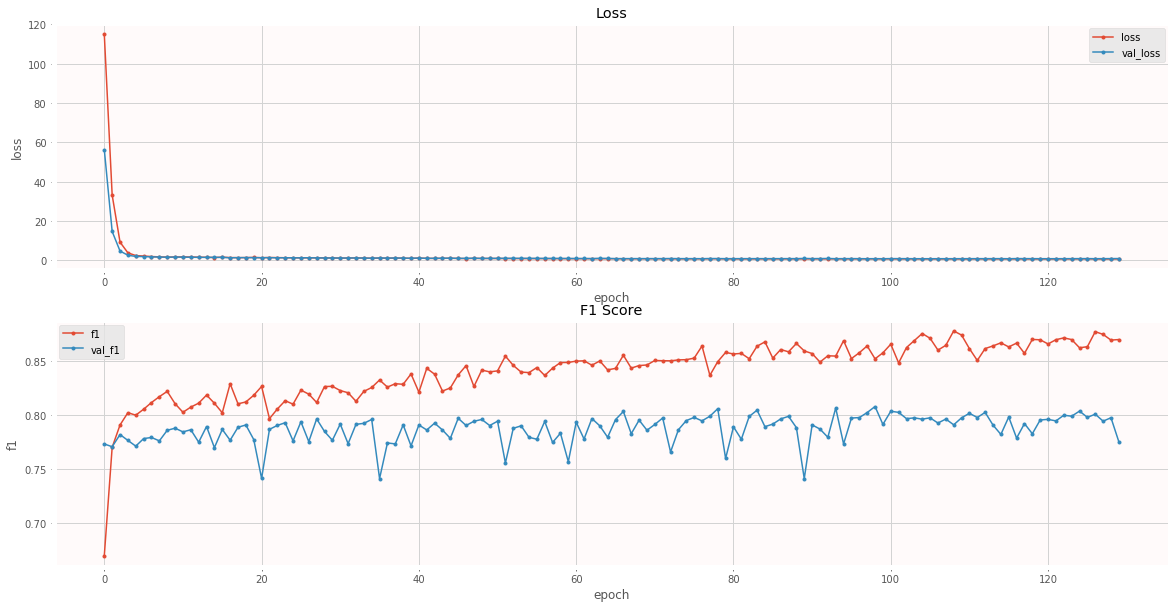

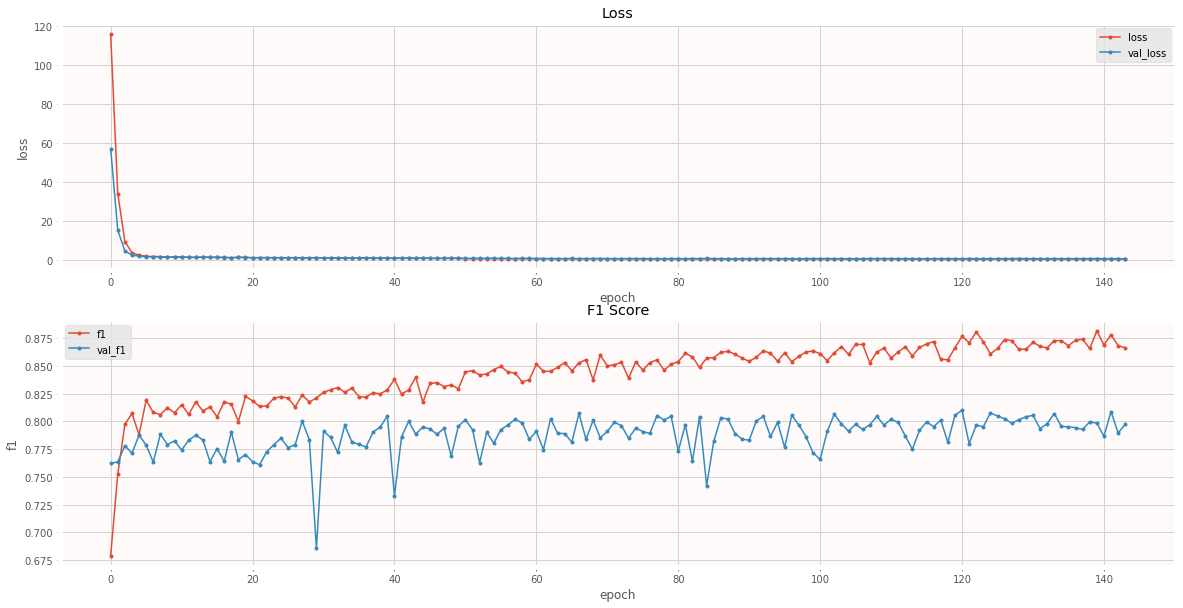

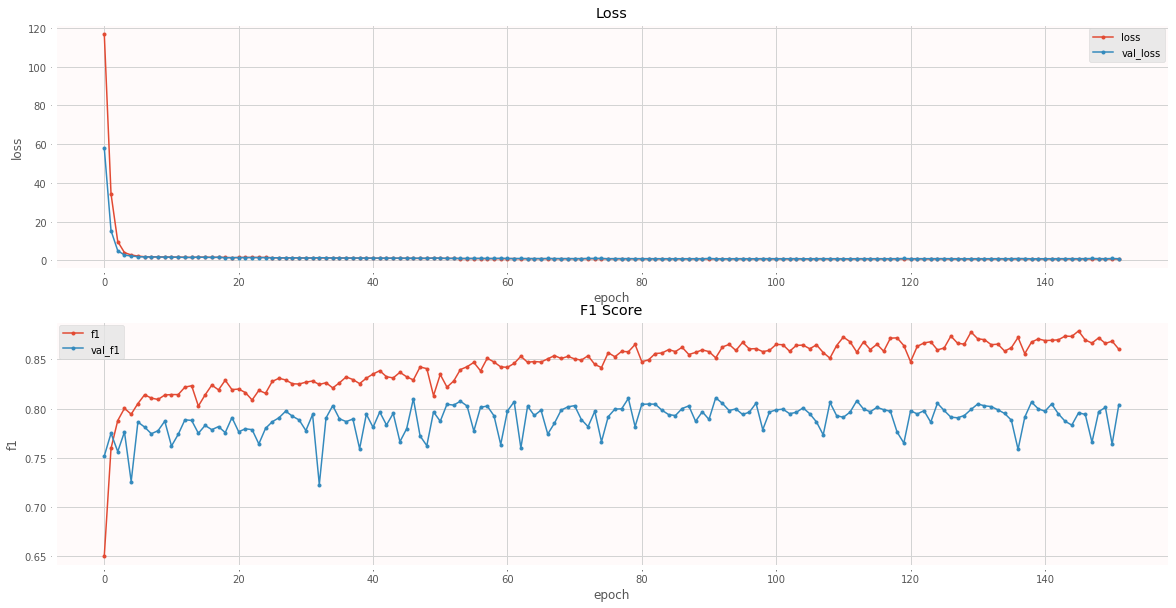

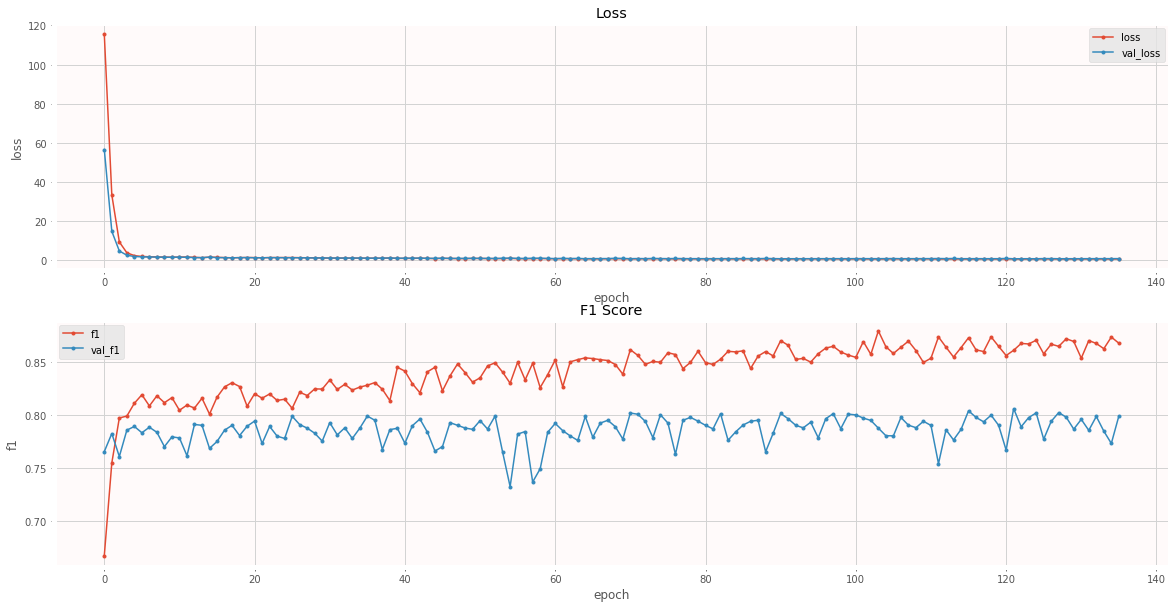

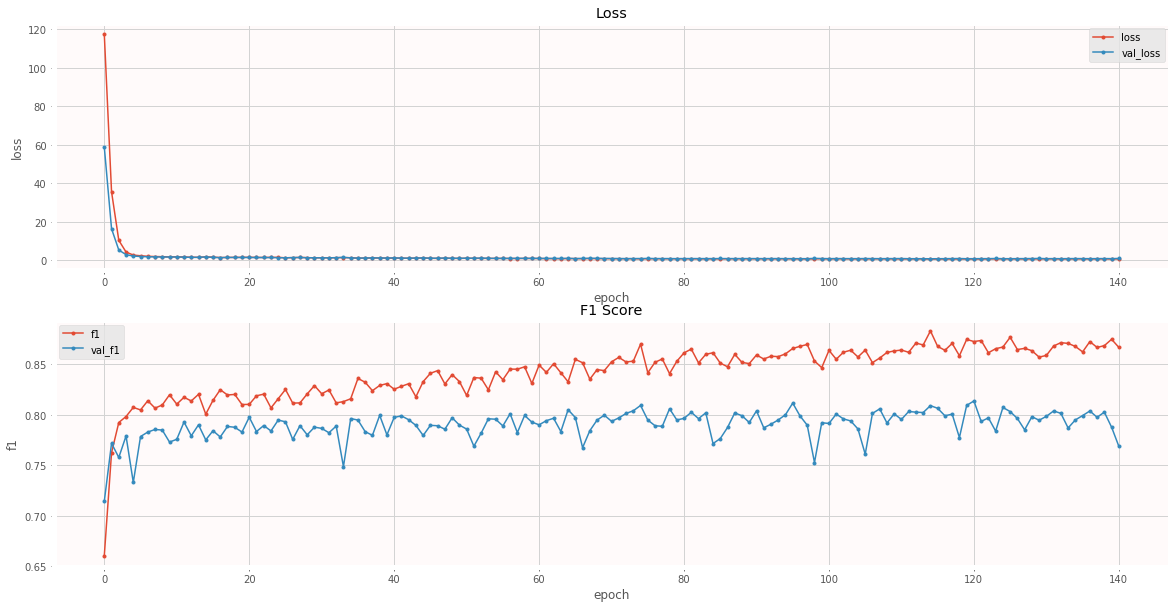

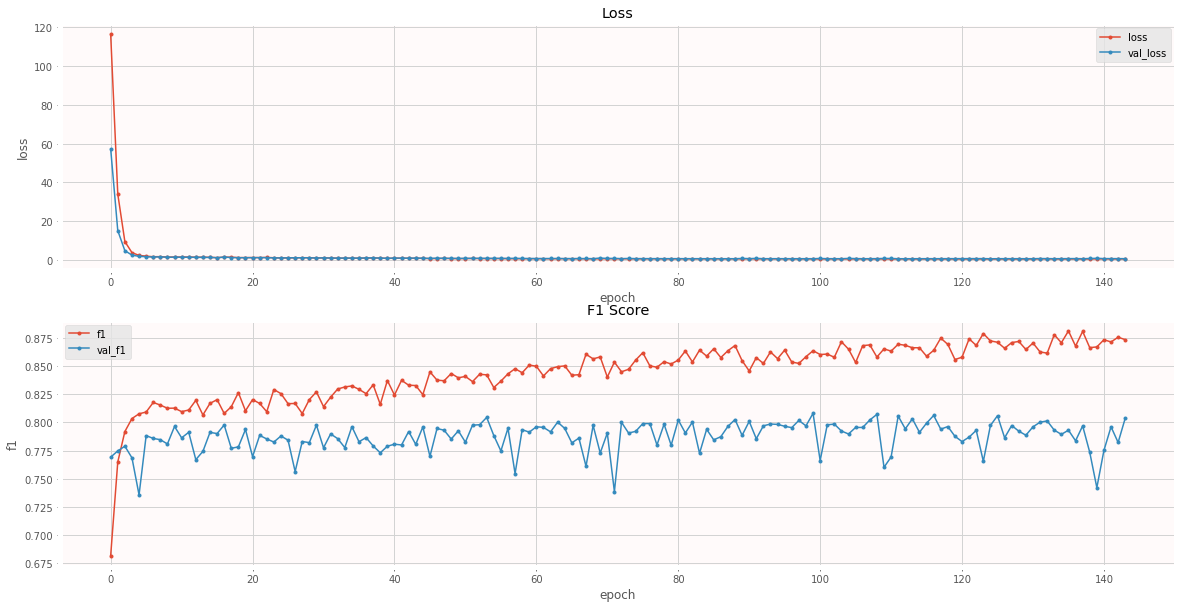

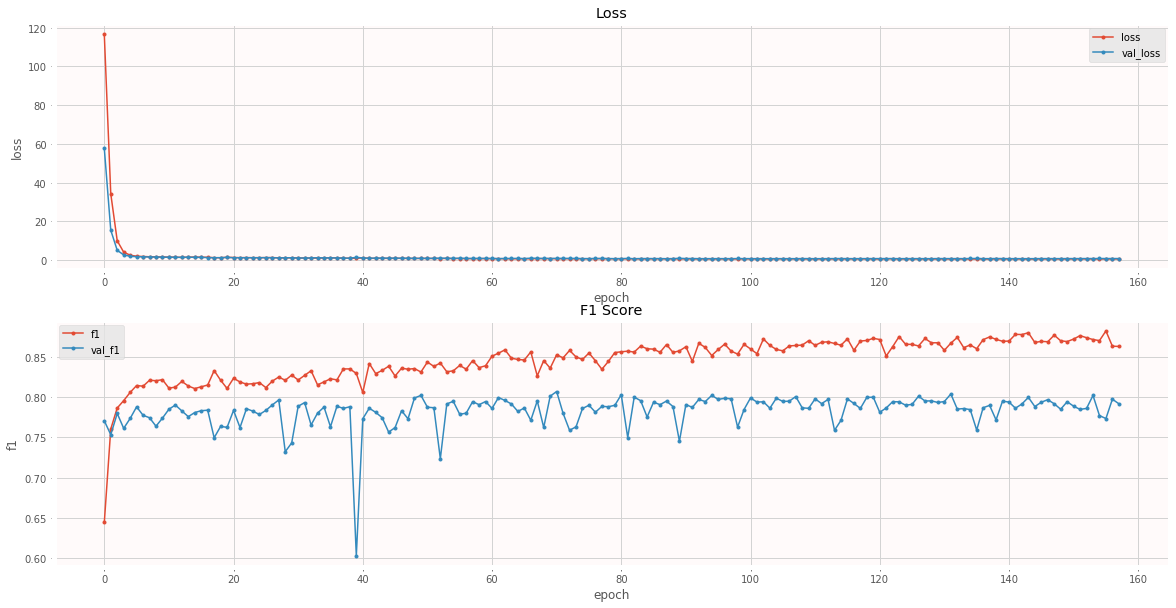

In [58]:
for i in range(len(cnn_static_history_list)):
    plot_history(cnn_static_history_list[i])

In [59]:
opt_list = ["adam", "sgd", "adagrad", "adadelta", "rmsprop", "nadam", "cocob"]
cnn_multichannel_history_list = []
cnn_multichannel_model_list = []
cnn_multichannel_performance = []

for i, optimizer in enumerate([adam, sgd, adagrad, adadelta, rmsprop, nadam, cocob]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_cnn_multichannel(x_train, y_train, embedding_matrix)
    cnn_multichannel_history_list.append(history)
    cnn_multichannel_model_list.append(model)
    
    y_prob = model.predict([x_test, x_test, x_test])
    y_prob = y_prob.squeeze()
    y_pred = (y_prob > 0.5)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    cnn_multichannel_performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(cnn_multichannel_performance)

Training model using adam.
==================== Start Training CNN-multichannel ====================
Train on 5166 samples, validate on 5166 samples
Epoch 1/500
5166/5166 [==============================] - 1s 174us/step - loss: 122.0867 - get_f1: 0.6218 - val_loss: 65.1900 - val_get_f1: 0.7387
Epoch 2/500
5166/5166 [==============================] - 0s 80us/step - loss: 39.1804 - get_f1: 0.7149 - val_loss: 17.9795 - val_get_f1: 0.7508
Epoch 3/500
5166/5166 [==============================] - 0s 80us/step - loss: 10.0602 - get_f1: 0.7563 - val_loss: 4.3558 - val_get_f1: 0.7756
Epoch 4/500
5166/5166 [==============================] - 0s 80us/step - loss: 2.5309 - get_f1: 0.7681 - val_loss: 1.4685 - val_get_f1: 0.7739
Epoch 5/500
5166/5166 [==============================] - 0s 80us/step - loss: 1.0622 - get_f1: 0.7726 - val_loss: 1.0244 - val_get_f1: 0.7533
Epoch 6/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.9420 - get_f1: 0.7566 - val_loss: 0.9956 - val_get_f1:

5166/5166 [==============================] - 0s 79us/step - loss: 0.6745 - get_f1: 0.8774 - val_loss: 0.8710 - val_get_f1: 0.7930
Epoch 115/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6451 - get_f1: 0.8735 - val_loss: 0.8916 - val_get_f1: 0.7954
Epoch 116/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6365 - get_f1: 0.8718 - val_loss: 0.8488 - val_get_f1: 0.7847
Epoch 117/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6678 - get_f1: 0.8720 - val_loss: 0.9144 - val_get_f1: 0.7771
Epoch 118/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6767 - get_f1: 0.8624 - val_loss: 0.9155 - val_get_f1: 0.7949
Epoch 119/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.7799 - get_f1: 0.8739 - val_loss: 0.8608 - val_get_f1: 0.7885
Epoch 120/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6110 - get_f1: 0.8749 - val_loss: 0.8699 - val_get_f1: 0.7832
Epoch 

Epoch 171/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6247 - get_f1: 0.8934 - val_loss: 0.9558 - val_get_f1: 0.7913
Epoch 172/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.7124 - get_f1: 0.8941 - val_loss: 1.0017 - val_get_f1: 0.7826
Epoch 173/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.5832 - get_f1: 0.9023 - val_loss: 0.9640 - val_get_f1: 0.7790
Epoch 174/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.5561 - get_f1: 0.9076 - val_loss: 0.9188 - val_get_f1: 0.7905
Epoch 175/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.5980 - get_f1: 0.8937 - val_loss: 0.9885 - val_get_f1: 0.7950
Epoch 176/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.5802 - get_f1: 0.8977 - val_loss: 0.9573 - val_get_f1: 0.7843
Epoch 177/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.5542 - get_f1: 0.9060 - val_loss: 0.9757 - val_get_f1:

5166/5166 [==============================] - 0s 80us/step - loss: 0.6928 - get_f1: 0.8518 - val_loss: 0.8309 - val_get_f1: 0.7911
Epoch 70/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6998 - get_f1: 0.8592 - val_loss: 0.9315 - val_get_f1: 0.7887
Epoch 71/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.7127 - get_f1: 0.8499 - val_loss: 0.8157 - val_get_f1: 0.7787
Epoch 72/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6512 - get_f1: 0.8706 - val_loss: 0.8371 - val_get_f1: 0.7839
Epoch 73/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.6797 - get_f1: 0.8642 - val_loss: 0.8886 - val_get_f1: 0.7891
Epoch 74/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6918 - get_f1: 0.8633 - val_loss: 0.8619 - val_get_f1: 0.7886
Epoch 75/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.7621 - get_f1: 0.8631 - val_loss: 0.9044 - val_get_f1: 0.7827
Epoch 76/500

5166/5166 [==============================] - 0s 80us/step - loss: 9.8432 - get_f1: 0.7608 - val_loss: 4.2413 - val_get_f1: 0.7806
Epoch 4/500
5166/5166 [==============================] - 0s 80us/step - loss: 2.4396 - get_f1: 0.7813 - val_loss: 1.4182 - val_get_f1: 0.7820
Epoch 5/500
5166/5166 [==============================] - 0s 79us/step - loss: 1.0484 - get_f1: 0.7811 - val_loss: 0.9850 - val_get_f1: 0.7726
Epoch 6/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.8572 - get_f1: 0.7850 - val_loss: 0.9844 - val_get_f1: 0.7695
Epoch 7/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.8720 - get_f1: 0.7733 - val_loss: 0.9623 - val_get_f1: 0.7793
Epoch 8/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.8566 - get_f1: 0.7788 - val_loss: 0.9552 - val_get_f1: 0.7808
Epoch 9/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.8162 - get_f1: 0.7824 - val_loss: 0.9715 - val_get_f1: 0.7765
Epoch 10/500
5166/

5166/5166 [==============================] - 0s 80us/step - loss: 0.6142 - get_f1: 0.8785 - val_loss: 0.9477 - val_get_f1: 0.7736
Epoch 118/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6338 - get_f1: 0.8841 - val_loss: 1.0022 - val_get_f1: 0.7205
Epoch 119/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6166 - get_f1: 0.8811 - val_loss: 0.8696 - val_get_f1: 0.7938
Epoch 120/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6009 - get_f1: 0.8974 - val_loss: 0.8926 - val_get_f1: 0.7870
Epoch 121/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.5889 - get_f1: 0.8896 - val_loss: 0.9138 - val_get_f1: 0.7744
Epoch 122/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.5896 - get_f1: 0.8935 - val_loss: 0.8884 - val_get_f1: 0.7944
Epoch 123/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.5948 - get_f1: 0.8962 - val_loss: 0.8882 - val_get_f1: 0.7858
Epoch 

Epoch 174/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.5368 - get_f1: 0.9024 - val_loss: 1.0194 - val_get_f1: 0.7561
Epoch 175/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.7436 - get_f1: 0.8812 - val_loss: 1.0214 - val_get_f1: 0.7763
Epoch 176/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6987 - get_f1: 0.8895 - val_loss: 1.0342 - val_get_f1: 0.7704
Epoch 177/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.5886 - get_f1: 0.9067 - val_loss: 1.0039 - val_get_f1: 0.7818
Epoch 178/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.5493 - get_f1: 0.9107 - val_loss: 1.0191 - val_get_f1: 0.7567
Epoch 179/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.5399 - get_f1: 0.9118 - val_loss: 0.9697 - val_get_f1: 0.7861
Epoch 180/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.5461 - get_f1: 0.9056 - val_loss: 0.9625 - val_get_f1:

Epoch 42/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.7852 - get_f1: 0.8050 - val_loss: 0.7607 - val_get_f1: 0.7917
Epoch 43/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.7669 - get_f1: 0.7997 - val_loss: 0.8166 - val_get_f1: 0.7563
Epoch 44/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.7790 - get_f1: 0.8104 - val_loss: 0.8600 - val_get_f1: 0.7318
Epoch 45/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.8266 - get_f1: 0.8049 - val_loss: 0.7915 - val_get_f1: 0.7878
Epoch 46/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.7478 - get_f1: 0.8104 - val_loss: 0.8233 - val_get_f1: 0.7705
Epoch 47/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.7949 - get_f1: 0.8191 - val_loss: 0.8390 - val_get_f1: 0.7883
Epoch 48/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.7777 - get_f1: 0.8146 - val_loss: 0.8232 - val_get_f1: 0.7655

Epoch 156/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.5660 - get_f1: 0.8962 - val_loss: 0.9459 - val_get_f1: 0.7860
Epoch 157/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6505 - get_f1: 0.8898 - val_loss: 0.9605 - val_get_f1: 0.7792
Epoch 158/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.5673 - get_f1: 0.9103 - val_loss: 0.9787 - val_get_f1: 0.7774
Epoch 159/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.5672 - get_f1: 0.9061 - val_loss: 0.9193 - val_get_f1: 0.7868
Epoch 160/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.5833 - get_f1: 0.9058 - val_loss: 1.0308 - val_get_f1: 0.7992
Epoch 161/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.5455 - get_f1: 0.9035 - val_loss: 1.0006 - val_get_f1: 0.7687
Epoch 162/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.5561 - get_f1: 0.9026 - val_loss: 0.9472 - val_get_f1:

Confusion Matrix: 
 [[ 743  303]
 [ 341 1197]]
Training model using nadam.
==================== Start Training CNN-multichannel ====================
Train on 5166 samples, validate on 5166 samples
Epoch 1/500
5166/5166 [==============================] - 1s 172us/step - loss: 123.0502 - get_f1: 0.5923 - val_loss: 65.9497 - val_get_f1: 0.7598
Epoch 2/500
5166/5166 [==============================] - 0s 80us/step - loss: 39.9117 - get_f1: 0.7002 - val_loss: 18.4574 - val_get_f1: 0.7293
Epoch 3/500
5166/5166 [==============================] - 0s 80us/step - loss: 10.4140 - get_f1: 0.7368 - val_loss: 4.5449 - val_get_f1: 0.7756
Epoch 4/500
5166/5166 [==============================] - 0s 80us/step - loss: 2.5985 - get_f1: 0.7780 - val_loss: 1.4783 - val_get_f1: 0.7750
Epoch 5/500
5166/5166 [==============================] - 0s 80us/step - loss: 1.1280 - get_f1: 0.7702 - val_loss: 1.0379 - val_get_f1: 0.7658
Epoch 6/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.8799 -

Epoch 57/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.8773 - get_f1: 0.7883 - val_loss: 0.8347 - val_get_f1: 0.7756
Epoch 58/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.8212 - get_f1: 0.7891 - val_loss: 0.8920 - val_get_f1: 0.7848
Epoch 59/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.7865 - get_f1: 0.7944 - val_loss: 0.8237 - val_get_f1: 0.7917
Epoch 60/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.7821 - get_f1: 0.8023 - val_loss: 0.8165 - val_get_f1: 0.7806
Epoch 61/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.8181 - get_f1: 0.7934 - val_loss: 0.8777 - val_get_f1: 0.7839
Epoch 62/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.7903 - get_f1: 0.8068 - val_loss: 0.8414 - val_get_f1: 0.7804
Epoch 63/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.7922 - get_f1: 0.8001 - val_loss: 0.8223 - val_get_f1: 0.7870

Epoch 10/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.8084 - get_f1: 0.7658 - val_loss: 0.9411 - val_get_f1: 0.7788
Epoch 11/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.8439 - get_f1: 0.7738 - val_loss: 0.9108 - val_get_f1: 0.7671
Epoch 12/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.8437 - get_f1: 0.7684 - val_loss: 0.9239 - val_get_f1: 0.7671
Epoch 13/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.8783 - get_f1: 0.7626 - val_loss: 0.9059 - val_get_f1: 0.7650
Epoch 14/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.8259 - get_f1: 0.7682 - val_loss: 0.9416 - val_get_f1: 0.7651
Epoch 15/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.8297 - get_f1: 0.7686 - val_loss: 0.8673 - val_get_f1: 0.7775
Epoch 16/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.8518 - get_f1: 0.7766 - val_loss: 0.8931 - val_get_f1: 0.7649

5166/5166 [==============================] - 0s 80us/step - loss: 0.6422 - get_f1: 0.8762 - val_loss: 0.9236 - val_get_f1: 0.7990
Epoch 125/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6809 - get_f1: 0.8785 - val_loss: 0.9060 - val_get_f1: 0.7897
Epoch 126/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.7019 - get_f1: 0.8808 - val_loss: 0.8650 - val_get_f1: 0.7848
Epoch 127/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.6216 - get_f1: 0.8909 - val_loss: 0.8987 - val_get_f1: 0.7743
Epoch 128/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.6018 - get_f1: 0.8858 - val_loss: 0.9085 - val_get_f1: 0.7735
Epoch 129/500
5166/5166 [==============================] - 0s 80us/step - loss: 0.7082 - get_f1: 0.8738 - val_loss: 0.9094 - val_get_f1: 0.7921
Epoch 130/500
5166/5166 [==============================] - 0s 79us/step - loss: 0.6638 - get_f1: 0.8779 - val_loss: 0.8820 - val_get_f1: 0.7895
Epoch 

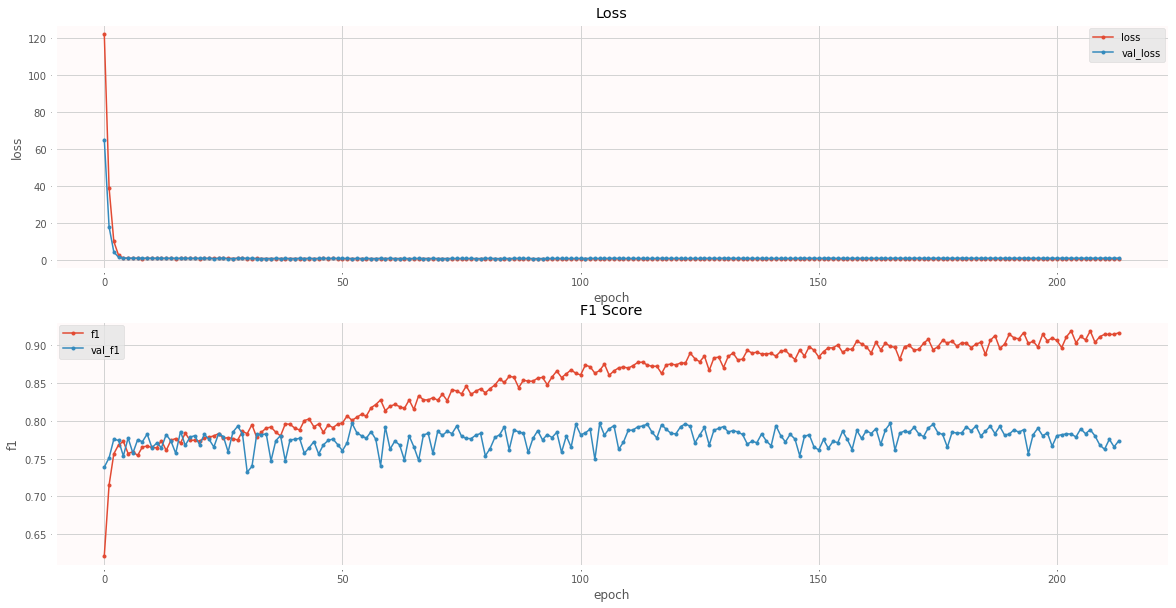

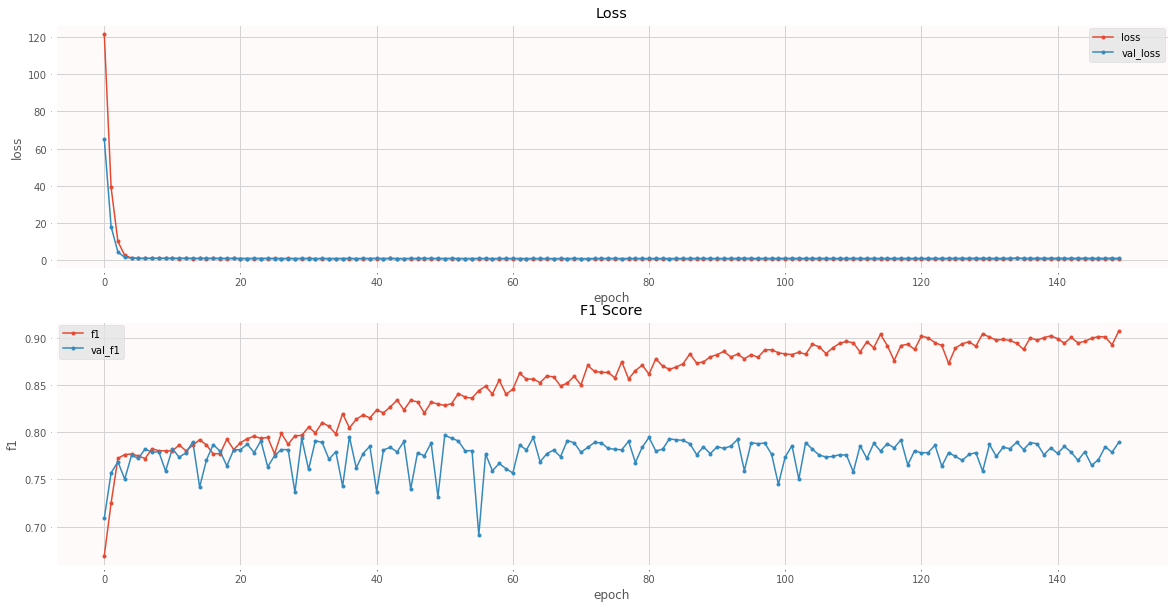

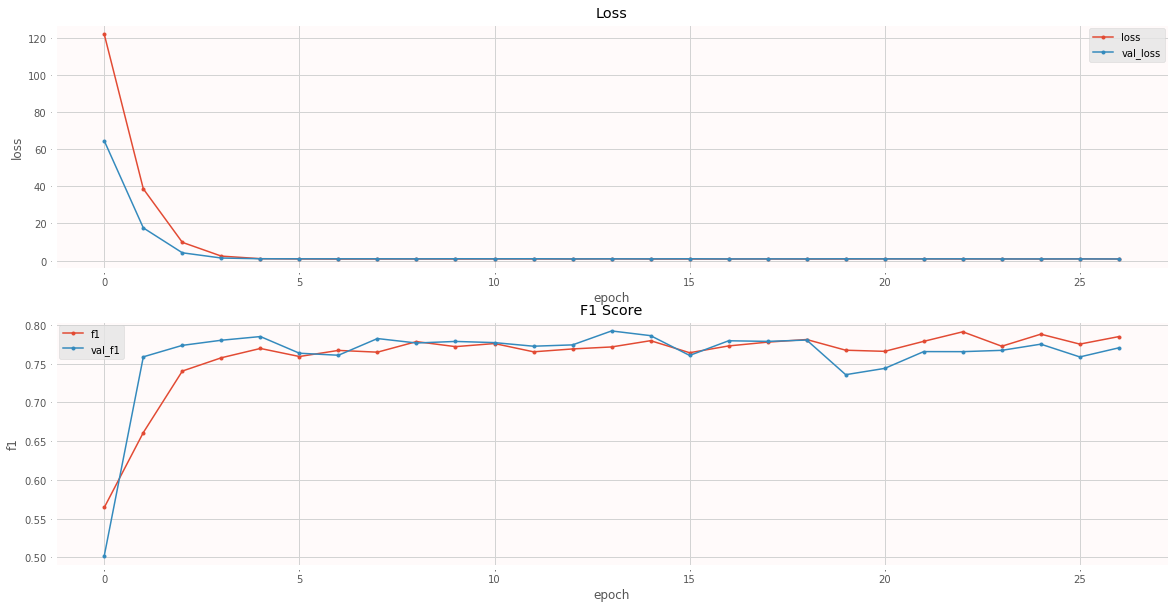

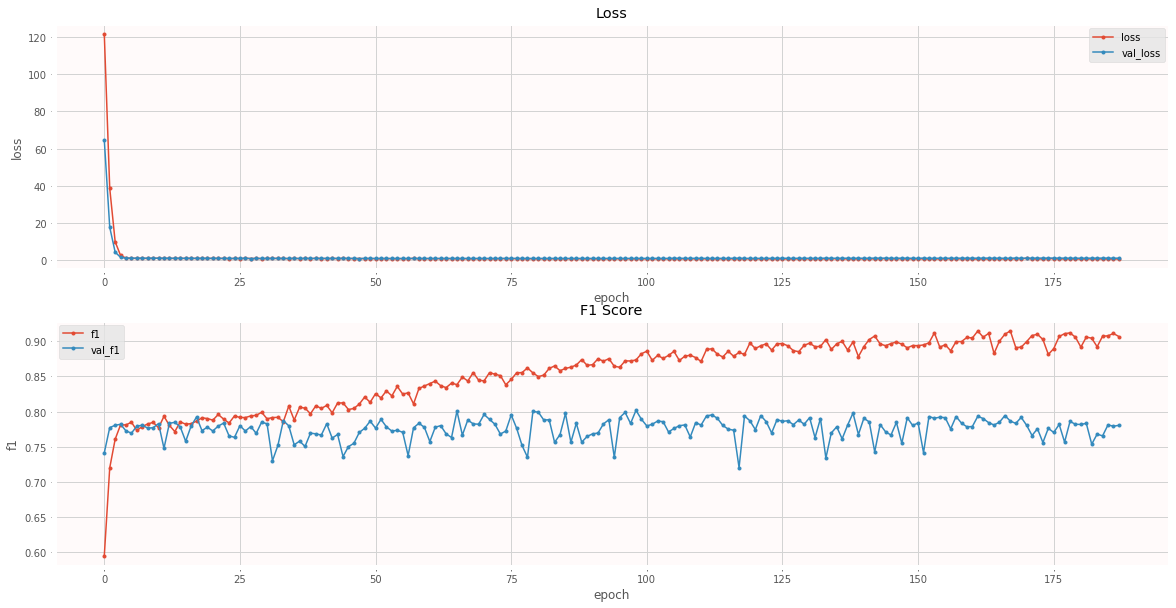

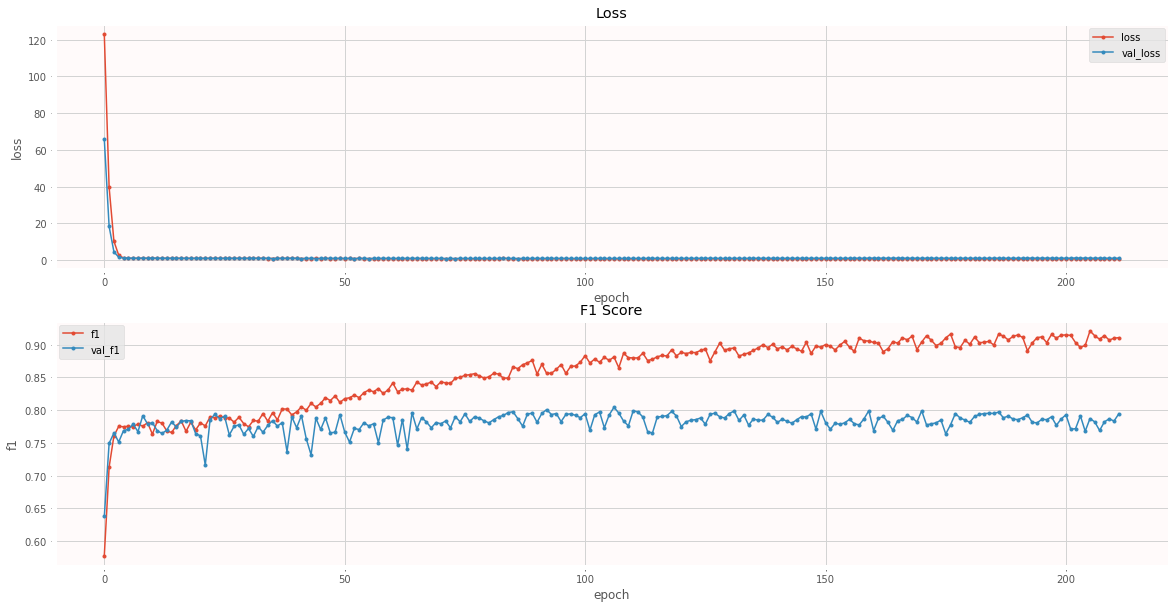

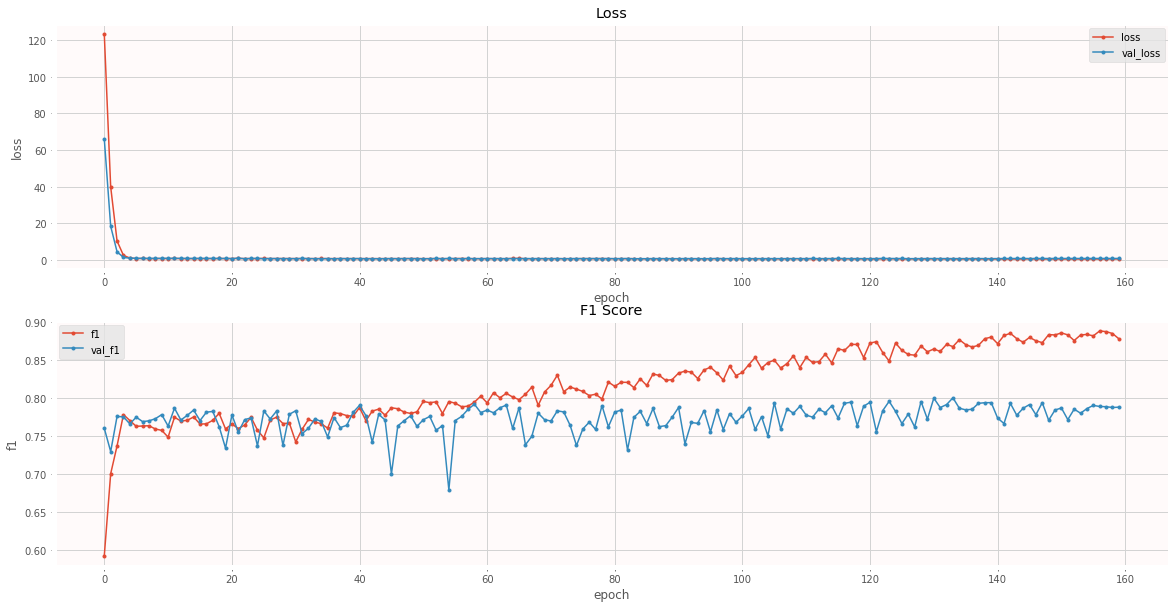

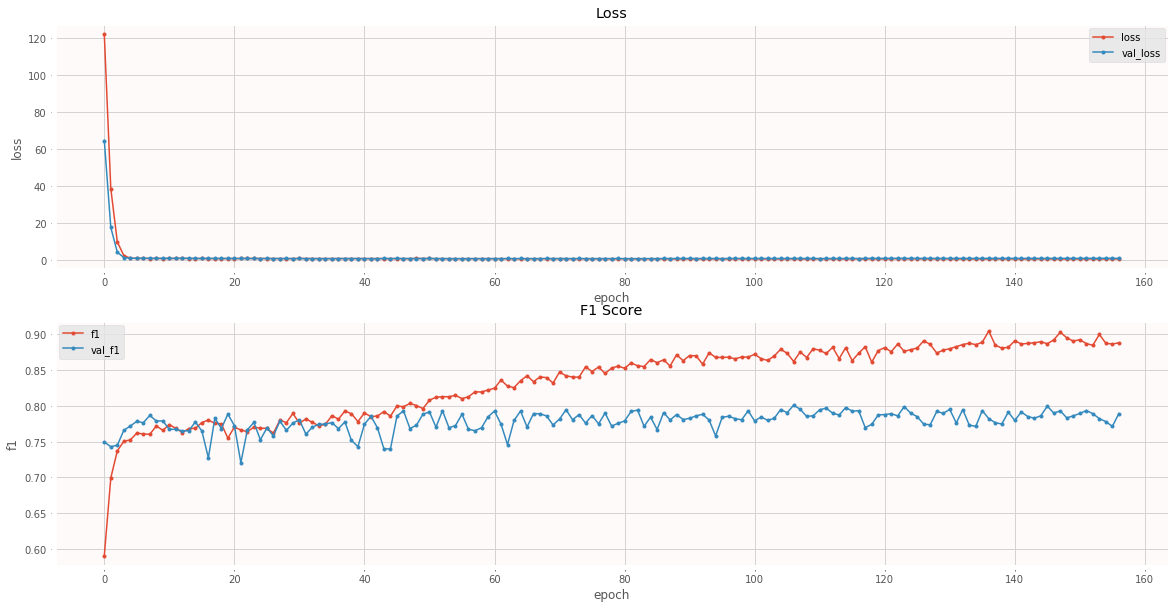

In [60]:
for i in range(len(cnn_multichannel_history_list)):
    plot_history(cnn_multichannel_history_list[i])

In [61]:
opt_list = ["adam", "sgd", "adagrad", "adadelta", "rmsprop", "nadam", "cocob"]
cnn_lstm_history_list = []
cnn_lstm_model_list = []
cnn_lstm_performance = []

for i, optimizer in enumerate([adam, sgd, adagrad, adadelta, rmsprop, nadam, cocob]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_cnn_lstm(x_train, y_train, embedding_matrix)
    cnn_lstm_history_list.append(history)
    cnn_lstm_model_list.append(model)
    
    y_pred = predict(x_test, model)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    cnn_lstm_performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(cnn_lstm_performance)

Training model using adam.
==================== Start Training CNN-LSTM ====================
Train on 5166 samples, validate on 5166 samples
Epoch 1/500
5166/5166 [==============================] - 1s 238us/step - loss: 52.4755 - get_f1: 0.7268 - val_loss: 34.5578 - val_get_f1: 0.7154
Epoch 2/500
5166/5166 [==============================] - 1s 151us/step - loss: 24.5769 - get_f1: 0.7554 - val_loss: 15.3644 - val_get_f1: 0.7861
Epoch 3/500
5166/5166 [==============================] - 1s 151us/step - loss: 10.6190 - get_f1: 0.7869 - val_loss: 6.4294 - val_get_f1: 0.8008
Epoch 4/500
5166/5166 [==============================] - 1s 150us/step - loss: 4.4350 - get_f1: 0.7799 - val_loss: 2.7754 - val_get_f1: 0.7282
Epoch 5/500
5166/5166 [==============================] - 1s 150us/step - loss: 1.9097 - get_f1: 0.8022 - val_loss: 1.2743 - val_get_f1: 0.7750
Epoch 6/500
5166/5166 [==============================] - 1s 153us/step - loss: 0.9580 - get_f1: 0.8040 - val_loss: 0.7641 - val_get_f1: 0.8

Epoch 57/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.1465 - get_f1: 0.9640 - val_loss: 0.8284 - val_get_f1: 0.8125
Epoch 58/500
5166/5166 [==============================] - 1s 148us/step - loss: 0.1463 - get_f1: 0.9642 - val_loss: 0.9086 - val_get_f1: 0.8031
Epoch 59/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.2056 - get_f1: 0.9463 - val_loss: 0.7750 - val_get_f1: 0.8004
Epoch 60/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.1636 - get_f1: 0.9634 - val_loss: 0.7173 - val_get_f1: 0.8033
Epoch 61/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1747 - get_f1: 0.9562 - val_loss: 0.8033 - val_get_f1: 0.7720
Epoch 62/500
5166/5166 [==============================] - 1s 148us/step - loss: 0.2093 - get_f1: 0.9453 - val_loss: 0.7638 - val_get_f1: 0.7961
Epoch 63/500
5166/5166 [==============================] - 1s 147us/step - loss: 0.1588 - get_f1: 0.9626 - val_loss: 0.8733 - val_get_f1:

Epoch 114/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1236 - get_f1: 0.9681 - val_loss: 1.0299 - val_get_f1: 0.8093
Epoch 115/500
5166/5166 [==============================] - 1s 148us/step - loss: 0.1048 - get_f1: 0.9741 - val_loss: 1.0803 - val_get_f1: 0.7973
Epoch 116/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.0964 - get_f1: 0.9766 - val_loss: 1.2043 - val_get_f1: 0.8074
Epoch 117/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.0986 - get_f1: 0.9740 - val_loss: 1.1154 - val_get_f1: 0.8089
Epoch 118/500
5166/5166 [==============================] - 1s 152us/step - loss: 0.1300 - get_f1: 0.9692 - val_loss: 1.0084 - val_get_f1: 0.7715
Epoch 119/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.1060 - get_f1: 0.9740 - val_loss: 0.9273 - val_get_f1: 0.7914
Epoch 120/500
5166/5166 [==============================] - 1s 152us/step - loss: 0.1044 - get_f1: 0.9740 - val_loss: 1.2459 - val_

5166/5166 [==============================] - 1s 149us/step - loss: 0.2416 - get_f1: 0.9364 - val_loss: 0.6642 - val_get_f1: 0.8074
Epoch 32/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.2112 - get_f1: 0.9455 - val_loss: 0.6282 - val_get_f1: 0.8016
Epoch 33/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.2335 - get_f1: 0.9359 - val_loss: 0.5938 - val_get_f1: 0.8019
Epoch 34/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.2365 - get_f1: 0.9360 - val_loss: 0.7549 - val_get_f1: 0.7973
Epoch 35/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.2253 - get_f1: 0.9364 - val_loss: 0.8280 - val_get_f1: 0.7763
Epoch 36/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.2506 - get_f1: 0.9317 - val_loss: 0.6206 - val_get_f1: 0.7911
Epoch 37/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.2185 - get_f1: 0.9420 - val_loss: 0.7338 - val_get_f1: 0.8017
Epoch

Epoch 88/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1425 - get_f1: 0.9633 - val_loss: 0.9593 - val_get_f1: 0.8056
Epoch 89/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.1289 - get_f1: 0.9711 - val_loss: 0.9960 - val_get_f1: 0.8050
Epoch 90/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.1107 - get_f1: 0.9754 - val_loss: 1.0761 - val_get_f1: 0.7940
Epoch 91/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1281 - get_f1: 0.9689 - val_loss: 0.9830 - val_get_f1: 0.7954
Epoch 92/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.1163 - get_f1: 0.9701 - val_loss: 0.8555 - val_get_f1: 0.7999
Epoch 93/500
5166/5166 [==============================] - 1s 152us/step - loss: 0.1042 - get_f1: 0.9732 - val_loss: 0.9262 - val_get_f1: 0.7912
Epoch 94/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1175 - get_f1: 0.9698 - val_loss: 0.9111 - val_get_f1:

5166/5166 [==============================] - 1s 150us/step - loss: 0.3774 - get_f1: 0.8819 - val_loss: 0.6859 - val_get_f1: 0.7963
Epoch 25/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.3086 - get_f1: 0.9135 - val_loss: 0.6183 - val_get_f1: 0.8136
Epoch 26/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.2626 - get_f1: 0.9271 - val_loss: 0.7161 - val_get_f1: 0.7959
Epoch 27/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.2875 - get_f1: 0.9136 - val_loss: 0.5752 - val_get_f1: 0.8075
Epoch 28/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.2947 - get_f1: 0.9158 - val_loss: 0.6825 - val_get_f1: 0.7875
Epoch 29/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.2625 - get_f1: 0.9296 - val_loss: 0.5982 - val_get_f1: 0.8078
Epoch 30/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.2575 - get_f1: 0.9272 - val_loss: 0.8957 - val_get_f1: 0.7330
Epoch

Epoch 81/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1242 - get_f1: 0.9704 - val_loss: 0.8249 - val_get_f1: 0.8050
Epoch 82/500
5166/5166 [==============================] - 1s 148us/step - loss: 0.1334 - get_f1: 0.9672 - val_loss: 0.8873 - val_get_f1: 0.7899
Epoch 83/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1114 - get_f1: 0.9734 - val_loss: 0.9316 - val_get_f1: 0.8102
Epoch 84/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.1157 - get_f1: 0.9724 - val_loss: 0.9826 - val_get_f1: 0.7958
Epoch 85/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1214 - get_f1: 0.9704 - val_loss: 0.8652 - val_get_f1: 0.7792
Epoch 86/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.1445 - get_f1: 0.9629 - val_loss: 0.7407 - val_get_f1: 0.7970
Epoch 87/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1534 - get_f1: 0.9625 - val_loss: 0.7909 - val_get_f1:

Epoch 90/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1051 - get_f1: 0.9754 - val_loss: 1.0022 - val_get_f1: 0.7963
Epoch 91/500
5166/5166 [==============================] - 1s 148us/step - loss: 0.1079 - get_f1: 0.9733 - val_loss: 1.0773 - val_get_f1: 0.7992
Epoch 92/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1289 - get_f1: 0.9686 - val_loss: 0.8925 - val_get_f1: 0.8065
Epoch 93/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.1215 - get_f1: 0.9683 - val_loss: 0.9053 - val_get_f1: 0.7959
Epoch 94/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1214 - get_f1: 0.9706 - val_loss: 0.9554 - val_get_f1: 0.8043
Epoch 95/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.1274 - get_f1: 0.9695 - val_loss: 0.9808 - val_get_f1: 0.8074
Epoch 96/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.1164 - get_f1: 0.9702 - val_loss: 1.0608 - val_get_f1:

Train on 5166 samples, validate on 5166 samples
Epoch 1/500
5166/5166 [==============================] - 1s 231us/step - loss: 52.1000 - get_f1: 0.6927 - val_loss: 34.2784 - val_get_f1: 0.6885
Epoch 2/500
5166/5166 [==============================] - 1s 151us/step - loss: 24.3681 - get_f1: 0.7281 - val_loss: 15.1783 - val_get_f1: 0.7887
Epoch 3/500
5166/5166 [==============================] - 1s 149us/step - loss: 10.5066 - get_f1: 0.7828 - val_loss: 6.3382 - val_get_f1: 0.8023
Epoch 4/500
5166/5166 [==============================] - 1s 151us/step - loss: 4.3504 - get_f1: 0.7952 - val_loss: 2.6603 - val_get_f1: 0.8028
Epoch 5/500
5166/5166 [==============================] - 1s 149us/step - loss: 1.8533 - get_f1: 0.8037 - val_loss: 1.2495 - val_get_f1: 0.8073
Epoch 6/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.9400 - get_f1: 0.8140 - val_loss: 0.7484 - val_get_f1: 0.7843
Epoch 7/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.6127 - g

5166/5166 [==============================] - 1s 149us/step - loss: 0.1087 - get_f1: 0.9727 - val_loss: 0.8294 - val_get_f1: 0.8035
Epoch 114/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.1091 - get_f1: 0.9742 - val_loss: 0.9169 - val_get_f1: 0.8032
Epoch 115/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.0993 - get_f1: 0.9748 - val_loss: 0.9809 - val_get_f1: 0.8049
Epoch 116/500
5166/5166 [==============================] - 1s 152us/step - loss: 0.1048 - get_f1: 0.9757 - val_loss: 1.1441 - val_get_f1: 0.7918
Epoch 117/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1002 - get_f1: 0.9749 - val_loss: 0.9543 - val_get_f1: 0.8035
Epoch 118/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.0971 - get_f1: 0.9753 - val_loss: 1.1458 - val_get_f1: 0.7947
Epoch 119/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1069 - get_f1: 0.9718 - val_loss: 1.0211 - val_get_f1: 0.7995

Epoch 78/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.1323 - get_f1: 0.9696 - val_loss: 1.0086 - val_get_f1: 0.7751
Epoch 79/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.1297 - get_f1: 0.9715 - val_loss: 0.9013 - val_get_f1: 0.7877
Epoch 80/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.1311 - get_f1: 0.9677 - val_loss: 1.0218 - val_get_f1: 0.7915
Epoch 81/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.1221 - get_f1: 0.9710 - val_loss: 0.8823 - val_get_f1: 0.7980
Epoch 82/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.1306 - get_f1: 0.9681 - val_loss: 0.7759 - val_get_f1: 0.8119
Epoch 83/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.1377 - get_f1: 0.9666 - val_loss: 0.9762 - val_get_f1: 0.7978
Epoch 84/500
5166/5166 [==============================] - 1s 151us/step - loss: 0.1257 - get_f1: 0.9692 - val_loss: 0.9453 - val_get_f1:

5166/5166 [==============================] - 1s 151us/step - loss: 0.3766 - get_f1: 0.8785 - val_loss: 0.5511 - val_get_f1: 0.8072
Epoch 15/500
5166/5166 [==============================] - 1s 148us/step - loss: 0.4120 - get_f1: 0.8540 - val_loss: 0.5219 - val_get_f1: 0.8081
Epoch 16/500
5166/5166 [==============================] - 1s 148us/step - loss: 0.3718 - get_f1: 0.8756 - val_loss: 0.5806 - val_get_f1: 0.8093
Epoch 17/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.3448 - get_f1: 0.8863 - val_loss: 0.7162 - val_get_f1: 0.7222
Epoch 18/500
5166/5166 [==============================] - 1s 152us/step - loss: 0.4022 - get_f1: 0.8655 - val_loss: 0.5818 - val_get_f1: 0.8083
Epoch 19/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.3505 - get_f1: 0.8930 - val_loss: 0.5616 - val_get_f1: 0.7569
Epoch 20/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.3374 - get_f1: 0.9003 - val_loss: 0.5779 - val_get_f1: 0.8095
Epoch

Epoch 71/500
5166/5166 [==============================] - 1s 152us/step - loss: 0.1450 - get_f1: 0.9661 - val_loss: 0.8303 - val_get_f1: 0.8026
Epoch 72/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1387 - get_f1: 0.9688 - val_loss: 0.8194 - val_get_f1: 0.8065
Epoch 73/500
5166/5166 [==============================] - 1s 148us/step - loss: 0.1234 - get_f1: 0.9709 - val_loss: 0.9318 - val_get_f1: 0.7979
Epoch 74/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1254 - get_f1: 0.9670 - val_loss: 0.8309 - val_get_f1: 0.7921
Epoch 75/500
5166/5166 [==============================] - 1s 152us/step - loss: 0.1266 - get_f1: 0.9678 - val_loss: 0.9660 - val_get_f1: 0.7747
Epoch 76/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.1512 - get_f1: 0.9623 - val_loss: 0.9714 - val_get_f1: 0.7589
Epoch 77/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1535 - get_f1: 0.9610 - val_loss: 1.1339 - val_get_f1:

Epoch 128/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.1149 - get_f1: 0.9668 - val_loss: 1.0455 - val_get_f1: 0.8098
Epoch 129/500
5166/5166 [==============================] - 1s 148us/step - loss: 0.1150 - get_f1: 0.9707 - val_loss: 0.9902 - val_get_f1: 0.7859
Epoch 130/500
5166/5166 [==============================] - 1s 152us/step - loss: 0.1157 - get_f1: 0.9692 - val_loss: 1.4595 - val_get_f1: 0.8074
Epoch 131/500
5166/5166 [==============================] - 1s 150us/step - loss: 0.1680 - get_f1: 0.9556 - val_loss: 0.9293 - val_get_f1: 0.7844
Epoch 132/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1201 - get_f1: 0.9718 - val_loss: 0.9963 - val_get_f1: 0.7962
Epoch 133/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.0964 - get_f1: 0.9775 - val_loss: 1.2229 - val_get_f1: 0.7878
Epoch 134/500
5166/5166 [==============================] - 1s 149us/step - loss: 0.1067 - get_f1: 0.9724 - val_loss: 0.9246 - val_

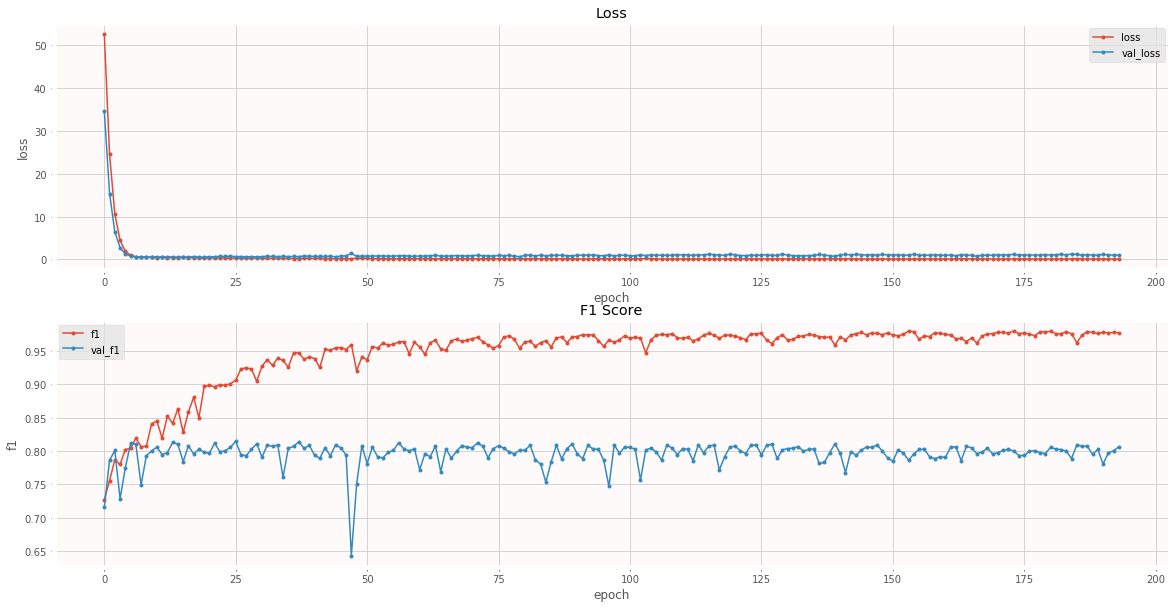

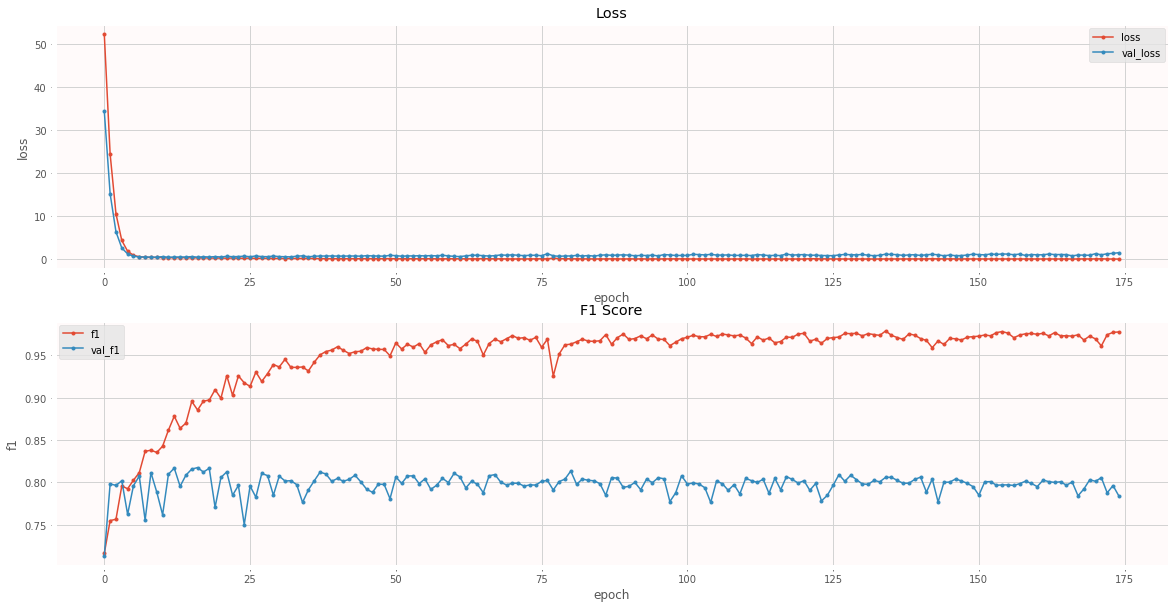

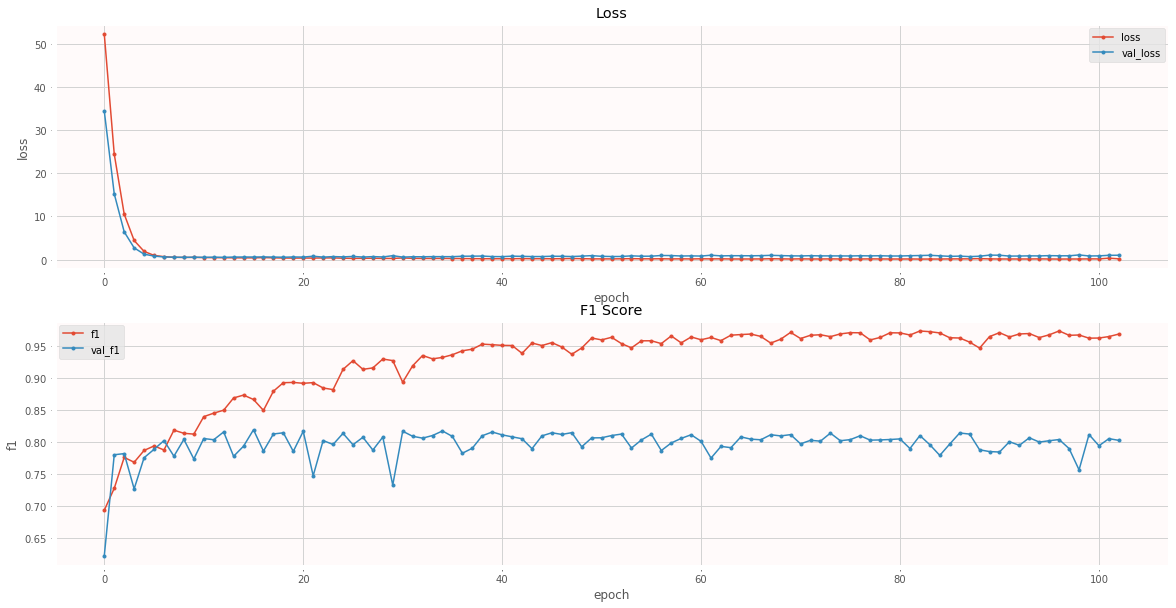

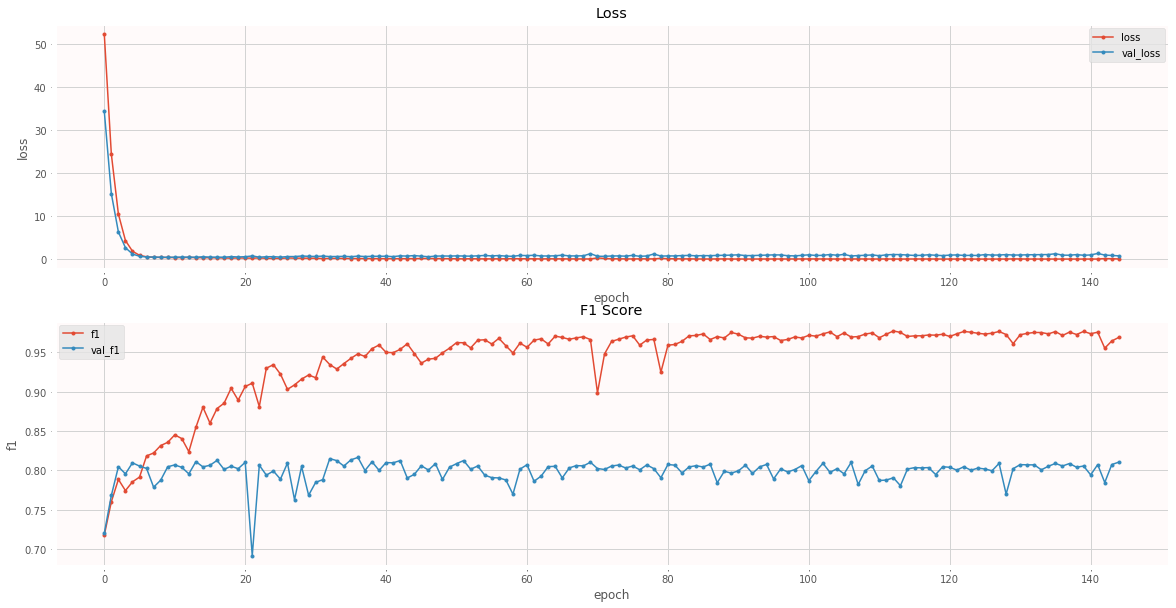

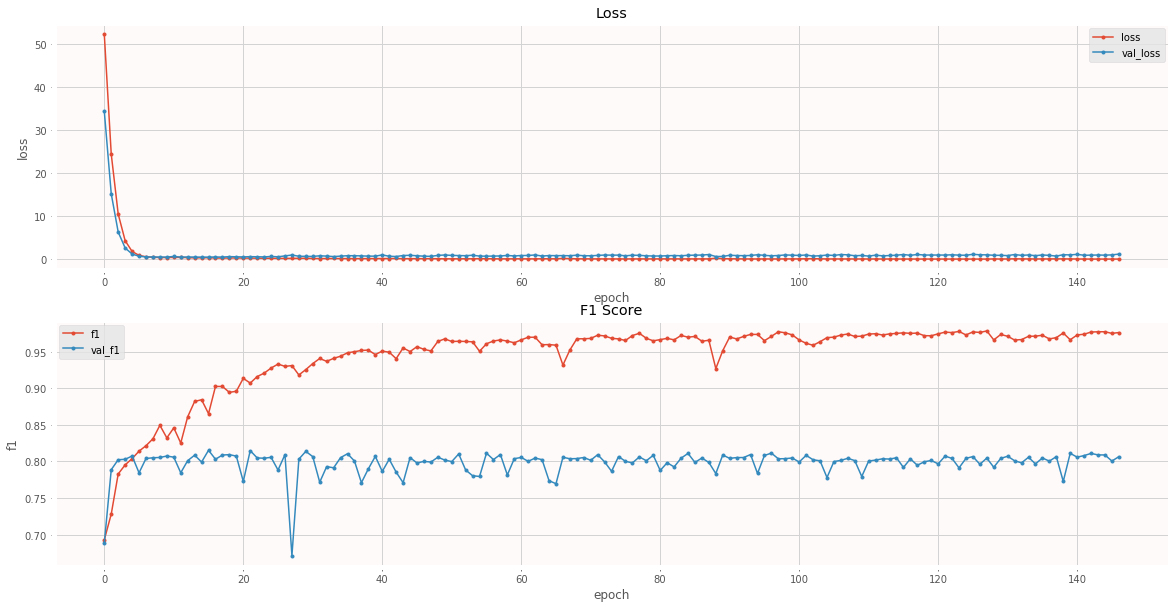

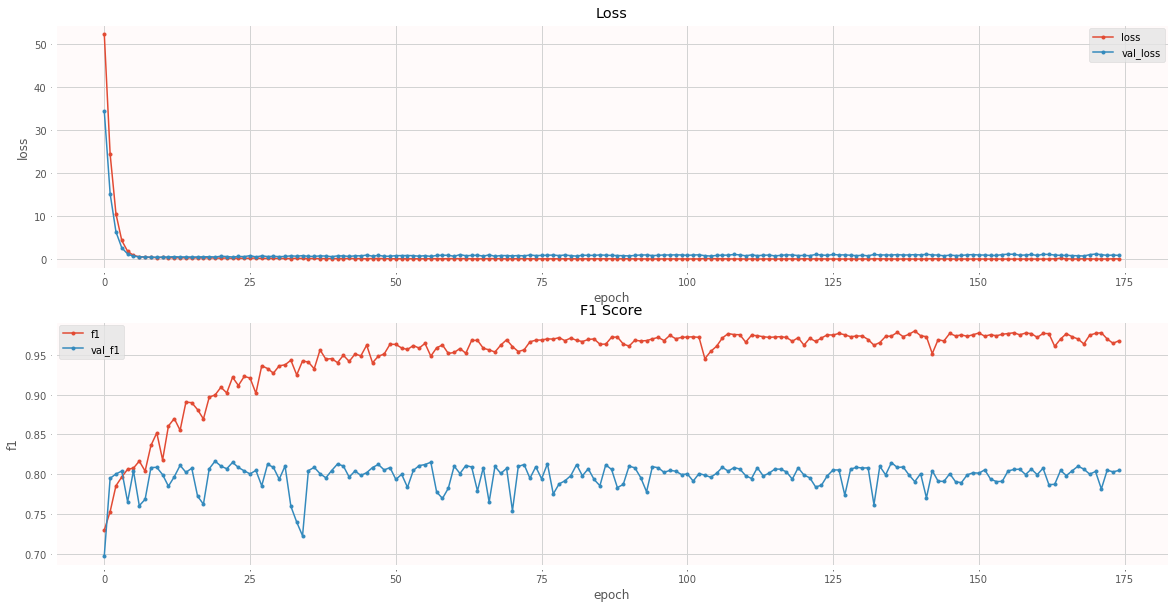

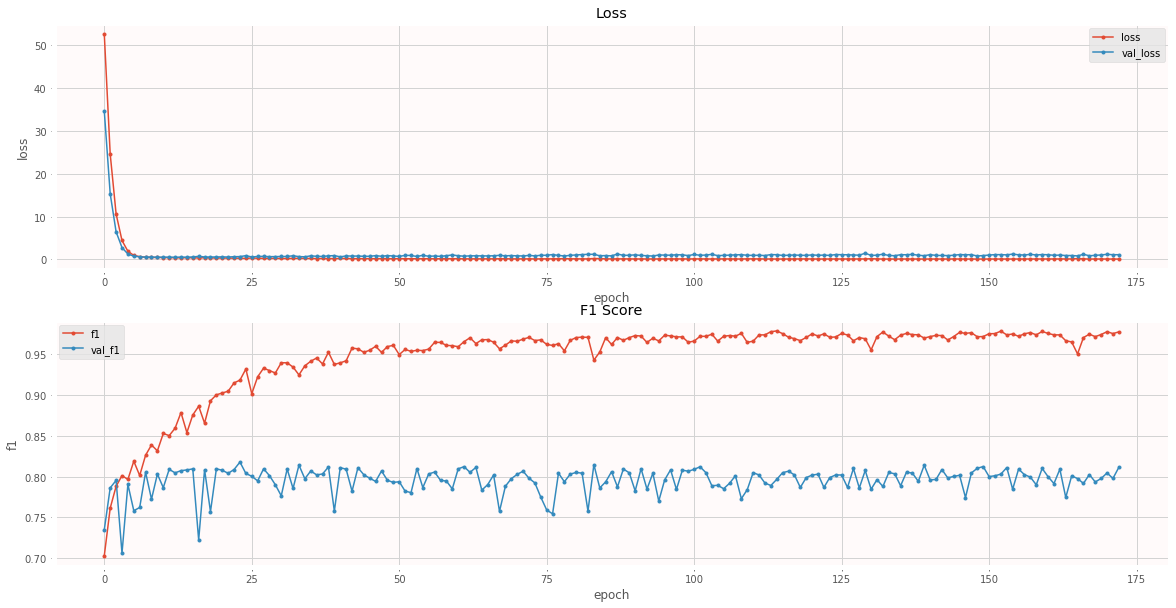

In [62]:
for i in range(len(cnn_lstm_history_list)):
    plot_history(cnn_lstm_history_list[i])

In [83]:
opt_list = ["adam", "sgd", "adagrad", "adadelta", "rmsprop", "nadam", "cocob"]
text_resnet_history_list = []
text_resnet_model_list = []
text_resnet_performance = []

for i, optimizer in enumerate([adam, sgd, adagrad, adadelta, rmsprop, nadam, cocob]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_text_resnet(x_train, y_train, embedding_matrix)
    text_resnet_history_list.append(history)
    text_resnet_model_list.append(model)
    
    y_pred = predict(x_test, model)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    text_resnet_performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(text_resnet_performance)

Training model using adam.
==================== Start Training Text-ResNet ====================
Train on 5166 samples, validate on 5166 samples
Epoch 1/500
5166/5166 [==============================] - 13s 2ms/step - loss: 88.4159 - get_f1: 0.6973 - val_loss: 55.2216 - val_get_f1: 0.7504
Epoch 2/500
5166/5166 [==============================] - 3s 624us/step - loss: 39.7274 - get_f1: 0.6899 - val_loss: 27.1168 - val_get_f1: 0.7440
Epoch 3/500
5166/5166 [==============================] - 3s 617us/step - loss: 21.7186 - get_f1: 0.6586 - val_loss: 16.9607 - val_get_f1: 0.7440
Epoch 4/500
5166/5166 [==============================] - 3s 617us/step - loss: 14.3907 - get_f1: 0.6998 - val_loss: 12.0244 - val_get_f1: 0.7440
Epoch 5/500
5166/5166 [==============================] - 3s 629us/step - loss: 10.4903 - get_f1: 0.7095 - val_loss: 9.1171 - val_get_f1: 0.7440
Epoch 6/500
5166/5166 [==============================] - 3s 643us/step - loss: 8.1849 - get_f1: 0.7320 - val_loss: 7.4585 - val_get_f

Epoch 57/500
5166/5166 [==============================] - 3s 631us/step - loss: 0.4421 - get_f1: 0.9440 - val_loss: 1.2318 - val_get_f1: 0.7440
Epoch 58/500
5166/5166 [==============================] - 3s 626us/step - loss: 0.4384 - get_f1: 0.9438 - val_loss: 1.9376 - val_get_f1: 0.0000e+00
Epoch 59/500
5166/5166 [==============================] - 3s 626us/step - loss: 0.9920 - get_f1: 0.9240 - val_loss: 1.3480 - val_get_f1: 0.7440
Epoch 60/500
5166/5166 [==============================] - 3s 625us/step - loss: 0.5279 - get_f1: 0.9287 - val_loss: 1.2636 - val_get_f1: 0.7440
Epoch 00060: early stopping
Confusion Matrix: 
 [[   0    0]
 [1084 1500]]
Training model using sgd.
==================== Start Training Text-ResNet ====================
Train on 5166 samples, validate on 5166 samples
Epoch 1/500
5166/5166 [==============================] - 13s 2ms/step - loss: 82.2188 - get_f1: 0.6932 - val_loss: 45.7737 - val_get_f1: 0.7501
Epoch 2/500
5166/5166 [==============================] - 3

5166/5166 [==============================] - 3s 625us/step - loss: 0.6144 - get_f1: 0.9122 - val_loss: 1.0892 - val_get_f1: 0.7440
Epoch 53/500
5166/5166 [==============================] - 3s 630us/step - loss: 0.4910 - get_f1: 0.9250 - val_loss: 1.0510 - val_get_f1: 0.7440
Epoch 54/500
5166/5166 [==============================] - 3s 628us/step - loss: 0.3976 - get_f1: 0.9354 - val_loss: 0.9888 - val_get_f1: 0.7440
Epoch 55/500
5166/5166 [==============================] - 3s 625us/step - loss: 0.3746 - get_f1: 0.9295 - val_loss: 0.9997 - val_get_f1: 0.7440
Epoch 56/500
5166/5166 [==============================] - 3s 623us/step - loss: 0.3734 - get_f1: 0.9407 - val_loss: 1.0217 - val_get_f1: 0.7440
Epoch 57/500
5166/5166 [==============================] - 3s 627us/step - loss: 0.5784 - get_f1: 0.9405 - val_loss: 5239.6097 - val_get_f1: 0.0000e+00
Epoch 58/500
5166/5166 [==============================] - 3s 629us/step - loss: 1.9588 - get_f1: 0.9302 - val_loss: 1.5009 - val_get_f1: 0.744

Epoch 109/500
5166/5166 [==============================] - 3s 628us/step - loss: 0.3091 - get_f1: 0.9658 - val_loss: 1.5935 - val_get_f1: 0.7440
Epoch 110/500
5166/5166 [==============================] - 3s 630us/step - loss: 0.2912 - get_f1: 0.9609 - val_loss: 1.6226 - val_get_f1: 0.7440
Epoch 111/500
5166/5166 [==============================] - 3s 624us/step - loss: 0.2665 - get_f1: 0.9666 - val_loss: 1.3631 - val_get_f1: 0.7440
Epoch 112/500
5166/5166 [==============================] - 3s 625us/step - loss: 0.2545 - get_f1: 0.9621 - val_loss: 1.5073 - val_get_f1: 0.7440
Epoch 00112: early stopping
Confusion Matrix: 
 [[   0    0]
 [1084 1500]]
Training model using adagrad.
==================== Start Training Text-ResNet ====================
Train on 5166 samples, validate on 5166 samples
Epoch 1/500
5166/5166 [==============================] - 13s 2ms/step - loss: 85.3305 - get_f1: 0.6959 - val_loss: 50.4352 - val_get_f1: 0.7489
Epoch 2/500
5166/5166 [==============================]

5166/5166 [==============================] - 3s 625us/step - loss: 1.5704 - get_f1: 0.8461 - val_loss: 1.6172 - val_get_f1: 0.7440
Epoch 15/500
5166/5166 [==============================] - 3s 625us/step - loss: 1.2263 - get_f1: 0.8397 - val_loss: 1.4771 - val_get_f1: 0.7440
Epoch 16/500
5166/5166 [==============================] - 3s 623us/step - loss: 1.1277 - get_f1: 0.8569 - val_loss: 1.3667 - val_get_f1: 0.7440
Epoch 17/500
5166/5166 [==============================] - 3s 627us/step - loss: 0.9729 - get_f1: 0.8590 - val_loss: 1.2658 - val_get_f1: 0.7440
Epoch 18/500
5166/5166 [==============================] - 3s 625us/step - loss: 0.8910 - get_f1: 0.8504 - val_loss: 1.2035 - val_get_f1: 0.7440
Epoch 19/500
5166/5166 [==============================] - 3s 626us/step - loss: 0.8459 - get_f1: 0.8756 - val_loss: 1.1853 - val_get_f1: 0.7440
Epoch 20/500
5166/5166 [==============================] - 3s 625us/step - loss: 0.7322 - get_f1: 0.8817 - val_loss: 1.1165 - val_get_f1: 0.7440
Epoch

Epoch 71/500
5166/5166 [==============================] - 3s 624us/step - loss: 1.0599 - get_f1: 0.9500 - val_loss: 6143871502.4700 - val_get_f1: 0.0000e+00
Epoch 72/500
5166/5166 [==============================] - 3s 627us/step - loss: 2.9937 - get_f1: 0.9449 - val_loss: 1.8638 - val_get_f1: 0.7795
Epoch 73/500
5166/5166 [==============================] - 3s 628us/step - loss: 0.8307 - get_f1: 0.9433 - val_loss: 1.4341 - val_get_f1: 0.7440
Epoch 74/500
5166/5166 [==============================] - 3s 622us/step - loss: 0.4267 - get_f1: 0.9431 - val_loss: 1.2601 - val_get_f1: 0.7440
Epoch 75/500
5166/5166 [==============================] - 3s 623us/step - loss: 0.3280 - get_f1: 0.9547 - val_loss: 1.2613 - val_get_f1: 0.7440
Epoch 76/500
5166/5166 [==============================] - 3s 625us/step - loss: 0.2945 - get_f1: 0.9522 - val_loss: 1.2355 - val_get_f1: 0.7440
Epoch 77/500
5166/5166 [==============================] - 3s 623us/step - loss: 0.2825 - get_f1: 0.9572 - val_loss: 1.2382 

5166/5166 [==============================] - 3s 633us/step - loss: 0.3544 - get_f1: 0.9391 - val_loss: 1.1860 - val_get_f1: 0.7440
Epoch 51/500
5166/5166 [==============================] - 3s 631us/step - loss: 0.3554 - get_f1: 0.9349 - val_loss: 0.8233 - val_get_f1: 0.7440
Epoch 52/500
5166/5166 [==============================] - 3s 630us/step - loss: 0.3584 - get_f1: 0.9366 - val_loss: 1.0802 - val_get_f1: 0.7440
Epoch 53/500
5166/5166 [==============================] - 3s 625us/step - loss: 0.3626 - get_f1: 0.9436 - val_loss: 0.8113 - val_get_f1: 0.7440
Epoch 54/500
5166/5166 [==============================] - 3s 642us/step - loss: 0.3274 - get_f1: 0.9462 - val_loss: 1.1678 - val_get_f1: 0.7440
Epoch 55/500
5166/5166 [==============================] - 3s 631us/step - loss: 0.3738 - get_f1: 0.9388 - val_loss: 1.0858 - val_get_f1: 0.7440
Epoch 56/500
5166/5166 [==============================] - 3s 630us/step - loss: 0.3569 - get_f1: 0.9414 - val_loss: 0.7428 - val_get_f1: 0.7885
Epoch

5166/5166 [==============================] - 3s 626us/step - loss: 1.1463 - get_f1: 0.8850 - val_loss: 1.3560 - val_get_f1: 0.7440
Epoch 28/500
5166/5166 [==============================] - 3s 632us/step - loss: 0.9489 - get_f1: 0.8898 - val_loss: 1.2138 - val_get_f1: 0.7440
Epoch 29/500
5166/5166 [==============================] - 3s 630us/step - loss: 0.8680 - get_f1: 0.8881 - val_loss: 1.1871 - val_get_f1: 0.7440
Epoch 30/500
5166/5166 [==============================] - 3s 626us/step - loss: 0.7691 - get_f1: 0.9021 - val_loss: 1.0674 - val_get_f1: 0.7440
Epoch 31/500
5166/5166 [==============================] - 3s 633us/step - loss: 0.6544 - get_f1: 0.8999 - val_loss: 1.0003 - val_get_f1: 0.7440
Epoch 32/500
5166/5166 [==============================] - 3s 633us/step - loss: 0.6454 - get_f1: 0.8966 - val_loss: 0.9852 - val_get_f1: 0.7440
Epoch 33/500
5166/5166 [==============================] - 3s 638us/step - loss: 0.5757 - get_f1: 0.9056 - val_loss: 0.9477 - val_get_f1: 0.7440
Epoch

5166/5166 [==============================] - 3s 636us/step - loss: 1.1441 - get_f1: 0.8872 - val_loss: 3.0255 - val_get_f1: 0.0000e+00
Epoch 72/500
5166/5166 [==============================] - 3s 632us/step - loss: 1.2680 - get_f1: 0.9125 - val_loss: 1.4445 - val_get_f1: 5.8789e-04
Epoch 73/500
5166/5166 [==============================] - 3s 637us/step - loss: 0.8550 - get_f1: 0.9068 - val_loss: 1.1548 - val_get_f1: 0.7588
Epoch 74/500
5166/5166 [==============================] - 3s 644us/step - loss: 0.6589 - get_f1: 0.9277 - val_loss: 0.9746 - val_get_f1: 0.7440
Epoch 75/500
5166/5166 [==============================] - 3s 632us/step - loss: 0.8486 - get_f1: 0.8915 - val_loss: 4.2477 - val_get_f1: 0.7440
Epoch 76/500
5166/5166 [==============================] - 3s 635us/step - loss: 0.8061 - get_f1: 0.9062 - val_loss: 0.9928 - val_get_f1: 0.7392
Epoch 77/500
5166/5166 [==============================] - 3s 638us/step - loss: 0.9192 - get_f1: 0.9191 - val_loss: 1.0419 - val_get_f1: 0.76

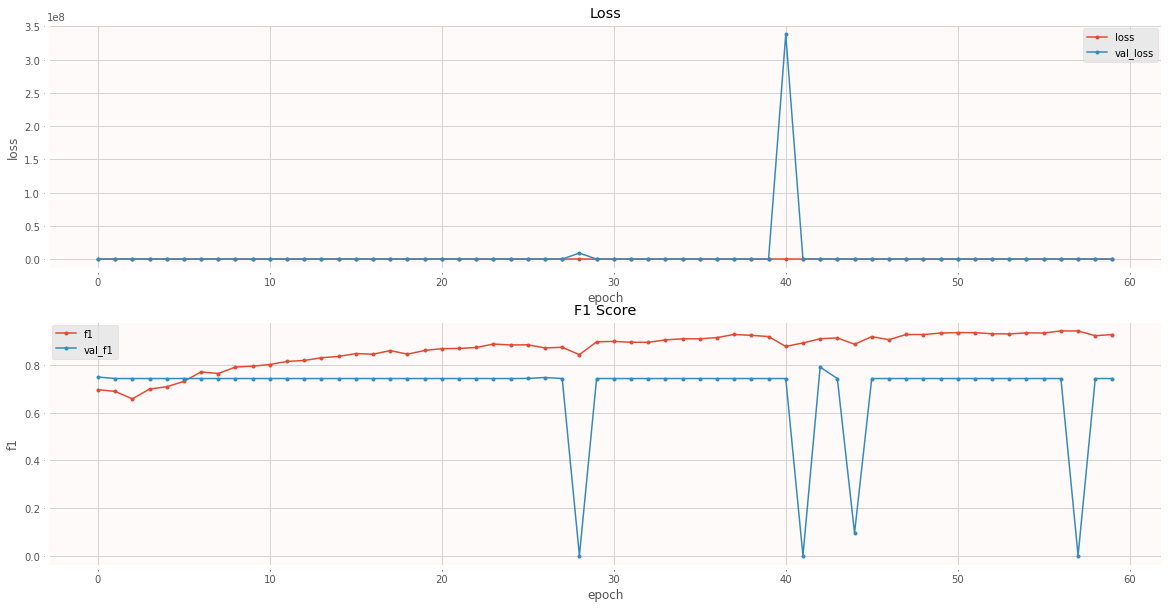

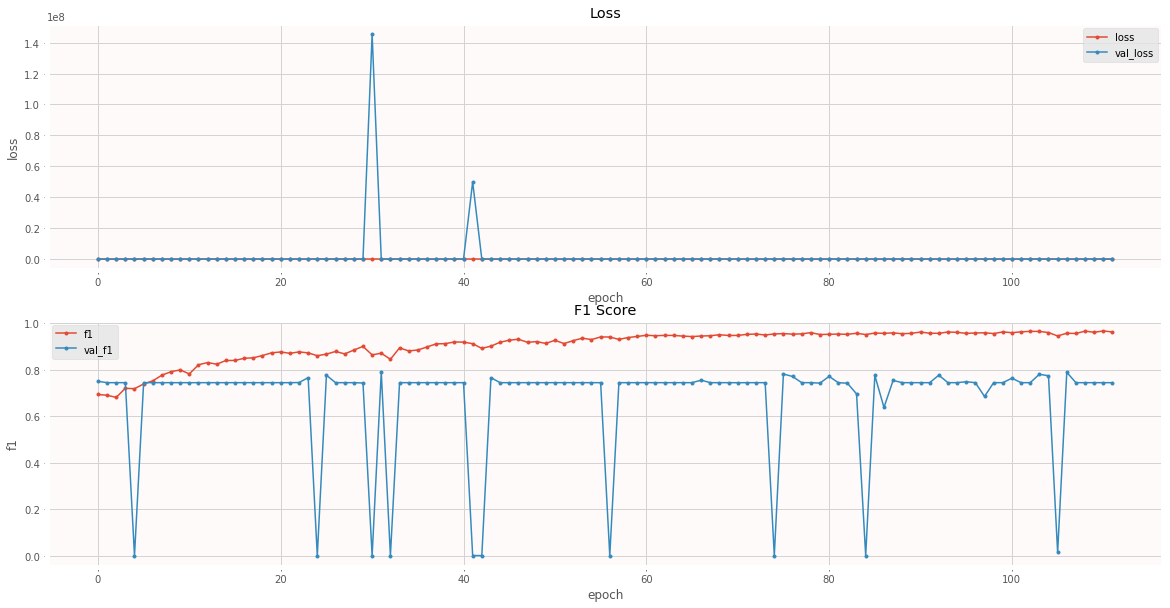

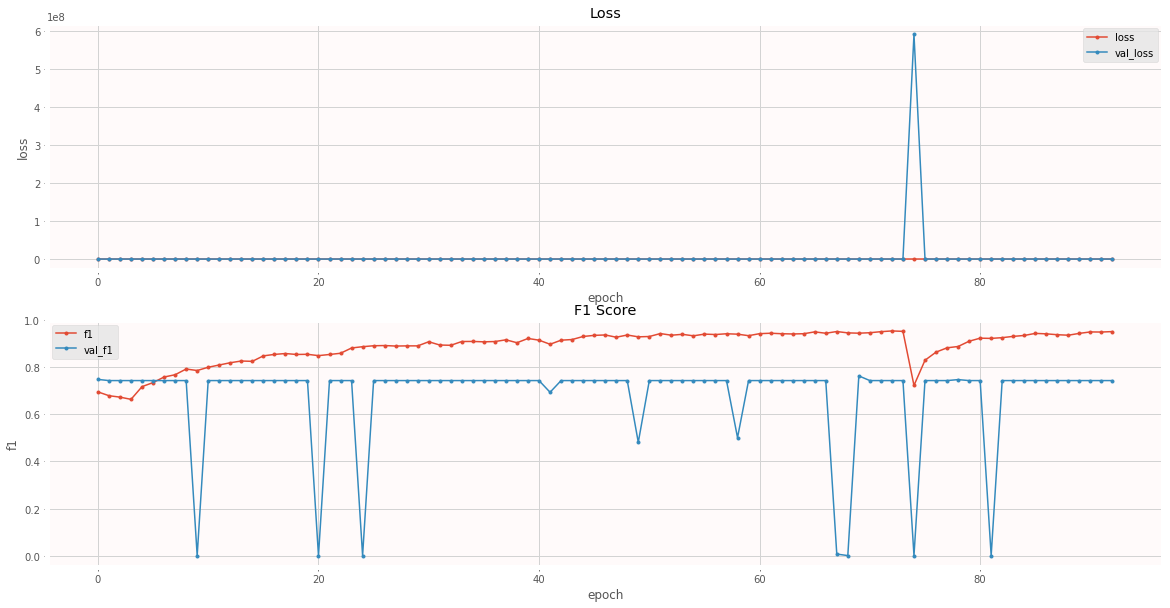

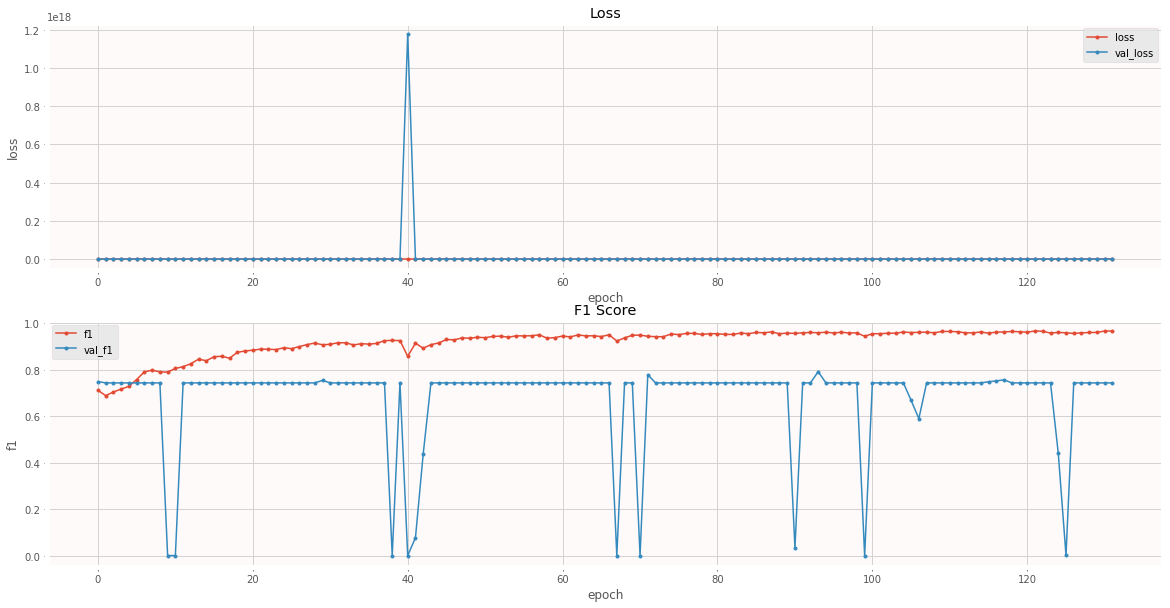

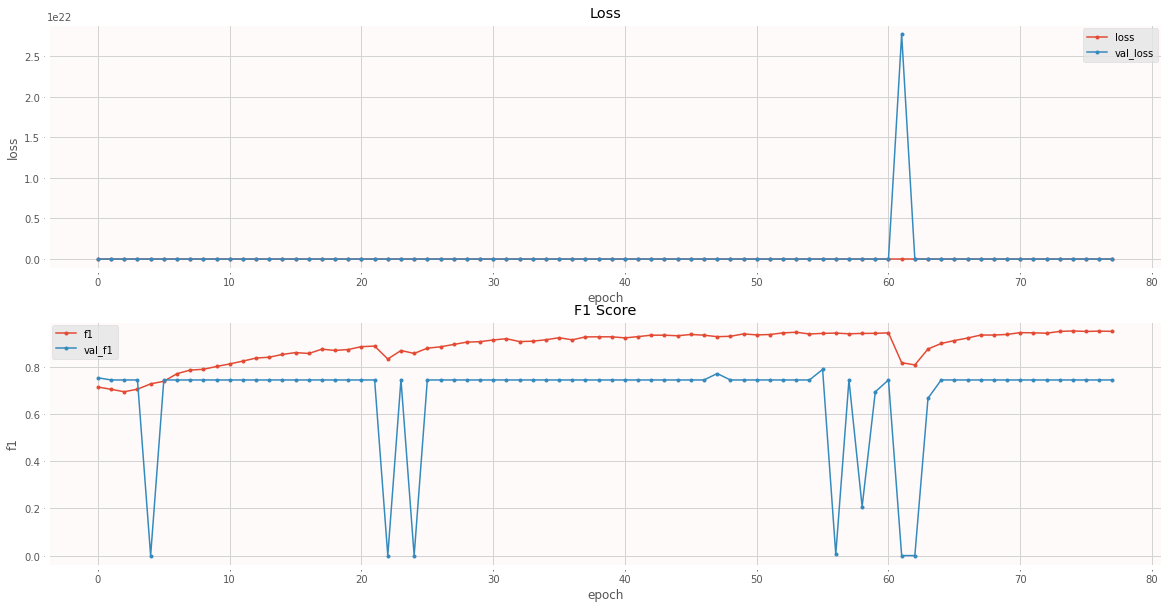

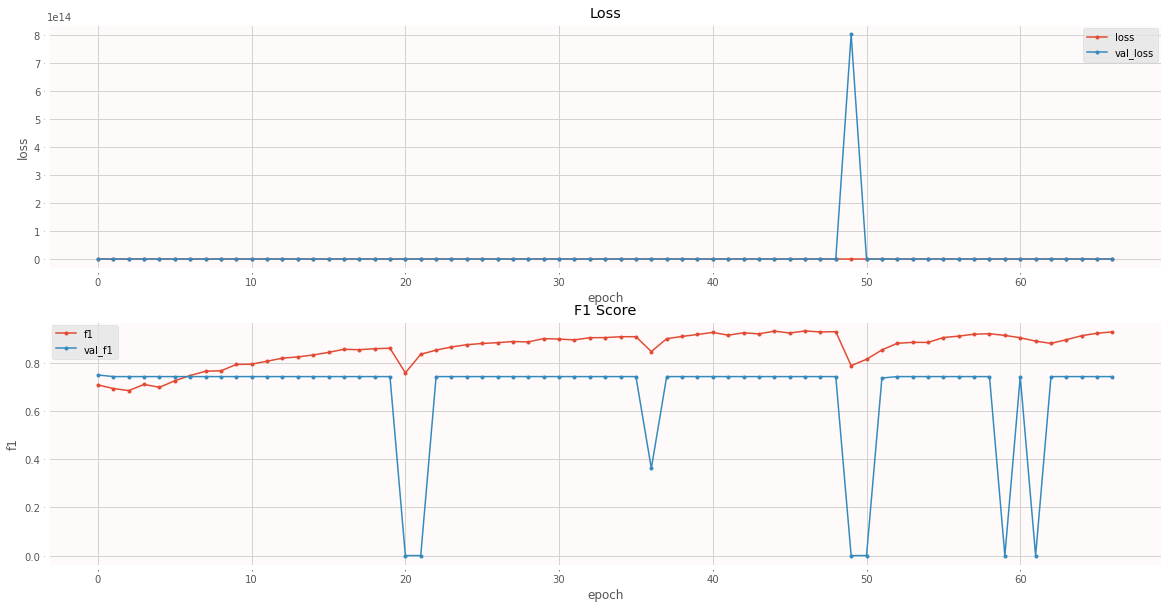

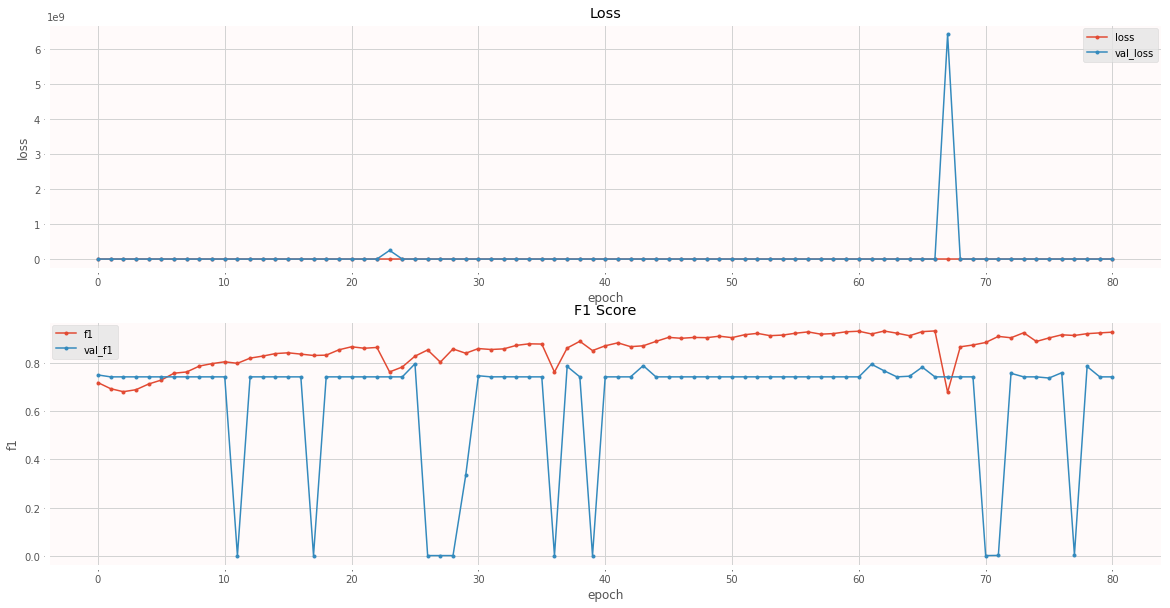

In [84]:
for i in range(len(text_resnet_history_list)):
    plot_history(text_resnet_history_list[i])

In [39]:
# plt.savefig(r'C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\image\cumulative_percentage.png', 
#             bbox_inches='tight')